## Vm ~ B2 / (f Rm)


In [1]:
# General
import glob
import os.path
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib.colors import Normalize
# from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import pandas as pd

# Data treatment
import dask as da
from dask.diagnostics import ProgressBar
import zarr
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from scipy.signal import argrelextrema
from datetime import datetime

# Custom
# import functions as f

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PRMS = {
    'save_figs':        False,
}

PTHS = {
    'data_dir':         '/home/arthur/data/cyclobs/centered_rotated_files_31012022/',
    'dsg_pth':          '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
    'dsg2_pth':         '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_17102022_with_extra_params.nc',
    'save_dir':         '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_STEADY_STATE_CRIT/02_VMAX_B_RELATION/',
}

### OPEN DATA
all_data = glob.glob(PTHS['data_dir'] + "*.nc")
print("Total number of files:", len(all_data))

Total number of files: 335


In [3]:
dsg = xr.open_dataset(PTHS['dsg_pth'])

### Add intensification parameters
dsg2 = xr.open_dataset(PTHS['dsg2_pth'])
dsg['Vmax_dot_smth_IBT'] = xr.DataArray(
    data=np.array(dsg2['Vmax_dot_smth_IBT']),
    coords={'time': dsg.time}
)
dsg['Vmax_dot_IBT'] = xr.DataArray(
    data=np.array(dsg2['Vmax_dot_IBT']),
    coords={'time': dsg.time}
)
dsg['R17_dot_IBT'] = xr.DataArray(
    data=np.array(dsg2['R17_dot_IBT']),
    coords={'time': dsg.time}
)
dsg['R17_dot_smth_IBT'] = xr.DataArray(
    data=np.array(dsg2['R17_dot_smth_IBT']),
    coords={'time': dsg.time}
)

### Kinetic energy
K1_SAR = dsg['Vmax_1D'] * (dsg['Vmax_dot_smth_IBT'] * 3600) * ((dsg['R17_1D'] * 1000) ** 2)
K2_SAR = dsg['R17_1D'] * 1000 * (dsg['R17_dot_smth_IBT'] * 1000 * 3600) * (dsg['Vmax_1D'] ** 2)
K1_IBT = dsg['Vmax_IBT'] * (dsg['Vmax_dot_smth_IBT'] * 3600) * ((dsg['R34_IBT']) ** 2) 
K2_IBT = dsg['R34_IBT'] * (dsg['R17_dot_smth_IBT'] * 1000 * 3600) * (dsg['Vmax_IBT'] ** 2)

dsg['dKdt_SAR'] = K1_SAR + K2_SAR
dsg['dKdt_IBT'] = K1_IBT + K2_IBT

In [4]:
### FILTER
dsg = dsg.where(dsg.distance_to_coast > dsg.R17_1D * 1000, drop=True)
dsg = dsg.where(abs(dsg.lat_center) < 30, drop=True)
dsg = dsg.where(dsg.B_hol > 0.1, drop=True)
dsg = dsg.where(dsg.Vmax_1D > 20, drop=True)
# dsg = dsg.where(dsg.lon_center < -50, drop=True) # Keep only USA best-track agencies
# dsg = dsg.where(dsg.distance_to_coast > 200000, drop=True)
print('Nb of storms: {}'.format(len(dsg.time)))

Nb of storms: 184


In [5]:
### FUNCTIONS
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def vorticity(r, v):
    '''Relative vorticity'''
    dr = 1000 # meters
    return (1 / r) * np.gradient(r * v, dr)

def h80(r, vm, rm, B, lat):
    '''Holland 1980 profile.'''
    fcor = abs(coriolis(lat))
    V    = r * 0.
    V    = np.sqrt((vm ** 2) * ((rm / r) ** B) * np.exp(1 - (rm / r) ** B) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def rkne_x(r, vm, rm, x):
    '''Modified Rankine profile'''
    V          = vm * (r / rm)
    V_ou       = vm * (rm / r) ** x
    V[r >= rm] = V_ou[r >= rm]
    return V

In [6]:
# ### Computing Kinetic Energy
# alpha       = 1.5
# dsg['dKdt'] = alpha * ((dsg['R17_1D'] * 1000 * dsg['Vmax_1D']) ** (alpha - 1)) * ((dsg['Vmax_dot_smth_IBT'] * 3600) * (dsg['R17_1D'] * 1000) + (dsg['R17_dot_smth_IBT'] * 1000 * 3600) * dsg['Vmax_1D'])
# nrm         = 1e13
# dsg['dKdt'] = dsg['dKdt'] / nrm

# # plt.hist(abs(dsg.dKdt), bins=300)
# # plt.xlim(0, 0.35)
# # plt.hist(abs(dsg.dKdt) / 1e9, bins=1000);plt.xlim(0, 0.25)

In [7]:
# ### Computing Kinetic Energy
# alpha       = 2
# dsg['dKdt'] = alpha * ((dsg['R17_1D'] * 1000 * dsg['Vmax_1D']) ** (alpha - 1)) * ((dsg['Vmax_dot_smth_IBT'] * 3600) * (dsg['R17_1D'] * 1000) + (dsg['R17_dot_smth_IBT'] * 1000 * 3600) * dsg['Vmax_1D'])
# nrm         = 2e16
# dsg['dKdt'] = dsg['dKdt'] / nrm

In [8]:
### Computing Kinetic Energy
V34 = 17.5
g   = 9.8

dsg['dKdt'] = ((V34 ** 2 / (2 * g)) / 3600) * 2 * (dsg['R17_1D'] * 1000 * dsg['Vmax_1D']) * ((dsg['Vmax_dot_smth_IBT']) * (dsg['R17_1D'] * 1000) + (dsg['R17_dot_smth_IBT'] * 1000) * dsg['Vmax_1D'])
nrm         = 1e9
dsg['dKdt'] = dsg['dKdt'] / nrm

# plt.hist(abs(dsg.dKdt), bins=300)
# plt.xlim(0, 0.35)
# plt.hist(abs(dsg.dKdt) / 1e9, bins=1000);plt.xlim(0, 0.25)

In [9]:
### COLORMAP
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
cmap_ini = cm.get_cmap('OrRd')
cmap     = truncate_colormap(cmap_ini, 0.2, 0.7) # Truncate colormap

In [12]:
### INTRO CASES
sat_file = 's1b-ew-owi-cm-20210926t090903-20210926t091107-000003-0371EC_sw.nc'
sam      = dsg.where(dsg.sat_file == sat_file, drop=True).isel(time=0)
# print('dVmx/dt = {:.2f} m/s/hr'.format(sam.Vmax_dot_smth_IBT))
# print('dR34/dt = {:.2f} km/hr'.format(sam.R17_dot_smth_IBT))
# print('')
# print('Vmax = {:.0f} m/s'.format(sam.Vmax_1D))
# print('R34  = {:.0f} km'.format(sam.R17_1D))
# print('')
# print('dK/dt = {:.3f}'.format(sam.dKdt))

In [21]:
# Wutip
sat_file = 's1b-ew-owi-cm-20190223t202348-20190223t202552-000003-01C2E0_sw.nc'
wutip    = dsg.where(dsg.sat_file == sat_file, drop=True).isel(time=0)
# print('dVmx/dt = {:.2f} m/s/hr'.format(wutip.Vmax_dot_smth_IBT))
# print('dR34/dt = {:.2f} km/hr'.format(wutip.R17_dot_smth_IBT))
# print('')
# print('Vmax = {:.0f} m/s'.format(wutip.Vmax_1D))
# print('R34  = {:.0f} km'.format(wutip.R17_1D))
# print('')
# print('dK/dt = {:.3f}'.format(wutip.dKdt))
# Sergio
sat_file = 's1a-ew-owi-cm-20181003t134006-20181003t134210-000003-029E52_sw.nc'
sergio = dsg.where(dsg.sat_file == sat_file, drop=True)
# Andres
sat_file = 'rs2--owi-cm-20150601t015945-20150601t020101-00003-BDBF8_sw.nc'
andres = dsg.where(dsg.sat_file == sat_file, drop=True)

# Steady cases
jebi = dsg.where(dsg.sat_file == 's1b-ew-owi-cm-20180829t075408-20180829t075612-000003-017011_sw.nc', drop=True).isel(time=0)
goni = dsg.where(dsg.sat_file == 's1a-ew-owi-cm-20201030t092540-20201030t092711-000003-0415F8_sw.nc', drop=True).isel(time=0) # real goni
# goni = dsg.where(dsg.sat_file == 's1a-ew-owi-cm-20180807t154302-20180807t154506-000003-028386_sw.nc', drop=True).isel(time=0) # Hector
# goni = dsg.where(dsg.sat_file == 'rs2--owi-cm-20141103t131130-20141103t131246-00003-E41DD_sw.nc', drop=True).isel(time=0) # Vance
lane = dsg.where(dsg.sat_file == 's1a-iw-owi-cm-20180823t043704-20180823t043913-000003-028AD1_sw.nc', drop=True).isel(time=0) # Lane


# Non steady cases
surigae = dsg.where(dsg.sat_file == 'rs2--owi-cm-20210421t094352-20210421t094508-00003-F7A21_sw.nc', drop=True).isel(time=0) # real Surigae
meranti = dsg.where(dsg.sat_file == 'rs2--owi-cm-20160912t212718-20160912t213122-00003-BDC5F_sw.nc', drop=True).isel(time=0) # Meranti

In [33]:
print('Lane')
print('dVmx/dt = {:.2f} m/s/hr'.format(lane.Vmax_dot_smth_IBT))
print('dR34/dt = {:.2f} km/hr'.format(lane.R17_dot_smth_IBT))
print('dK/dt = {:.3f}'.format(lane.dKdt * nrm))
print('Vmax = {:.0f} m/s'.format(lane.Vmax_1D))
print('R34  = {:.0f} km'.format(lane.R17_1D))

print('\nMeranti')
print('dVmx/dt = {:.2f} m/s/hr'.format(meranti.Vmax_dot_smth_IBT))
print('dR34/dt = {:.2f} km/hr'.format(meranti.R17_dot_smth_IBT))
print('dK/dt = {:.3f}'.format(meranti.dKdt * nrm))
print('Vmax = {:.0f} m/s'.format(meranti.Vmax_1D))
print('R34  = {:.0f} km'.format(meranti.R17_1D))

Lane
dVmx/dt = -0.21 m/s/hr
dR34/dt = 0.00 km/hr
dK/dt = -910525812.789
Vmax = 54 m/s
R34  = 95 km

Meranti
dVmx/dt = 0.27 m/s/hr
dR34/dt = 4.37 km/hr
dK/dt = 29372748667.080
Vmax = 58 m/s
R34  = 191 km


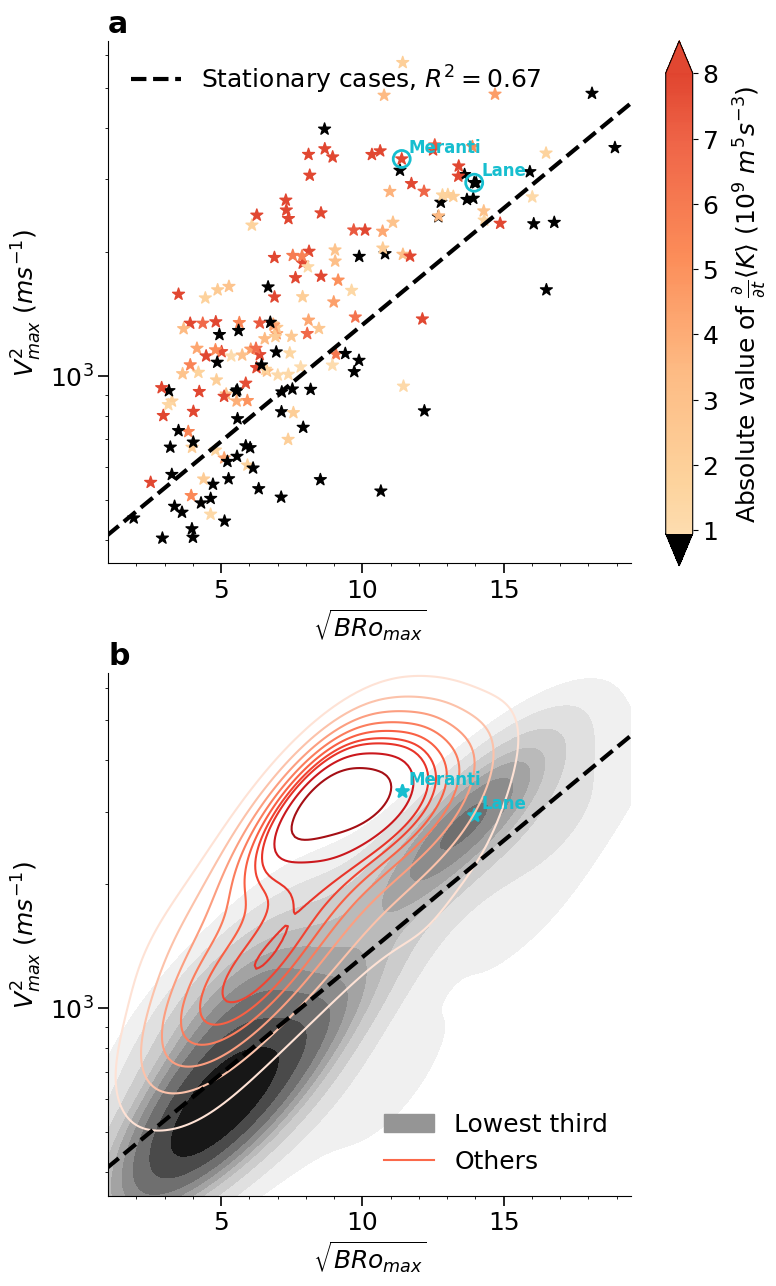

In [23]:
from matplotlib.gridspec import GridSpec
### FIGURE
fig        = plt.figure(figsize=(15, 15))
gs         = GridSpec(2, 1, hspace=0.21, wspace=0.1)

# Colorbar
c_min = abs(dsg.dKdt).quantile(0.33)
c_max = abs(dsg.dKdt).quantile(0.8)
cmap.set_under('k')
cmap.set_over(cmap(0.99))

#####################
### SCATTER PLOT  ###
#####################
ax = fig.add_subplot(gs[0, 0])
ax.set_title('a', weight='bold', loc='left')

# Plot
sm = ax.scatter(np.sqrt(dsg.B_hol * dsg.Vmax_1D / (abs(coriolis(dsg.lat_center)) * dsg.Rmax_1D * 1000)), dsg.Vmax_1D ** 2, marker='*', s=80, c=abs(dsg.dKdt), vmin=c_min, vmax=c_max, cmap=cmap)

# STEADY
clr = 'tab:cyan'
std_case = lane
ax.scatter(np.sqrt(std_case.B_hol * std_case.Vmax_1D / (abs(coriolis(std_case.lat_center)) * std_case.Rmax_1D * 1000)), std_case.Vmax_1D ** 2, facecolors='none', edgecolors=clr, s=150, linewidth=2)
ax.annotate('Lane', (np.sqrt(std_case.B_hol * std_case.Vmax_1D / (abs(coriolis(std_case.lat_center)) * std_case.Rmax_1D * 1000)), std_case.Vmax_1D ** 2), fontsize=12, color=clr, weight='bold', xytext=(5, 5), textcoords='offset points')
# UNSTEADY
nsd_case = meranti
ax.scatter(np.sqrt(nsd_case.B_hol * nsd_case.Vmax_1D / (abs(coriolis(nsd_case.lat_center)) * nsd_case.Rmax_1D * 1000)), nsd_case.Vmax_1D ** 2, facecolors='none', edgecolors=clr, s=150, linewidth=2)
ax.annotate('Meranti', (np.sqrt(nsd_case.B_hol * nsd_case.Vmax_1D / (abs(coriolis(nsd_case.lat_center)) * nsd_case.Rmax_1D * 1000)), nsd_case.Vmax_1D ** 2), fontsize=12, color=clr, weight='bold', xytext=(5, 5), textcoords='offset points')

# Regression
from sklearn.linear_model import LinearRegression
d_std = dsg.where(abs(dsg.dKdt) < c_min, drop=True)
X     = np.expand_dims(np.sqrt(d_std.B_hol * d_std.Vmax_1D / (abs(coriolis(d_std.lat_center)) * d_std.Rmax_1D * 1000)), axis=1)
y     = (d_std.Vmax_1D ** 2)
reg   = LinearRegression().fit(X, np.log10(y))
ax.plot(np.linspace(np.min(X) * 0.5, np.max(X) * 2, 100), 10 ** float(reg.intercept_) * 10 ** (float(reg.coef_) * np.linspace(np.min(X) * 0.5, np.max(X) * 2, 100)), color='k', linestyle='--', label=r'Stationary cases, $R^2 = ${:.2f}'.format(reg.score(X, np.log10(y))), linewidth=3)

# Grid, legend
ax.legend(loc='upper left', frameon=False)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_yscale('log')
ax.set_ylim(3.5e2, 6.5e3)
ax.set_xlim(1, 19.5)
ax.set_ylabel(r'$V_{max}^2$ ($m s^{-1}$)')
ax.set_xlabel(r'$\sqrt{B Ro_{max}}$')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
# Colorbar
cb_ax = fig.add_axes([0.71, 0.53, 0.018, 0.35])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(r'Absolute value of $\frac{\partial}{\partial t} \langle K \rangle $ ($10^{9}$ $m^5 s^{-3}$)', rotation=90)
cbar.ax.get_yaxis().labelpad=8

################
### DENSITIES###
################
ax = fig.add_subplot(gs[1, 0])
ax.set_title('b', weight='bold', loc='left')

# Colormap
greys             = cm.get_cmap('Greys', 256)
newcolors         = greys(np.linspace(0, 1, 256))
newcolors[:25, :] = mpl.colors.to_rgba('white')
newcmp            = mpl.colors.ListedColormap(newcolors)

# Plot
import seaborn as sns
d_std  = dsg.where(abs(dsg.dKdt) < c_min, drop=True) # steady
d_rst  = dsg.where(abs(dsg.dKdt) > c_min, drop=True) # unsteady
df_std = pd.DataFrame(data={'x': np.array(np.sqrt(d_std.B_hol * d_std.Vmax_1D / (abs(coriolis(d_std.lat_center)) * d_std.Rmax_1D * 1000))).flatten(), 'y': np.array(d_std.Vmax_1D ** 2).flatten(), 'w': np.array(abs(d_std.dKdt) / abs(d_std.dKdt).max(skipna=True)).flatten()})
df_rst = pd.DataFrame(data={'x': np.array(np.sqrt(d_rst.B_hol * d_rst.Vmax_1D / (abs(coriolis(d_rst.lat_center)) * d_rst.Rmax_1D * 1000))).flatten(), 'y': np.array(d_rst.Vmax_1D ** 2).flatten(), 'w': np.array(abs(d_rst.dKdt) / abs(d_rst.dKdt).max(skipna=True)).flatten()})
sns.kdeplot(df_std,  x='x', y='y', weights='w', cmap=newcmp,              fill=True,  levels=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], ax=ax, log_scale=(False, True), linewidth=0.0015625)
sns.kdeplot(df_rst,  x='x', y='y', weights='w', cmap=cm.get_cmap('Reds'), fill=False, levels=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], ax=ax, log_scale=(False, True))

# Regression
ax.plot(np.linspace(np.min(X) * 0.5, np.max(X) * 2, 100), 10 ** float(reg.intercept_) * 10 ** (float(reg.coef_) * np.linspace(np.min(X) * 0.5, np.max(X) * 2, 100)), color='k', linestyle='--', linewidth=3)

# Cases
ax.scatter(np.sqrt(std_case.B_hol * std_case.Vmax_1D / (abs(coriolis(std_case.lat_center)) * std_case.Rmax_1D * 1000)), std_case.Vmax_1D ** 2, facecolors=clr, edgecolors=clr, marker='*', s=80, linewidth=2)
ax.annotate('Lane', (np.sqrt(std_case.B_hol * std_case.Vmax_1D / (abs(coriolis(std_case.lat_center)) * std_case.Rmax_1D * 1000)), std_case.Vmax_1D ** 2), fontsize=12, color=clr, weight='bold', xytext=(5, 5), textcoords='offset points')
ax.scatter(np.sqrt(nsd_case.B_hol * nsd_case.Vmax_1D / (abs(coriolis(nsd_case.lat_center)) * nsd_case.Rmax_1D * 1000)), nsd_case.Vmax_1D ** 2, facecolors=clr, edgecolors=clr, marker='*', s=80, linewidth=2)
ax.annotate('Meranti', (np.sqrt(nsd_case.B_hol * nsd_case.Vmax_1D / (abs(coriolis(nsd_case.lat_center)) * nsd_case.Rmax_1D * 1000)), nsd_case.Vmax_1D ** 2), fontsize=12, color=clr, weight='bold', xytext=(5, 5), textcoords='offset points')

# Grid
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_yscale('log')
ax.set_ylim(3.5e2, 6.5e3)
ax.set_xlim(1, 19.5)
ax.set_ylabel(r'$V_{max}^2$ ($m s^{-1}$)')
ax.set_xlabel(r'$\sqrt{B Ro_{max}}$')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
# Legend
ax.fill_between([], [], [], label='Lowest third',   color=newcmp(0.5))
ax.plot([], [],             label='Others', color=cm.get_cmap('Reds')(0.5))
ax.legend(loc='lower right', frameon=False)

# plt.savefig(PTHS['save_dir'] + 'stationary_crit_final.pdf', bbox_inches='tight', format='pdf')

if PRMS['save_figs']:
    plt.savefig(PTHS['save_dir'] + 'stationary_crit_wdsb.pdf', bbox_inches='tight', format='pdf')
    # plt.savefig(PTHS['save_dir'] + 'stationary_crit_wdsb.pdf', bbox_inches='tight', format='pdf')

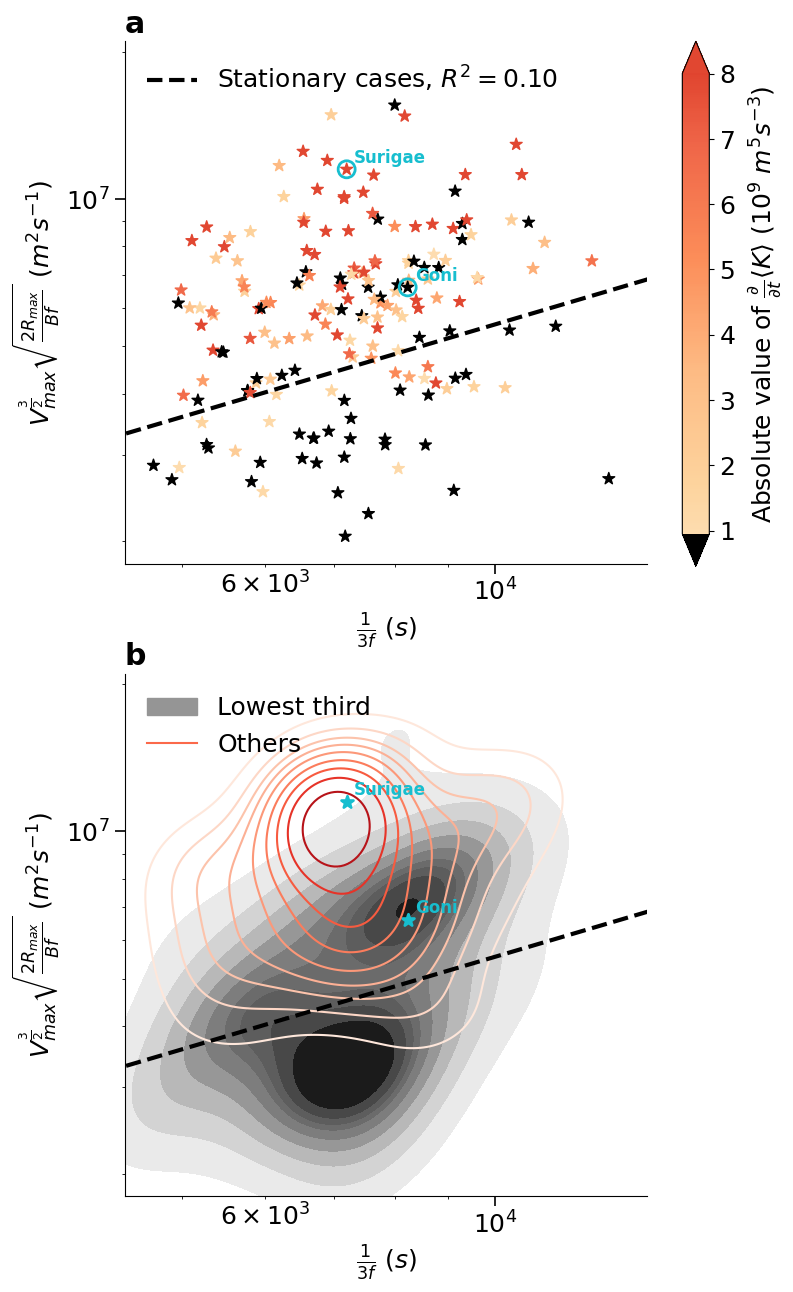

In [24]:
from matplotlib.gridspec import GridSpec
### FIGURE
fig        = plt.figure(figsize=(15, 15))
gs         = GridSpec(2, 1, hspace=0.21, wspace=0.1)

# Colorbar
c_min = abs(dsg.dKdt).quantile(0.33)
c_max = abs(dsg.dKdt).quantile(0.8)
cmap.set_under('k')
cmap.set_over(cmap(0.99))

#####################
### SCATTER PLOT  ###
#####################
ax = fig.add_subplot(gs[0, 0])
ax.set_title('a', weight='bold', loc='left')

# Plot
sm = ax.scatter(1 / (3 * abs(coriolis(dsg.lat_center))), (dsg.Vmax_1D ** 1.5) * np.sqrt(2 * dsg.Rmax_1D * 1000 / (dsg.B_hol * abs(coriolis(dsg.lat_center)))), marker='*', s=80, c=abs(dsg.dKdt), vmin=c_min, vmax=c_max, cmap=cmap)

# SAM
clr = 'tab:cyan'
std_case = goni
ax.scatter(1 / (3 * abs(coriolis(std_case.lat_center))), (std_case.Vmax_1D ** 1.5) * np.sqrt(2 * std_case.Rmax_1D * 1000 / (std_case.B_hol * abs(coriolis(std_case.lat_center)))), facecolors='none', edgecolors=clr, s=150, linewidth=2)
ax.annotate('Goni', (1 / (3 * abs(coriolis(std_case.lat_center))), (std_case.Vmax_1D ** 1.5) * np.sqrt(2 * std_case.Rmax_1D * 1000 / (std_case.B_hol * abs(coriolis(std_case.lat_center))))), fontsize=12, color=clr, weight='bold', xytext=(5, 5), textcoords='offset points')
# WUTIP
nsd_case = surigae
ax.scatter(1 / (3 * abs(coriolis(nsd_case.lat_center))), (nsd_case.Vmax_1D ** 1.5) * np.sqrt(2 * nsd_case.Rmax_1D * 1000 / (nsd_case.B_hol * abs(coriolis(nsd_case.lat_center)))), facecolors='none', edgecolors=clr, s=150, linewidth=2)
ax.annotate('Surigae', (1 / (3 * abs(coriolis(nsd_case.lat_center))), (nsd_case.Vmax_1D ** 1.5) * np.sqrt(2 * nsd_case.Rmax_1D * 1000 / (nsd_case.B_hol * abs(coriolis(nsd_case.lat_center))))), fontsize=12, color=clr, weight='bold', xytext=(5, 5), textcoords='offset points')

# Regression
from sklearn.linear_model import LinearRegression
d_std = dsg.where(abs(dsg.dKdt) < c_min, drop=True)
X     = np.expand_dims(1 / (3 * abs(coriolis(d_std.lat_center))), axis=1)
y     = (d_std.Vmax_1D ** 1.5) * np.sqrt(2 * d_std.Rmax_1D * 1000 / (d_std.B_hol * abs(coriolis(d_std.lat_center))))
reg   = LinearRegression().fit(np.log10(X), np.log10(y))
ax.plot(np.linspace(np.min(X) * 0.5, np.max(X) * 2, 100), 10 ** float(reg.intercept_) * np.power(np.linspace(np.min(X) * 0.5, np.max(X) * 2, 100), float(reg.coef_)), color='k', linestyle='--', label=r'Stationary cases, $R^2 = ${:.2f}'.format(reg.score(np.log10(X), np.log10(y))), linewidth=3)

# Grid, legend
ax.legend(loc='upper left', frameon=False)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1.8e6, 2.1e7)
ax.set_xlim(4.4e3, 1.4e4)
# ax.axvline(4.4e3);ax.axvline(1.4e4)
# ax.axhline(1.8e6);ax.axhline(2.1e7)
ax.set_ylabel(r'$V_{max}^{\frac{3}{2}} \sqrt{\frac{2 R_{max}}{Bf}}$ ($m^2 s^{-1}$)')
ax.set_xlabel(r'$\frac{1}{3 f}$ ($s$)')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
# Colorbar
cb_ax = fig.add_axes([0.71, 0.53, 0.018, 0.35])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(r'Absolute value of $\frac{\partial}{\partial t} \langle K \rangle $ ($10^{9}$ $m^5 s^{-3}$)', rotation=90)
cbar.ax.get_yaxis().labelpad=8

################
### DENSITIES###
################
ax = fig.add_subplot(gs[1, 0])
ax.set_title('b', weight='bold', loc='left')

# Colormap
greys             = cm.get_cmap('Greys', 256)
newcolors         = greys(np.linspace(0, 1, 256))
newcolors[:25, :] = mpl.colors.to_rgba('white')
newcmp            = mpl.colors.ListedColormap(newcolors)

# Plot
import seaborn as sns
d_std  = dsg.where(abs(dsg.dKdt) < c_min, drop=True) # steady
d_rst  = dsg.where(abs(dsg.dKdt) > c_min, drop=True) # unsteady
df_std = pd.DataFrame(data={'x': np.array(1 / (3 * abs(coriolis(d_std.lat_center)))).flatten(), 'y': np.array((d_std.Vmax_1D ** 1.5) * np.sqrt(2 * d_std.Rmax_1D * 1000 / (d_std.B_hol * abs(coriolis(d_std.lat_center))))).flatten(), 'w': np.array(abs(d_std.dKdt) / abs(d_std.dKdt).max(skipna=True)).flatten()})
df_rst = pd.DataFrame(data={'x': np.array(1 / (3 * abs(coriolis(d_rst.lat_center)))).flatten(), 'y': np.array((d_rst.Vmax_1D ** 1.5) * np.sqrt(2 * d_rst.Rmax_1D * 1000 / (d_rst.B_hol * abs(coriolis(d_rst.lat_center))))).flatten(), 'w': np.array(abs(d_rst.dKdt) / abs(d_rst.dKdt).max(skipna=True)).flatten()})
sns.kdeplot(df_std,  x='x', y='y', weights='w', cmap=newcmp, fill=True, levels=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], ax=ax, log_scale=True, linewidth=0.0015625)
sns.kdeplot(df_rst,  x='x', y='y', weights='w', cmap=cm.get_cmap('Reds'), fill=False, levels=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], ax=ax, log_scale=True)

# Regression
ax.plot(np.linspace(np.min(X) * 0.5, np.max(X) * 2, 100), 10 ** float(reg.intercept_) * np.power(np.linspace(np.min(X) * 0.5, np.max(X) * 2, 100), float(reg.coef_)), color='k', linestyle='--', linewidth=3)

# Cases
ax.scatter(1 / (3 * abs(coriolis(std_case.lat_center))), (std_case.Vmax_1D ** 1.5) * np.sqrt(2 * std_case.Rmax_1D * 1000 / (std_case.B_hol * abs(coriolis(std_case.lat_center)))), facecolors=clr, edgecolors=clr, marker='*', s=80, linewidth=2)
ax.annotate('Goni', (1 / (3 * abs(coriolis(std_case.lat_center))), (std_case.Vmax_1D ** 1.5) * np.sqrt(2 * std_case.Rmax_1D * 1000 / (std_case.B_hol * abs(coriolis(std_case.lat_center))))), fontsize=12, color=clr, weight='bold', xytext=(5, 5), textcoords='offset points')
ax.scatter(1 / (3 * abs(coriolis(nsd_case.lat_center))), (nsd_case.Vmax_1D ** 1.5) * np.sqrt(2 * nsd_case.Rmax_1D * 1000 / (nsd_case.B_hol * abs(coriolis(nsd_case.lat_center)))), facecolors=clr, edgecolors=clr, marker='*', s=80, linewidth=2)
ax.annotate('Surigae', (1 / (3 * abs(coriolis(nsd_case.lat_center))), (nsd_case.Vmax_1D ** 1.5) * np.sqrt(2 * nsd_case.Rmax_1D * 1000 / (nsd_case.B_hol * abs(coriolis(nsd_case.lat_center))))), fontsize=12, color=clr, weight='bold', xytext=(5, 5), textcoords='offset points')

# Grid
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1.8e6, 2.1e7)
ax.set_xlim(4.4e3, 1.4e4)
ax.set_ylabel(r'$V_{max}^{\frac{3}{2}} \sqrt{\frac{2 R_{max}}{Bf}}$ ($m^2 s^{-1}$)')
ax.set_xlabel(r'$\frac{1}{3 f}$ ($s$)')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
# Legend
ax.fill_between([], [], [], label='Lowest third',   color=newcmp(0.5))
ax.plot([], [],             label='Others', color=cm.get_cmap('Reds')(0.5))
ax.legend(loc='upper left', frameon=False)

# plt.savefig(PTHS['save_dir'] + 'stationary_crit_final.pdf', bbox_inches='tight', format='pdf')

if PRMS['save_figs']:
    plt.savefig(PTHS['save_dir'] + 'stationary_crit_wdsb.pdf', bbox_inches='tight', format='pdf')
    # plt.savefig(PTHS['save_dir'] + 'stationary_crit_wdsb.pdf', bbox_inches='tight', format='pdf')

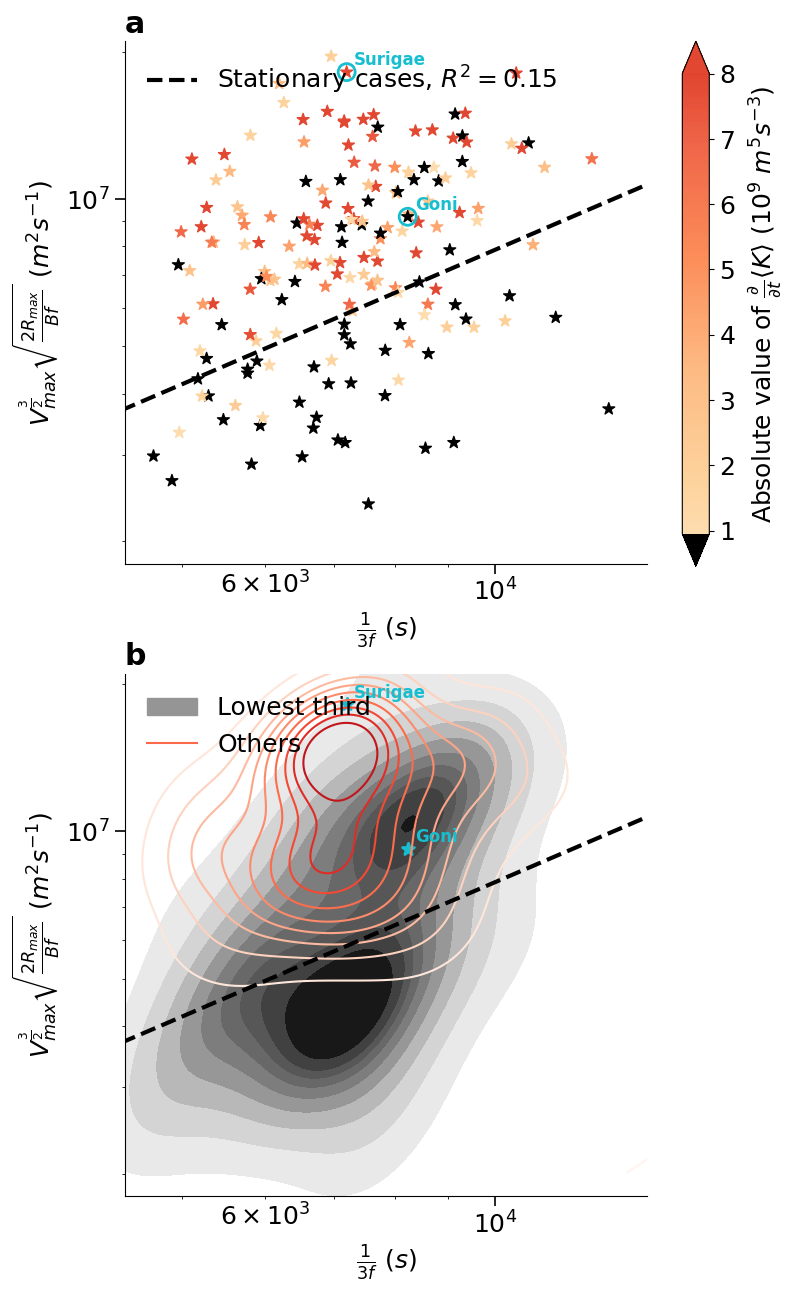

In [25]:
from matplotlib.gridspec import GridSpec
### FIGURE
fig        = plt.figure(figsize=(15, 15))
gs         = GridSpec(2, 1, hspace=0.21, wspace=0.1)

# Colorbar
c_min = abs(dsg.dKdt).quantile(0.33)
c_max = abs(dsg.dKdt).quantile(0.8)
cmap.set_under('k')
cmap.set_over(cmap(0.99))

#####################
### SCATTER PLOT  ###
#####################
ax = fig.add_subplot(gs[0, 0])
ax.set_title('a', weight='bold', loc='left')

# Plot
sm = ax.scatter(1 / (3 * abs(coriolis(dsg.lat_center))), (dsg.Vmax_1D ** 1.5) * np.sqrt(2 * dsg.Rmax_1D * 1000 / (1 * abs(coriolis(dsg.lat_center)))), marker='*', s=80, c=abs(dsg.dKdt), vmin=c_min, vmax=c_max, cmap=cmap)

# SAM
clr = 'tab:cyan'
std_case = goni
ax.scatter(1 / (3 * abs(coriolis(std_case.lat_center))), (std_case.Vmax_1D ** 1.5) * np.sqrt(2 * std_case.Rmax_1D * 1000 / (1 * abs(coriolis(std_case.lat_center)))), facecolors='none', edgecolors=clr, s=150, linewidth=2)
ax.annotate('Goni', (1 / (3 * abs(coriolis(std_case.lat_center))), (std_case.Vmax_1D ** 1.5) * np.sqrt(2 * std_case.Rmax_1D * 1000 / (1 * abs(coriolis(std_case.lat_center))))), fontsize=12, color=clr, weight='bold', xytext=(5, 5), textcoords='offset points')
# WUTIP
nsd_case = surigae
ax.scatter(1 / (3 * abs(coriolis(nsd_case.lat_center))), (nsd_case.Vmax_1D ** 1.5) * np.sqrt(2 * nsd_case.Rmax_1D * 1000 / (1 * abs(coriolis(nsd_case.lat_center)))), facecolors='none', edgecolors=clr, s=150, linewidth=2)
ax.annotate('Surigae', (1 / (3 * abs(coriolis(nsd_case.lat_center))), (nsd_case.Vmax_1D ** 1.5) * np.sqrt(2 * nsd_case.Rmax_1D * 1000 / (1 * abs(coriolis(nsd_case.lat_center))))), fontsize=12, color=clr, weight='bold', xytext=(5, 5), textcoords='offset points')

# Regression
from sklearn.linear_model import LinearRegression
d_std = dsg.where(abs(dsg.dKdt) < c_min, drop=True)
X     = np.expand_dims(1 / (3 * abs(coriolis(d_std.lat_center))), axis=1)
y     = (d_std.Vmax_1D ** 1.5) * np.sqrt(2 * d_std.Rmax_1D * 1000 / (1 * abs(coriolis(d_std.lat_center))))
reg   = LinearRegression().fit(np.log10(X), np.log10(y))
ax.plot(np.linspace(np.min(X) * 0.5, np.max(X) * 2, 100), 10 ** float(reg.intercept_) * np.power(np.linspace(np.min(X) * 0.5, np.max(X) * 2, 100), float(reg.coef_)), color='k', linestyle='--', label=r'Stationary cases, $R^2 = ${:.2f}'.format(reg.score(np.log10(X), np.log10(y))), linewidth=3)

# Grid, legend
ax.legend(loc='upper left', frameon=False)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1.8e6, 2.1e7)
ax.set_xlim(4.4e3, 1.4e4)
# ax.axvline(4.4e3);ax.axvline(1.4e4)
# ax.axhline(1.8e6);ax.axhline(2.1e7)
ax.set_ylabel(r'$V_{max}^{\frac{3}{2}} \sqrt{\frac{2 R_{max}}{Bf}}$ ($m^2 s^{-1}$)')
ax.set_xlabel(r'$\frac{1}{3 f}$ ($s$)')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
# Colorbar
cb_ax = fig.add_axes([0.71, 0.53, 0.018, 0.35])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(r'Absolute value of $\frac{\partial}{\partial t} \langle K \rangle $ ($10^{9}$ $m^5 s^{-3}$)', rotation=90)
cbar.ax.get_yaxis().labelpad=8

################
### DENSITIES###
################
ax = fig.add_subplot(gs[1, 0])
ax.set_title('b', weight='bold', loc='left')

# Colormap
greys             = cm.get_cmap('Greys', 256)
newcolors         = greys(np.linspace(0, 1, 256))
newcolors[:25, :] = mpl.colors.to_rgba('white')
newcmp            = mpl.colors.ListedColormap(newcolors)

# Plot
import seaborn as sns
d_std  = dsg.where(abs(dsg.dKdt) < c_min, drop=True) # steady
d_rst  = dsg.where(abs(dsg.dKdt) > c_min, drop=True) # unsteady
df_std = pd.DataFrame(data={'x': np.array(1 / (3 * abs(coriolis(d_std.lat_center)))).flatten(), 'y': np.array((d_std.Vmax_1D ** 1.5) * np.sqrt(2 * d_std.Rmax_1D * 1000 / (1 * abs(coriolis(d_std.lat_center))))).flatten(), 'w': np.array(abs(d_std.dKdt) / abs(d_std.dKdt).max(skipna=True)).flatten()})
df_rst = pd.DataFrame(data={'x': np.array(1 / (3 * abs(coriolis(d_rst.lat_center)))).flatten(), 'y': np.array((d_rst.Vmax_1D ** 1.5) * np.sqrt(2 * d_rst.Rmax_1D * 1000 / (1 * abs(coriolis(d_rst.lat_center))))).flatten(), 'w': np.array(abs(d_rst.dKdt) / abs(d_rst.dKdt).max(skipna=True)).flatten()})
sns.kdeplot(df_std,  x='x', y='y', weights='w', cmap=newcmp, fill=True, levels=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], ax=ax, log_scale=True, linewidth=0.0015625)
sns.kdeplot(df_rst,  x='x', y='y', weights='w', cmap=cm.get_cmap('Reds'), fill=False, levels=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], ax=ax, log_scale=True)

# Regression
ax.plot(np.linspace(np.min(X) * 0.5, np.max(X) * 2, 100), 10 ** float(reg.intercept_) * np.power(np.linspace(np.min(X) * 0.5, np.max(X) * 2, 100), float(reg.coef_)), color='k', linestyle='--', linewidth=3)

# Cases
ax.scatter(1 / (3 * abs(coriolis(std_case.lat_center))), (std_case.Vmax_1D ** 1.5) * np.sqrt(2 * std_case.Rmax_1D * 1000 / (1 * abs(coriolis(std_case.lat_center)))), facecolors=clr, edgecolors=clr, marker='*', s=80, linewidth=2)
ax.annotate('Goni', (1 / (3 * abs(coriolis(std_case.lat_center))), (std_case.Vmax_1D ** 1.5) * np.sqrt(2 * std_case.Rmax_1D * 1000 / (1 * abs(coriolis(std_case.lat_center))))), fontsize=12, color=clr, weight='bold', xytext=(5, 5), textcoords='offset points')
ax.scatter(1 / (3 * abs(coriolis(nsd_case.lat_center))), (nsd_case.Vmax_1D ** 1.5) * np.sqrt(2 * nsd_case.Rmax_1D * 1000 / (1 * abs(coriolis(nsd_case.lat_center)))), facecolors=clr, edgecolors=clr, marker='*', s=80, linewidth=2)
ax.annotate('Surigae', (1 / (3 * abs(coriolis(nsd_case.lat_center))), (nsd_case.Vmax_1D ** 1.5) * np.sqrt(2 * nsd_case.Rmax_1D * 1000 / (1 * abs(coriolis(nsd_case.lat_center))))), fontsize=12, color=clr, weight='bold', xytext=(5, 5), textcoords='offset points')

# Grid
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1.8e6, 2.1e7)
ax.set_xlim(4.4e3, 1.4e4)
ax.set_ylabel(r'$V_{max}^{\frac{3}{2}} \sqrt{\frac{2 R_{max}}{Bf}}$ ($m^2 s^{-1}$)')
ax.set_xlabel(r'$\frac{1}{3 f}$ ($s$)')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
# Legend
ax.fill_between([], [], [], label='Lowest third',   color=newcmp(0.5))
ax.plot([], [],             label='Others', color=cm.get_cmap('Reds')(0.5))
ax.legend(loc='upper left', frameon=False)

if PRMS['save_figs']:
    plt.savefig(PTHS['save_dir'] + 'stationary_crit_wdsb.pdf', bbox_inches='tight', format='pdf')
    # plt.savefig(PTHS['save_dir'] + 'stationary_crit_wdsb.pdf', bbox_inches='tight', format='pdf')

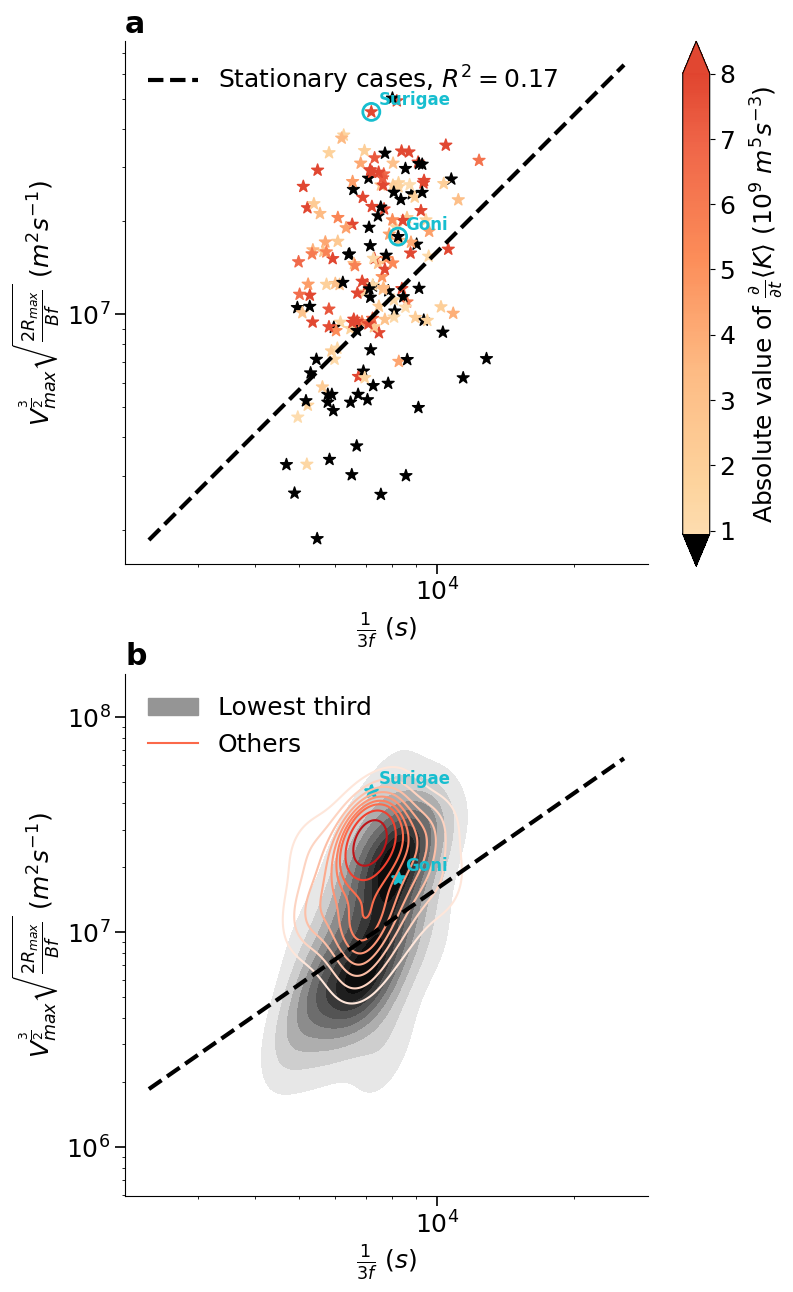

In [18]:
from matplotlib.gridspec import GridSpec
### FIGURE
fig        = plt.figure(figsize=(15, 15))
gs         = GridSpec(2, 1, hspace=0.21, wspace=0.1)

x = -2 * 1 # Power of B

# Colorbar
c_min = abs(dsg.dKdt).quantile(0.33)
c_max = abs(dsg.dKdt).quantile(0.8)
cmap.set_under('k')
cmap.set_over(cmap(0.99))

#####################
### SCATTER PLOT  ###
#####################
ax = fig.add_subplot(gs[0, 0])
ax.set_title('a', weight='bold', loc='left')

# Plot
sm = ax.scatter(1 / (3 * abs(coriolis(dsg.lat_center))), (dsg.Vmax_1D ** 1.5) * np.sqrt(2 * dsg.Rmax_1D * 1000 / (dsg.B_hol ** x * abs(coriolis(dsg.lat_center)))), marker='*', s=80, c=abs(dsg.dKdt), vmin=c_min, vmax=c_max, cmap=cmap)

# SAM
clr = 'tab:cyan'
std_case = goni
ax.scatter(1 / (3 * abs(coriolis(std_case.lat_center))), (std_case.Vmax_1D ** 1.5) * np.sqrt(2 * std_case.Rmax_1D * 1000 / (std_case.B_hol ** x * abs(coriolis(std_case.lat_center)))), facecolors='none', edgecolors=clr, s=150, linewidth=2)
ax.annotate('Goni', (1 / (3 * abs(coriolis(std_case.lat_center))), (std_case.Vmax_1D ** 1.5) * np.sqrt(2 * std_case.Rmax_1D * 1000 / (std_case.B_hol ** x * abs(coriolis(std_case.lat_center))))), fontsize=12, color=clr, weight='bold', xytext=(5, 5), textcoords='offset points')
# WUTIP
nsd_case = surigae
ax.scatter(1 / (3 * abs(coriolis(nsd_case.lat_center))), (nsd_case.Vmax_1D ** 1.5) * np.sqrt(2 * nsd_case.Rmax_1D * 1000 / (nsd_case.B_hol ** x * abs(coriolis(nsd_case.lat_center)))), facecolors='none', edgecolors=clr, s=150, linewidth=2)
ax.annotate('Surigae', (1 / (3 * abs(coriolis(nsd_case.lat_center))), (nsd_case.Vmax_1D ** 1.5) * np.sqrt(2 * nsd_case.Rmax_1D * 1000 / (nsd_case.B_hol ** x * abs(coriolis(nsd_case.lat_center))))), fontsize=12, color=clr, weight='bold', xytext=(5, 5), textcoords='offset points')

# Regression
from sklearn.linear_model import LinearRegression
d_std = dsg.where(abs(dsg.dKdt) < c_min, drop=True)
X     = np.expand_dims(1 / (3 * abs(coriolis(d_std.lat_center))), axis=1)
y     = (d_std.Vmax_1D ** 1.5) * np.sqrt(2 * d_std.Rmax_1D * 1000 / (d_std.B_hol ** x * abs(coriolis(d_std.lat_center))))
reg   = LinearRegression().fit(np.log10(X), np.log10(y))
ax.plot(np.linspace(np.min(X) * 0.5, np.max(X) * 2, 100), 10 ** float(reg.intercept_) * np.power(np.linspace(np.min(X) * 0.5, np.max(X) * 2, 100), float(reg.coef_)), color='k', linestyle='--', label=r'Stationary cases, $R^2 = ${:.2f}'.format(reg.score(np.log10(X), np.log10(y))), linewidth=3)

# Grid, legend
ax.legend(loc='upper left', frameon=False)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1.8e6, 2.1e7)
# ax.set_xlim(4.4e3, 1.4e4)
# ax.axvline(4.4e3);ax.axvline(1.4e4)
# ax.axhline(1.8e6);ax.axhline(2.1e7)
ax.set_ylabel(r'$V_{max}^{\frac{3}{2}} \sqrt{\frac{2 R_{max}}{Bf}}$ ($m^2 s^{-1}$)')
ax.set_xlabel(r'$\frac{1}{3 f}$ ($s$)')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
# Colorbar
cb_ax = fig.add_axes([0.71, 0.53, 0.018, 0.35])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(r'Absolute value of $\frac{\partial}{\partial t} \langle K \rangle $ ($10^{9}$ $m^5 s^{-3}$)', rotation=90)
cbar.ax.get_yaxis().labelpad=8

################
### DENSITIES###
################
ax = fig.add_subplot(gs[1, 0])
ax.set_title('b', weight='bold', loc='left')

# Colormap
greys             = cm.get_cmap('Greys', 256)
newcolors         = greys(np.linspace(0, 1, 256))
newcolors[:25, :] = mpl.colors.to_rgba('white')
newcmp            = mpl.colors.ListedColormap(newcolors)

# Plot
import seaborn as sns
d_std  = dsg.where(abs(dsg.dKdt) < c_min, drop=True) # steady
d_rst  = dsg.where(abs(dsg.dKdt) > c_min, drop=True) # unsteady
df_std = pd.DataFrame(data={'x': np.array(1 / (3 * abs(coriolis(d_std.lat_center)))).flatten(), 'y': np.array((d_std.Vmax_1D ** 1.5) * np.sqrt(2 * d_std.Rmax_1D * 1000 / (d_std.B_hol ** x * abs(coriolis(d_std.lat_center))))).flatten(), 'w': np.array(abs(d_std.dKdt) / abs(d_std.dKdt).max(skipna=True)).flatten()})
df_rst = pd.DataFrame(data={'x': np.array(1 / (3 * abs(coriolis(d_rst.lat_center)))).flatten(), 'y': np.array((d_rst.Vmax_1D ** 1.5) * np.sqrt(2 * d_rst.Rmax_1D * 1000 / (d_rst.B_hol ** x * abs(coriolis(d_rst.lat_center))))).flatten(), 'w': np.array(abs(d_rst.dKdt) / abs(d_rst.dKdt).max(skipna=True)).flatten()})
sns.kdeplot(df_std,  x='x', y='y', weights='w', cmap=newcmp, fill=True, levels=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], ax=ax, log_scale=True, linewidth=0.0015625)
sns.kdeplot(df_rst,  x='x', y='y', weights='w', cmap=cm.get_cmap('Reds'), fill=False, levels=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], ax=ax, log_scale=True)

# Regression
ax.plot(np.linspace(np.min(X) * 0.5, np.max(X) * 2, 100), 10 ** float(reg.intercept_) * np.power(np.linspace(np.min(X) * 0.5, np.max(X) * 2, 100), float(reg.coef_)), color='k', linestyle='--', linewidth=3)

# Cases
ax.scatter(1 / (3 * abs(coriolis(std_case.lat_center))), (std_case.Vmax_1D ** 1.5) * np.sqrt(2 * std_case.Rmax_1D * 1000 / (std_case.B_hol ** x * abs(coriolis(std_case.lat_center)))), facecolors=clr, edgecolors=clr, marker='*', s=80, linewidth=2)
ax.annotate('Goni', (1 / (3 * abs(coriolis(std_case.lat_center))), (std_case.Vmax_1D ** 1.5) * np.sqrt(2 * std_case.Rmax_1D * 1000 / (std_case.B_hol ** x * abs(coriolis(std_case.lat_center))))), fontsize=12, color=clr, weight='bold', xytext=(5, 5), textcoords='offset points')
ax.scatter(1 / (3 * abs(coriolis(nsd_case.lat_center))), (nsd_case.Vmax_1D ** 1.5) * np.sqrt(2 * nsd_case.Rmax_1D * 1000 / (nsd_case.B_hol ** x * abs(coriolis(nsd_case.lat_center)))), facecolors=clr, edgecolors=clr, marker='*', s=80, linewidth=2)
ax.annotate('Surigae', (1 / (3 * abs(coriolis(nsd_case.lat_center))), (nsd_case.Vmax_1D ** 1.5) * np.sqrt(2 * nsd_case.Rmax_1D * 1000 / (nsd_case.B_hol ** x * abs(coriolis(nsd_case.lat_center))))), fontsize=12, color=clr, weight='bold', xytext=(5, 5), textcoords='offset points')

# Grid
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1.8e6, 2.1e7)
# ax.set_xlim(4.4e3, 1.4e4)
ax.set_ylabel(r'$V_{max}^{\frac{3}{2}} \sqrt{\frac{2 R_{max}}{Bf}}$ ($m^2 s^{-1}$)')
ax.set_xlabel(r'$\frac{1}{3 f}$ ($s$)')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
# Legend
ax.fill_between([], [], [], label='Lowest third',   color=newcmp(0.5))
ax.plot([], [],             label='Others', color=cm.get_cmap('Reds')(0.5))
ax.legend(loc='upper left', frameon=False)

# plt.savefig(PTHS['save_dir'] + 'stationary_crit_final.pdf', bbox_inches='tight', format='pdf')

if PRMS['save_figs']:
    plt.savefig(PTHS['save_dir'] + 'stationary_crit_wdsb.pdf', bbox_inches='tight', format='pdf')
    # plt.savefig(PTHS['save_dir'] + 'stationary_crit_wdsb.pdf', bbox_inches='tight', format='pdf')

Text(0.5, 1.0, 'Rossby')

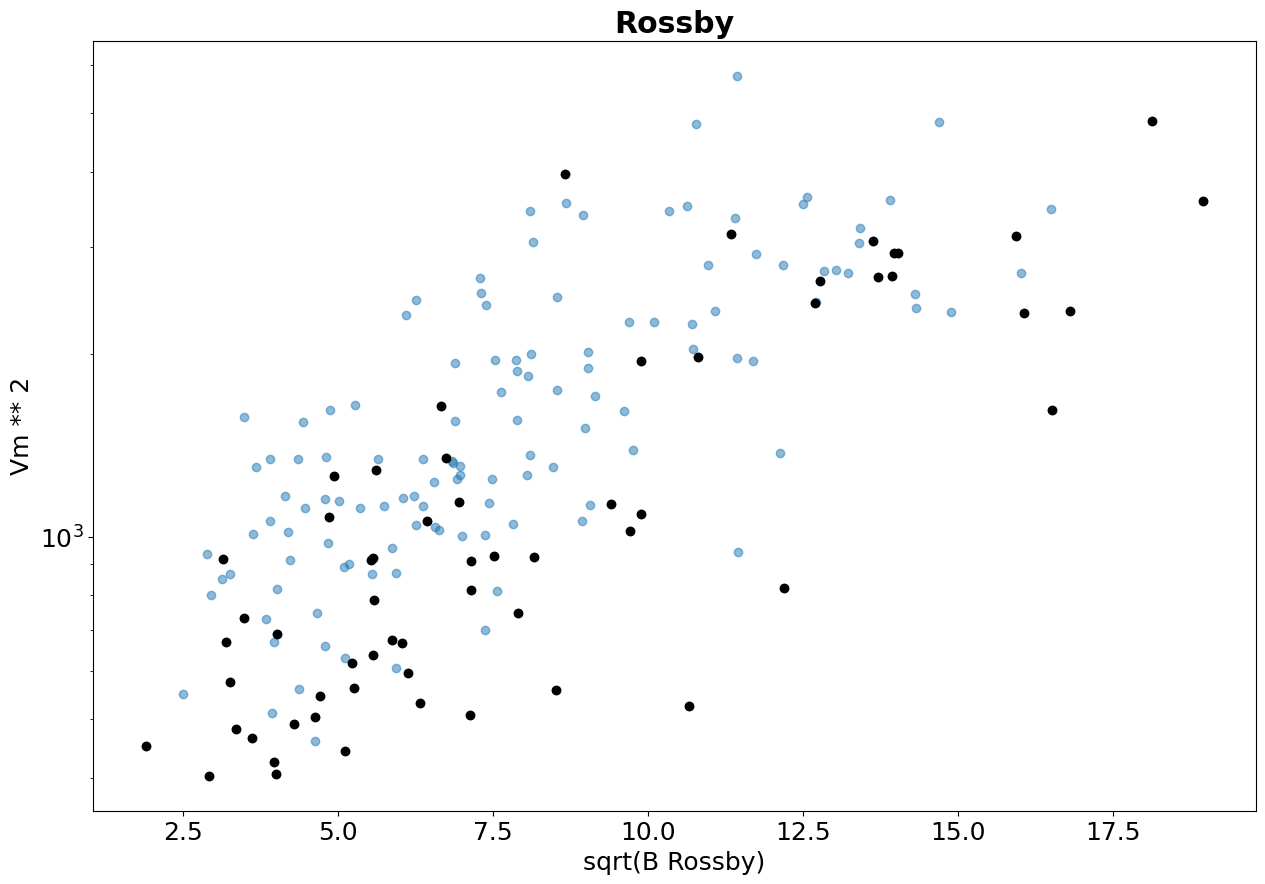

In [19]:
rossby = dsg.Vmax_1D / (abs(coriolis(dsg.lat_center)) * dsg.Rmax_1D * 1000)
plt.scatter(np.sqrt(dsg.B_hol * rossby), dsg.Vmax_1D ** 2, c='tab:blue', alpha=0.5)
rossby_std = d_std.Vmax_1D / (abs(coriolis(d_std.lat_center)) * d_std.Rmax_1D * 1000)
plt.scatter(np.sqrt(d_std.B_hol * rossby), d_std.Vmax_1D ** 2, c='k')
plt.xlabel('sqrt(B Rossby)')
plt.ylabel('Vm ** 2')
plt.yscale('log')
plt.title('Rossby', weight='bold')
# plt.xlim(0.9, 2.6)

(0.9, 2.6)

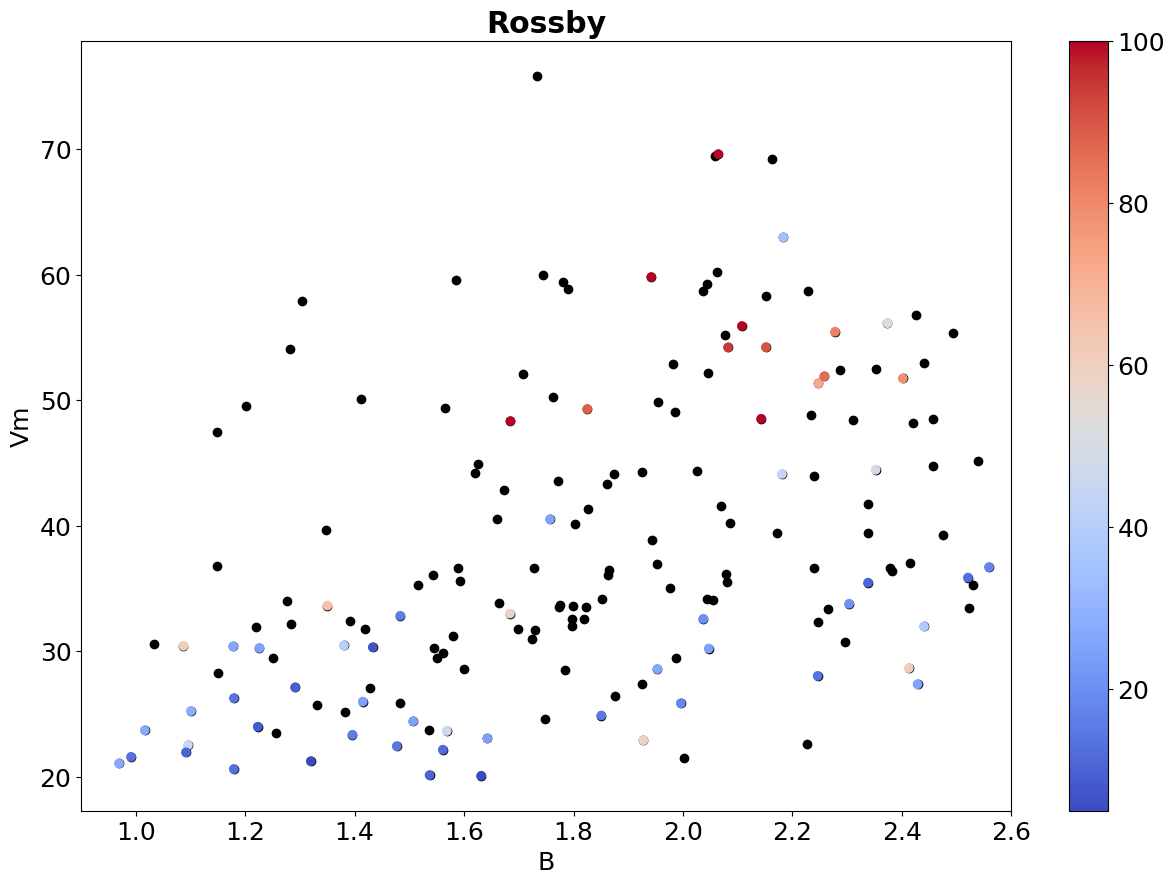

In [20]:
rossby = d_std.Vmax_1D / (abs(coriolis(d_std.lat_center)) * d_std.Rmax_1D * 1000)
plt.scatter(dsg.B_hol,   dsg.Vmax_1D,   c='k')
plt.scatter(d_std.B_hol, d_std.Vmax_1D, c=rossby, cmap=cm.get_cmap('coolwarm'), vmin=5, vmax=100)
plt.colorbar()
plt.xlabel('B')
plt.ylabel('Vm')
plt.title('Rossby', weight='bold')
plt.xlim(0.9, 2.6)

(0.9, 2.6)

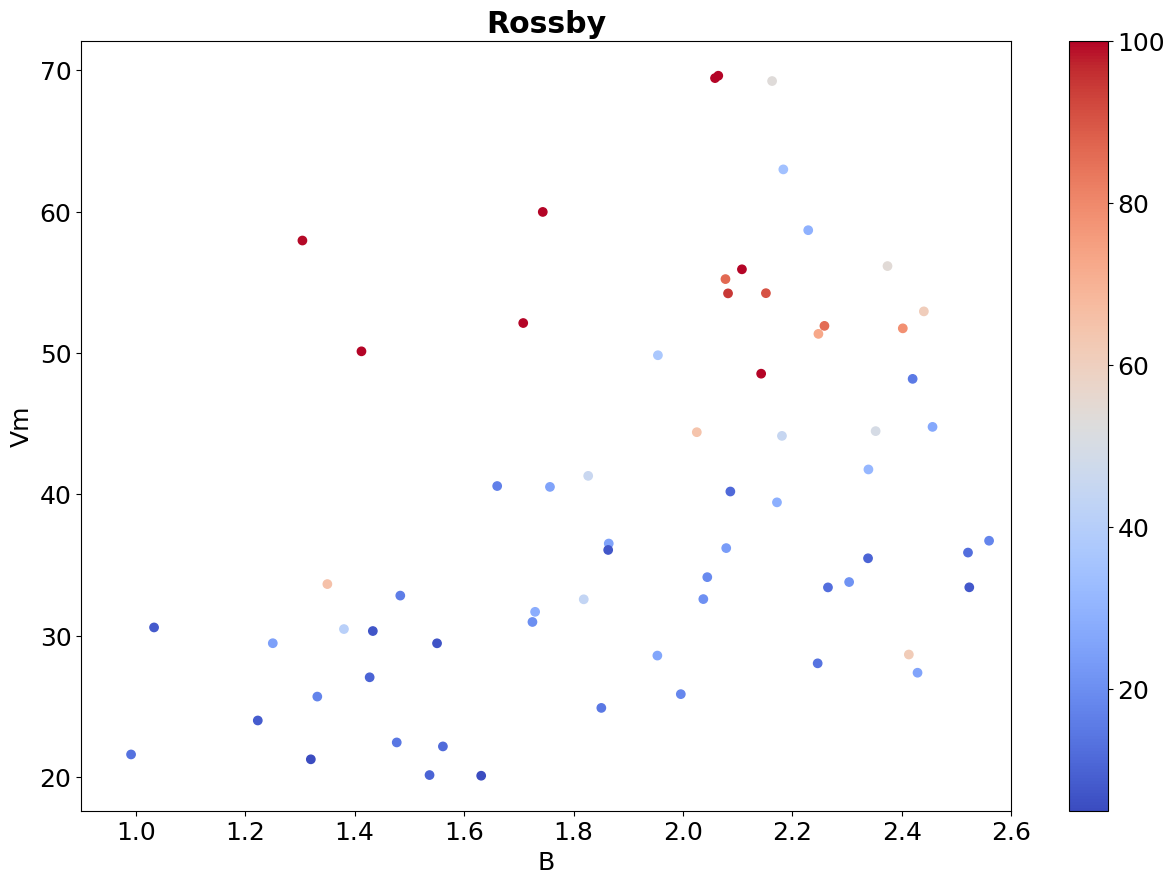

In [21]:
d      = dsg.where(abs(dsg.Vmax_dot_smth_IBT) < 0.3, drop=True)
# d      = dsg.copy(deep=True)
rossby = d.Vmax_1D / (abs(coriolis(d.lat_center)) * d.Rmax_1D * 1000)
plt.scatter(d.B_hol, d.Vmax_1D, c=rossby, cmap=cm.get_cmap('coolwarm'), vmin=5, vmax=100)
plt.colorbar()
plt.xlabel('B')
plt.ylabel('Vm')
plt.title('Rossby', weight='bold')
plt.xlim(0.9, 2.6)

In [22]:
# a = d_std.where((d_std.X < 8e3) & (d_std.X > 6e3) & (d_std.y > 2.7e6) & (d_std.y < 4e6), drop=True)
# b = d_std.where((d_std.X < 9e3) & (d_std.X > 8e3) & (d_std.y > 6e6) & (d_std.y < 8e6), drop=True)

# # Copy-paste that on above plot
# # ax.scatter(a.X, a.y, s=150, c='tab:orange')
# # ax.scatter(b.X, b.y, s=150, c='tab:green')

# print('Bottom (orange) \n')
# for t in range(len(a.time)):
#     print('Vmax = {:.0f} m/s, Rmax = {:.0f} km, {}, {}'.format(a.isel(time=t).Vmax_1D, a.isel(time=t).Rmax_1D, a.isel(time=t).storm_id.item(), a.isel(time=t).storm_name.item().item()))
    
# print('\nTop (green) \n')
# for t in range(len(b.time)):
#     print('Vmax = {:.0f} m/s, Rmax = {:.0f} km, {}, {}'.format(b.isel(time=t).Vmax_1D, b.isel(time=t).Rmax_1D, b.isel(time=t).storm_id.item(), b.isel(time=t).storm_name.item().item()))

#### Find specific cases

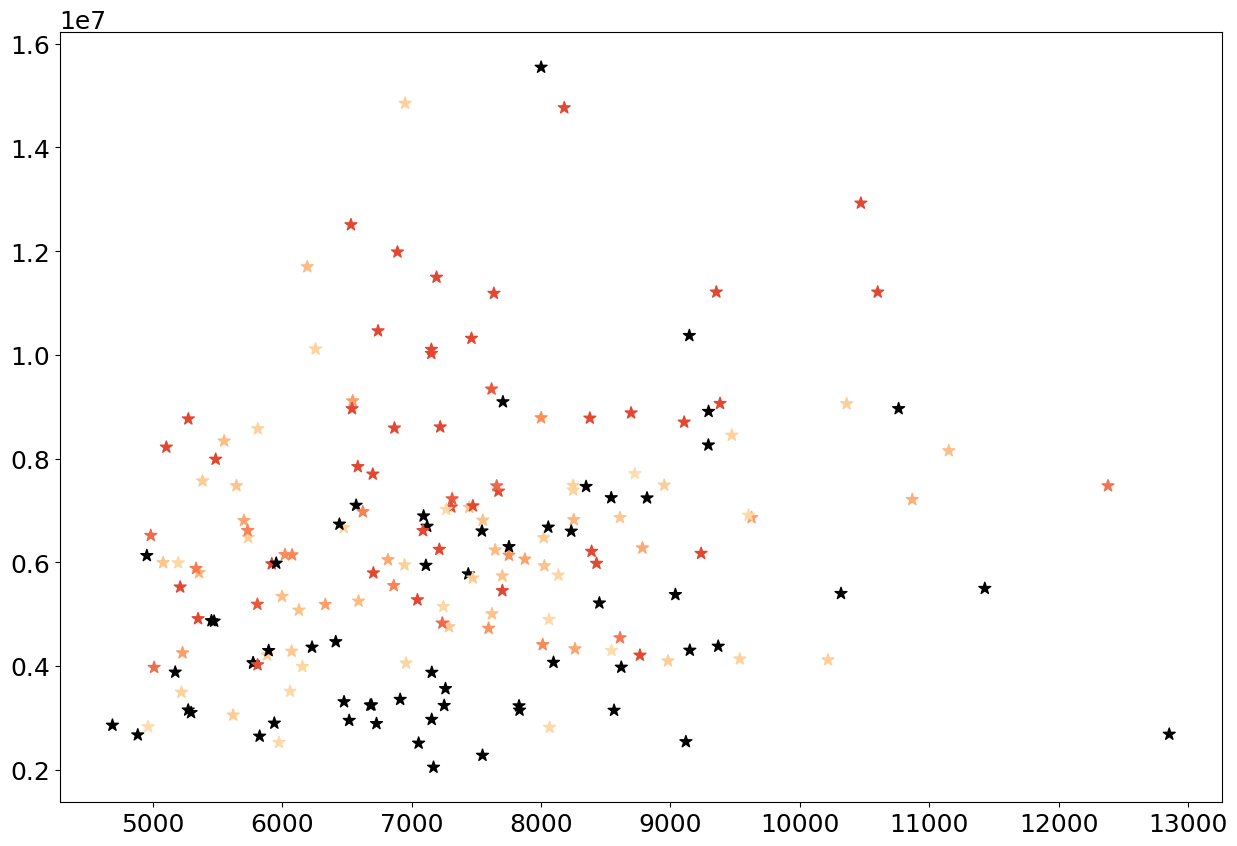

In [23]:
dsg['X'] = 1 / (3 * abs(coriolis(dsg.lat_center)))
dsg['y'] = (dsg.Vmax_1D ** 1.5) * np.sqrt(2 * dsg.Rmax_1D * 1000 / (dsg.B_hol * abs(coriolis(dsg.lat_center))))

dsg['basin'] = (['time'] , np.array([None for i in range(len(dsg.time))]))
for t in range(len(dsg.time)):
    dsg['basin'][t] = dsg.isel(time=t).storm_id.item().item()[:2]
    
# Atlantic
da = dsg.where(dsg.basin == 'al', drop=True)
dw = dsg.where(dsg.basin == 'wp', drop=True) # West Pacific only

plt.scatter(dsg.X, dsg.y, marker='*', s=80, c=abs(dsg.dKdt), vmin=c_min, vmax=c_max, cmap=cmap)

(array([ 2.,  0.,  1.,  2.,  2.,  2.,  3.,  1.,  5.,  9.,  5., 12., 13.,
        17., 21., 15., 18.,  9., 11., 10.,  9.,  6.,  4.,  4.,  0.,  0.,
         0.,  2.,  0.,  1.]),
 array([3.95278644e-13, 5.84041434e-01, 1.16808287e+00, 1.75212430e+00,
        2.33616574e+00, 2.92020717e+00, 3.50424861e+00, 4.08829004e+00,
        4.67233148e+00, 5.25637291e+00, 5.84041434e+00, 6.42445578e+00,
        7.00849721e+00, 7.59253865e+00, 8.17658008e+00, 8.76062152e+00,
        9.34466295e+00, 9.92870439e+00, 1.05127458e+01, 1.10967873e+01,
        1.16808287e+01, 1.22648701e+01, 1.28489116e+01, 1.34329530e+01,
        1.40169944e+01, 1.46010359e+01, 1.51850773e+01, 1.57691187e+01,
        1.63531602e+01, 1.69372016e+01, 1.75212430e+01]),
 <BarContainer object of 30 artists>)

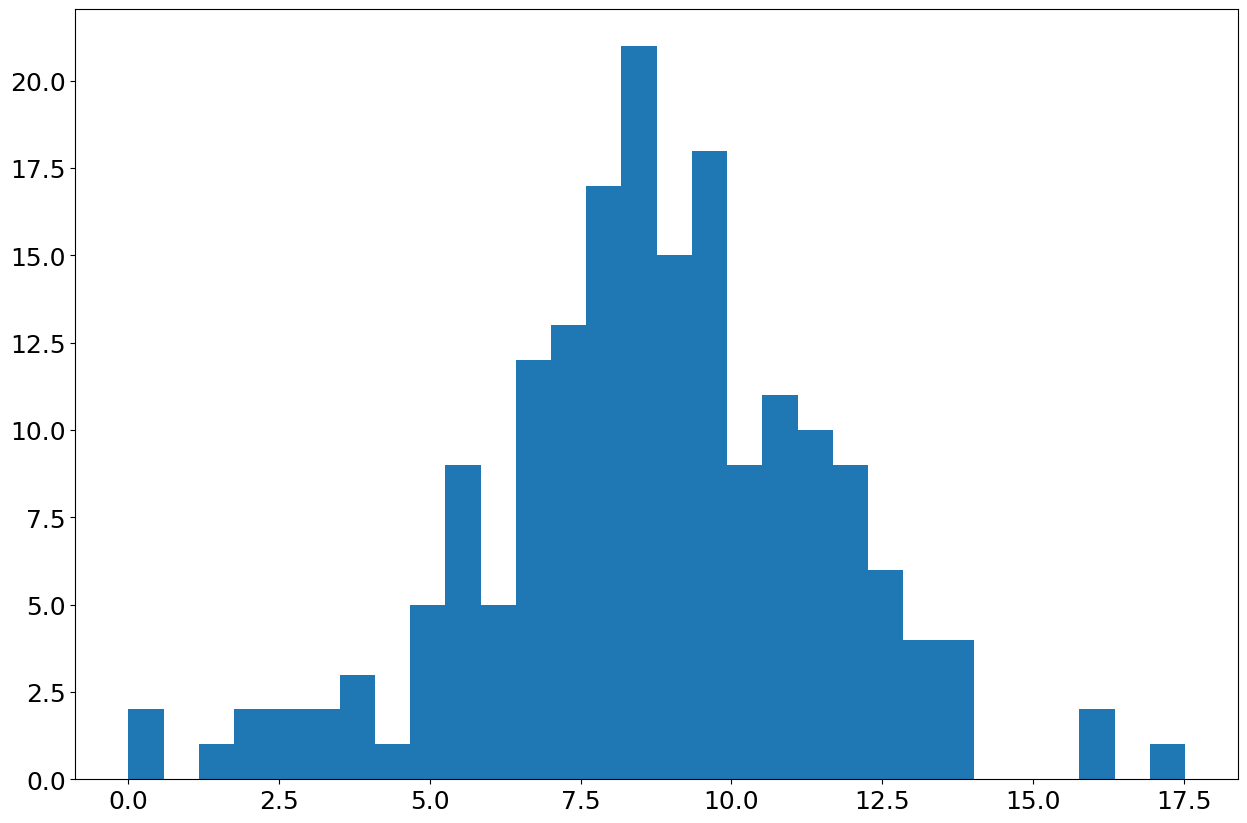

In [24]:
plt.hist(dsg.Vmin_hol, bins=30)

In [25]:
goni.Vmax_1D

<xarray.DataArray 'Vmax_1D' ()>
array(59.82083293)
Coordinates:
    time     datetime64[ns] 2020-10-30T09:26:25

In [ ]:
### UNSTEADY
# Upper-left quadrant
ufs = [
    'rs2--owi-cm-20160912t212718-20160912t213122-00003-BDC5F_sw.nc', # Meranti 2016
]

for f in ufs:
    d = dsg.where(dsg.sat_file == f, drop=True).isel(time=0)
    print('Vmax = {:.0f} m/s, B = {:.1f}, Rmax = {:.0f} km, Vmin_hol = {:.1f} m/s'.format(d.Vmax_1D, d.B_hol, d.Rmax_1D, d.Vmin_hol))

In [ ]:
### UNSTEADY
# s1a-ew-owi-cm-20160827t205158-20160827t205454-000003-014285_sw.nc # Lionrock
# rs2--owi-cm-20160912t212718-20160912t213122-00003-BDC5F_sw.nc # Meranti
# s1b-ew-owi-cm-20181027t210308-20181027t210442-000003-018AC3_sw.nc # Yutu

# 58 m/s
# rs2--owi-cm-20160912t212718-20160912t213122-00003-BDC5F_sw.nc

d = dsg.copy(deep=True)

print('Vmax')
print(d.where((d.X < 7500) & (d.y > 0.8e7), drop=True).Vmax_1D)
print('\nB')
print(d.where((d.X < 7500) & (d.y > 0.8e7), drop=True).B_hol)
print('\nRmax')
print(d.where((d.X < 7500) & (d.y > 0.8e7), drop=True).Rmax_1D)
print('\nVmin_hol')
print(d.where((d.X < 7500) & (d.y > 0.8e7), drop=True).Vmin_hol)
print('\nfile')
print(d.where((d.X < 7500) & (d.y > 0.8e7), drop=True).sat_file)

In [ ]:
### STEADY
# Lower-right quadrant
sfs = [
    's1a-ew-owi-cm-20180807t154302-20180807t154506-000003-028386_sw.nc', # Hector 2018
    'rs2--owi-cm-20141103t131130-20141103t131246-00003-E41DD_sw.nc',     # Vance 2014
    'rs2--owi-cm-20210717t022156-20210717t022312-00003-2185F_sw.nc',     # Felicia 2021
    's1a-ew-owi-cm-20201029t205631-20201029t205758-000003-0415BC_sw.nc', # Goni 2020
    's1b-ew-owi-cm-20210926t090903-20210926t091107-000003-0371EC_sw.nc', # Sam 2021
    'rs2--owi-cm-20180807t154512-20180807t154628-00003-07134_sw.nc',     # Hector 2018
    's1a-ew-owi-cm-20180808t041303-20180808t041507-000003-0283BF_sw.nc', # Hector
    'rs2--owi-cm-20210718t142039-20210718t142154-00003-21860_sw.nc',     # Felicia
    's1a-iw-owi-cm-20180823t043704-20180823t043913-000003-028AD1_sw.nc', # Lane
]

for f in sfs:
    d = dsg.where(dsg.sat_file == f, drop=True).isel(time=0)
    print('Vmax = {:.0f} m/s, B = {:.1f}, Rmax = {:.0f} km, Vmin_hol = {:.1f} m/s'.format(d.Vmax_1D, d.B_hol, d.Rmax_1D, d.Vmin_hol))

In [ ]:
### STEADY
d = dsg.where(dsg.Vmin_hol < 8, drop=True).copy(deep=True)

print('Vmax')
print(d.where((d.X > 8000) & (d.y < 0.8e7), drop=True).Vmax_1D)
print('\nB')
print(d.where((d.X > 8000) & (d.y < 0.8e7), drop=True).B_hol)
print('\nRmax')
print(d.where((d.X > 8000) & (d.y < 0.8e7), drop=True).Rmax_1D)
print('\nVmin_hol')
print(d.where((d.X > 8000) & (d.y < 0.8e7), drop=True).Vmin_hol)
print('\nfile')
print(d.where((d.X > 8000) & (d.y < 0.8e7), drop=True).sat_file)

In [ ]:
print(d.where((d.X > 8000) & (d.y < 0.8e7), drop=True).isel(time=29).Vmin_hol)

In [ ]:
print(d.where((d.X > 8000) & (d.y < 0.8e7), drop=True).isel(time=29).sat_file)

In [ ]:
# d = dsg.where(dsg.basin != 'wp', drop=True).copy(deep=True)

# print('Vmax')
# print(d.where((d.X < 7500) & (d.y > 0.8e7), drop=True).Vmax_1D)
# print('\nB')
# print(d.where((d.X < 7500) & (d.y > 0.8e7), drop=True).B_hol)
# print('\nRmax')
# print(d.where((d.X < 7500) & (d.y > 0.8e7), drop=True).Rmax_1D)
# print('\nVmin_hol')
# print(d.where((d.X < 7500) & (d.y > 0.8e7), drop=True).Vmin_hol)
# print('\nfile')
# print(d.where((d.X < 7500) & (d.y > 0.8e7), drop=True).sat_file)

In [ ]:
# Steady cases:
# Jebi: s1b-ew-owi-cm-20180829t075408-20180829t075612-000003-017011_sw.nc
# Goni: s1a-ew-owi-cm-20201030t092540-20201030t092711-000003-0415F8_sw.nc

In [ ]:
print('Goni B = {:0f}'.format(goni.B_hol))
print('Goni Vm = {:0f}'.format(goni.Vmax_1D))
print('Goni Rm = {:0f}'.format(goni.Rmax_1D))
print('Goni Lat = {:0f}'.format(goni.lat_center))

In [ ]:
dw.where((abs(dw.dKdt) < c_min), drop=True).B_hol

In [ ]:

plt.scatter(1 / (3 * abs(coriolis(da.lat_center))), (da.Vmax_1D ** 1.5) * np.sqrt(2 * da.Rmax_1D * 1000 / (da.B_hol * abs(coriolis(da.lat_center)))), marker='*', s=80, c=abs(da.dKdt), vmin=c_min, vmax=c_max, cmap=cmap)

In [ ]:
dsg['X'] = 1 / (3 * abs(coriolis(dsg.lat_center)))
dsg['y'] = (dsg.Vmax_1D ** 1.5) * np.sqrt(2 * dsg.Rmax_1D * 1000 / (dsg.B_hol * abs(coriolis(dsg.lat_center))))
dsg.where((dsg.X < 6000) & (dsg.y > 0.8e7), drop=True).Vmax_1D

In [ ]:
da.where((da.X < 6000) & (da.y < 0.5e7), drop=True).Vmax_1D

In [ ]:
from matplotlib.gridspec import GridSpec
### FIGURE
fig        = plt.figure(figsize=(15, 15))
gs         = GridSpec(2, 1, hspace=0.21, wspace=0.1)

# Colorbar
# c_min = 0.05
# c_max = 0.3
c_min = abs(dsg.dKdt).quantile(0.35)
c_max = abs(dsg.dKdt).quantile(0.8)
cmap.set_under('k')
cmap.set_over(cmap(0.99))

#####################
### SCATTER PLOT  ###
#####################
ax = fig.add_subplot(gs[0, 0])
ax.set_title('a', weight='bold', loc='left')

# Plot
sm = ax.scatter(dsg.B_hol / (abs(coriolis(dsg.lat_center)) * dsg.Rmax_1D * 1000), dsg.Vmax_1D ** 3, marker='*', s=80, c=abs(dsg.dKdt), vmin=c_min, vmax=c_max, cmap=cmap)
# SAM
clr = 'tab:cyan'
ax.scatter(sam.B_hol / (abs(coriolis(sam.lat_center)) * sam.Rmax_1D * 1000), sam.Vmax_1D ** 3, facecolors='none', edgecolors=clr, s=150, linewidth=2)
ax.annotate('Sam', (sam.B_hol / (abs(coriolis(sam.lat_center)) * sam.Rmax_1D * 1000), sam.Vmax_1D ** 3), fontsize=12, color=clr, weight='bold', xytext=(5, 5), textcoords='offset points')
# WUTIP
ax.scatter(wutip.B_hol / (abs(coriolis(wutip.lat_center)) * wutip.Rmax_1D * 1000), wutip.Vmax_1D ** 3, facecolors='none', edgecolors=clr, s=150, linewidth=2)
ax.annotate('Wutip', (wutip.B_hol / (abs(coriolis(wutip.lat_center)) * wutip.Rmax_1D * 1000), wutip.Vmax_1D ** 3), fontsize=12, color=clr, weight='bold', xytext=(5, 5), textcoords='offset points')
# # SERGIO
# ax.scatter(sergio.B_hol / (abs(coriolis(sergio.lat_center)) * sergio.Rmax_1D * 1000), sergio.Vmax_1D ** 3, facecolors='none', edgecolors=clr, s=150, linewidth=2)
# ax.annotate('Sergio', (sergio.B_hol / (abs(coriolis(sergio.lat_center)) * sergio.Rmax_1D * 1000), sergio.Vmax_1D ** 3), fontsize=12, color=clr, weight='bold', xytext=(5, 5), textcoords='offset points')
# ANDRES
# ax.scatter(andres.B_hol / (abs(coriolis(andres.lat_center)) * andres.Rmax_1D * 1000), andres.Vmax_1D ** 3, facecolors='none', edgecolors=clr, s=150, linewidth=2)
# ax.annotate('Andres', (andres.B_hol / (abs(coriolis(andres.lat_center)) * andres.Rmax_1D * 1000), wutip.Vmax_1D ** 3), fontsize=12, color=clr, weight='bold', xytext=(5, 5), textcoords='offset points')

# Regression
from sklearn.linear_model import LinearRegression
d_std = dsg.where(abs(dsg.dKdt) < c_min, drop=True)
X     = np.expand_dims(d_std.B_hol / (abs(coriolis(d_std.lat_center)) * d_std.Rmax_1D * 1000), axis=1)
y     = d_std.Vmax_1D ** 3
reg   = LinearRegression().fit(np.log10(X), np.log10(y))
ax.plot(np.linspace(0.1, 10, 100), 10 ** float(reg.intercept_) * np.power(np.linspace(0.1, 10, 100), float(reg.coef_)), color='k', linestyle='--', label=r'Stationary cases, $R^2 = ${:.2f}'.format(reg.score(np.log10(X), np.log10(y))), linewidth=3)

# Grid, legend
ax.legend(loc='upper left', frameon=False)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(4e3, 1e6)
ax.set_xlim(2e-1, 10)
ax.set_ylabel(r'$V_{max}^3$ ($m^3 s^{-3}$)')
ax.set_xlabel(r'$\frac{B}{f R_{max}}$ ($m^{-3} s^3$)')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
# Colorbar
cb_ax = fig.add_axes([0.71, 0.53, 0.018, 0.35])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(r'Absolute value of $\frac{\partial}{\partial t} \langle K \rangle $ ($10^{8}$ $m^4 s^{-3}$)', rotation=90)
cbar.ax.get_yaxis().labelpad=8

################
### DENSITIES###
################
ax = fig.add_subplot(gs[1, 0])
ax.set_title('b', weight='bold', loc='left')

# Colormap
greys             = cm.get_cmap('Greys', 256)
newcolors         = greys(np.linspace(0, 1, 256))
newcolors[:25, :] = mpl.colors.to_rgba('white')
newcmp            = mpl.colors.ListedColormap(newcolors)

# Plot
ax.plot(np.linspace(0.1, 10, 100), 10 ** float(reg.intercept_) * np.power(np.linspace(0.1, 10, 100), float(reg.coef_)), color='k', linestyle='--', label=r'Stationary cases, $R^2 = ${:.2f}'.format(reg.score(np.log10(X), np.log10(y))), linewidth=3)
import seaborn as sns
d_std  = dsg.where(abs(dsg.dKdt) < c_min, drop=True) # steady
d_rst  = dsg.where(abs(dsg.dKdt) > c_min, drop=True) # unsteady
df_std = pd.DataFrame(data={'x': np.array(d_std.B_hol / (abs(coriolis(d_std.lat_center)) * d_std.Rmax_1D * 1000)).flatten(), 'y': np.array(d_std.Vmax_1D ** 3).flatten(), 'w': np.array(abs(d_std.dKdt) / abs(d_std.dKdt).max(skipna=True)).flatten()})
df_rst = pd.DataFrame(data={'x': np.array(d_rst.B_hol / (abs(coriolis(d_rst.lat_center)) * d_rst.Rmax_1D * 1000)).flatten(), 'y': np.array(d_rst.Vmax_1D ** 3).flatten(), 'w': np.array(abs(d_rst.dKdt) / abs(d_rst.dKdt).max(skipna=True)).flatten()})
sns.kdeplot(df_std,  x='x', y='y', weights='w', cmap=newcmp, fill=True, levels=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], ax=ax, log_scale=True, linewidth=0.0015625)
sns.kdeplot(df_rst,  x='x', y='y', weights='w', cmap=cm.get_cmap('Reds'), fill=False, levels=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], ax=ax, log_scale=True)
# sns.kdeplot(df_std,  x='x', y='y', cmap=newcmp, fill=True, levels=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], ax=ax, log_scale=True, linewidth=0.0015625, cbar=True)
# sns.kdeplot(df_rst,  x='x', y='y', cmap=cm.get_cmap('Reds'), fill=False, levels=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], ax=ax, log_scale=True, cbar=True)

# Cases
ax.scatter(sam.B_hol / (abs(coriolis(sam.lat_center)) * sam.Rmax_1D * 1000), sam.Vmax_1D ** 3, facecolors=clr, edgecolors=clr, marker='*', s=80, linewidth=2)
ax.annotate('Sam', (sam.B_hol / (abs(coriolis(sam.lat_center)) * sam.Rmax_1D * 1000), sam.Vmax_1D ** 3), fontsize=12, color=clr, weight='bold', xytext=(5, 5), textcoords='offset points')
ax.scatter(wutip.B_hol / (abs(coriolis(wutip.lat_center)) * wutip.Rmax_1D * 1000), wutip.Vmax_1D ** 3, facecolors=clr, edgecolors=clr, marker='*', s=80, linewidth=2)
ax.annotate('Wutip', (wutip.B_hol / (abs(coriolis(wutip.lat_center)) * wutip.Rmax_1D * 1000), wutip.Vmax_1D ** 3), fontsize=12, color=clr, weight='bold', xytext=(5, 5), textcoords='offset points')
# ax.scatter(sergio.B_hol / (abs(coriolis(sergio.lat_center)) * sergio.Rmax_1D * 1000), sergio.Vmax_1D ** 3, facecolors='none', edgecolors=clr, s=150, linewidth=2)
# ax.annotate('Sergio', (sergio.B_hol / (abs(coriolis(sergio.lat_center)) * sergio.Rmax_1D * 1000), sergio.Vmax_1D ** 3), fontsize=12, color=clr, weight='bold', xytext=(5, 5), textcoords='offset points')
# ax.scatter(andres.B_hol / (abs(coriolis(andres.lat_center)) * andres.Rmax_1D * 1000), andres.Vmax_1D ** 3, facecolors='none', edgecolors=clr, s=150, linewidth=2)
# ax.annotate('Andres', (andres.B_hol / (abs(coriolis(andres.lat_center)) * andres.Rmax_1D * 1000), wutip.Vmax_1D ** 3), fontsize=12, color=clr, weight='bold', xytext=(5, 5), textcoords='offset points')

# Grid
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(4e3, 1e6)
ax.set_xlim(2e-1, 10)
ax.set_ylabel(r'$V_{max}^3$ ($m^3 s^{-3}$)')
ax.set_xlabel(r'$\frac{B}{f R_{max}}$ ($m^{-3} s^3$)')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
# Legend
ax.plot([], [],             label='Unsteady', color=cm.get_cmap('Reds')(0.5))
ax.fill_between([], [], [], label='Steady',   color=newcmp(0.5))
ax.legend(loc='upper left', frameon=False)

if PRMS['save_figs']:
    plt.savefig(PTHS['save_dir'] + 'stationary_crit_wdsb.pdf', bbox_inches='tight', format='pdf')
    # plt.savefig(PTHS['save_dir'] + 'stationary_crit_wdsb.pdf', bbox_inches='tight', format='pdf')

In [ ]:
### FIGURE
fig = plt.figure(figsize=(15, 15))
gs  = GridSpec(2, 1, hspace=0.21, wspace=0.1)

d_low = dsg.where(abs(dsg.dKdt) < abs(dsg.dKdt).quantile(0.33), drop=True)
d_mid = dsg.where((abs(dsg.dKdt) >= abs(dsg.dKdt).quantile(0.33)) & (abs(dsg.dKdt) < abs(dsg.dKdt).quantile(0.66)), drop=True)
d_hgh = dsg.where((abs(dsg.dKdt) >= abs(dsg.dKdt).quantile(0.66)), drop=True)

# Colorbar
cmap     = cm.get_cmap('OrRd')

#####################
### SCATTER PLOT  ###
#####################
ax = fig.add_subplot(gs[0, 0])

# Plot
ax.scatter(1 / (3 * abs(coriolis(d_low.lat_center))), (d_low.Vmax_1D ** 1.5) * np.sqrt(2 * d_low.Rmax_1D * 1000 / (d_low.B_hol * abs(coriolis(d_low.lat_center)))), marker='*', s=80, color=cmap(0.2))
ax.scatter(1 / (3 * abs(coriolis(d_mid.lat_center))), (d_mid.Vmax_1D ** 1.5) * np.sqrt(2 * d_mid.Rmax_1D * 1000 / (d_mid.B_hol * abs(coriolis(d_mid.lat_center)))), marker='*', s=80, color=cmap(0.5))
ax.scatter(1 / (3 * abs(coriolis(d_hgh.lat_center))), (d_hgh.Vmax_1D ** 1.5) * np.sqrt(2 * d_hgh.Rmax_1D * 1000 / (d_hgh.B_hol * abs(coriolis(d_hgh.lat_center)))), marker='*', s=80, color=cmap(0.9))

# # Regressions
from sklearn.linear_model import LinearRegression
for d, c in zip([d_low, d_mid, d_hgh], [cmap(0.2), cmap(0.5), cmap(0.9)]):
    X     = np.expand_dims(1 / (3 * abs(coriolis(d.lat_center))), axis=1)
    y     = (d.Vmax_1D ** 1.5) * np.sqrt(2 * d.Rmax_1D * 1000 / (d.B_hol * abs(coriolis(d.lat_center))))
    reg   = LinearRegression().fit(np.log10(X), np.log10(y))
    ax.plot(np.linspace(np.min(X) * 0.5, np.max(X) * 2, 100), 10 ** float(reg.intercept_) * np.power(np.linspace(np.min(X) * 0.5, np.max(X) * 2, 100), float(reg.coef_)), color=c, linestyle='--', label=r'$R^2 = ${:.2f}'.format(reg.score(np.log10(X), np.log10(y))), linewidth=2)

# Grid, legend
ax.legend(loc='upper left', frameon=False)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1.8e6, 2.1e7)
ax.set_xlim(4.4e3, 1.4e4)
ax.set_ylabel(r'$V_{max}^{\frac{3}{2}} \sqrt{\frac{2 R_{max}}{Bf}}$')
ax.set_xlabel(r'$\frac{1}{3 f}$')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)

In [ ]:
### FIGURE
fig = plt.figure(figsize=(15, 15))
gs  = GridSpec(2, 1, hspace=0.21, wspace=0.1)

d_low = dsg.where(abs(dsg.dKdt) < abs(dsg.dKdt).quantile(0.25), drop=True)
d_mi1 = dsg.where((abs(dsg.dKdt) >= abs(dsg.dKdt).quantile(0.25)) & (abs(dsg.dKdt) < abs(dsg.dKdt).quantile(0.5)), drop=True)
d_mi2 = dsg.where((abs(dsg.dKdt) >= abs(dsg.dKdt).quantile(0.5)) & (abs(dsg.dKdt) < abs(dsg.dKdt).quantile(0.75)), drop=True)
d_hgh = dsg.where((abs(dsg.dKdt) >= abs(dsg.dKdt).quantile(0.75)), drop=True)

# Colorbar
cmap     = cm.get_cmap('OrRd')

#####################
### SCATTER PLOT  ###
#####################
ax = fig.add_subplot(gs[0, 0])

# Plot
ax.scatter(1 / (3 * abs(coriolis(d_low.lat_center))), (d_low.Vmax_1D ** 1.5) * np.sqrt(2 * d_low.Rmax_1D * 1000 / (d_low.B_hol * abs(coriolis(d_low.lat_center)))), marker='*', s=80, color=cmap(0.2))
ax.scatter(1 / (3 * abs(coriolis(d_mi1.lat_center))), (d_mi1.Vmax_1D ** 1.5) * np.sqrt(2 * d_mi1.Rmax_1D * 1000 / (d_mi1.B_hol * abs(coriolis(d_mi1.lat_center)))), marker='*', s=80, color=cmap(0.4))
ax.scatter(1 / (3 * abs(coriolis(d_mi2.lat_center))), (d_mi2.Vmax_1D ** 1.5) * np.sqrt(2 * d_mi2.Rmax_1D * 1000 / (d_mi2.B_hol * abs(coriolis(d_mi2.lat_center)))), marker='*', s=80, color=cmap(0.6))
ax.scatter(1 / (3 * abs(coriolis(d_hgh.lat_center))), (d_hgh.Vmax_1D ** 1.5) * np.sqrt(2 * d_hgh.Rmax_1D * 1000 / (d_hgh.B_hol * abs(coriolis(d_hgh.lat_center)))), marker='*', s=80, color=cmap(0.9))

# # Regressions
from sklearn.linear_model import LinearRegression
for d, c in zip([d_low, d_mi1, d_mi2, d_hgh], [cmap(0.2), cmap(0.4), cmap(0.6), cmap(0.9)]):
    X     = np.expand_dims(1 / (3 * abs(coriolis(d.lat_center))), axis=1)
    y     = (d.Vmax_1D ** 1.5) * np.sqrt(2 * d.Rmax_1D * 1000 / (d.B_hol * abs(coriolis(d.lat_center))))
    reg   = LinearRegression().fit(np.log10(X), np.log10(y))
    ax.plot(np.linspace(np.min(X) * 0.5, np.max(X) * 2, 100), 10 ** float(reg.intercept_) * np.power(np.linspace(np.min(X) * 0.5, np.max(X) * 2, 100), float(reg.coef_)), color=c, linestyle='--', label=r'$R^2 = ${:.2f}'.format(reg.score(np.log10(X), np.log10(y))), linewidth=3)

# Grid, legend
ax.legend(loc='upper left', frameon=False)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1.8e6, 2.1e7)
ax.set_xlim(4.4e3, 1.4e4)
ax.set_ylabel(r'$V_{max}^{\frac{3}{2}} \sqrt{\frac{2 R_{max}}{Bf}}$')
ax.set_xlabel(r'$\frac{1}{3 f}$')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)

In [ ]:
from matplotlib.gridspec import GridSpec
### FIGURE
fig        = plt.figure(figsize=(15, 15))
gs         = GridSpec(2, 1, hspace=0.21, wspace=0.1)

d_low = dsg.where(abs(dsg.dKdt) < abs(dsg.dKdt).quantile(0.33), drop=True)
d_mid = dsg.where((abs(dsg.dKdt) >= abs(dsg.dKdt).quantile(0.33)) & (abs(dsg.dKdt) < abs(dsg.dKdt).quantile(0.66)), drop=True)
d_hgh = dsg.where((abs(dsg.dKdt) >= abs(dsg.dKdt).quantile(0.66)), drop=True)

# Colorbar
cmap     = cm.get_cmap('OrRd')

#####################
### SCATTER PLOT  ###
#####################
ax = fig.add_subplot(gs[0, 0])
ax.set_title('a', weight='bold', loc='left')

# Plot
ax.scatter(1 / (3 * abs(coriolis(d_low.lat_center))), (d_low.Vmax_1D ** 1.5) * np.sqrt(2 * d_low.Rmax_1D * 1000 / (d_low.B_hol * abs(coriolis(d_low.lat_center)))), marker='*', s=80, color=cm.get_cmap('Blues')(0.5))
ax.scatter(1 / (3 * abs(coriolis(d_mid.lat_center))), (d_mid.Vmax_1D ** 1.5) * np.sqrt(2 * d_mid.Rmax_1D * 1000 / (d_mid.B_hol * abs(coriolis(d_mid.lat_center)))), marker='*', s=80, color='k')
ax.scatter(1 / (3 * abs(coriolis(d_hgh.lat_center))), (d_hgh.Vmax_1D ** 1.5) * np.sqrt(2 * d_hgh.Rmax_1D * 1000 / (d_hgh.B_hol * abs(coriolis(d_hgh.lat_center)))), marker='*', s=80, color=cm.get_cmap('Reds')(0.7))

# # Regressions
from sklearn.linear_model import LinearRegression
for d, c in zip([d_low, d_mid, d_hgh], [cm.get_cmap('Blues')(0.8), 'k', cm.get_cmap('Reds')(0.8)]):
    X     = np.expand_dims(1 / (3 * abs(coriolis(d.lat_center))), axis=1)
    y     = (d.Vmax_1D ** 1.5) * np.sqrt(2 * d.Rmax_1D * 1000 / (d.B_hol * abs(coriolis(d.lat_center))))
    reg   = LinearRegression().fit(np.log10(X), np.log10(y))
    ax.plot(np.linspace(np.min(X) * 0.5, np.max(X) * 2, 100), 10 ** float(reg.intercept_) * np.power(np.linspace(np.min(X) * 0.5, np.max(X) * 2, 100), float(reg.coef_)), color=c, linestyle='--', label=r'$R^2 = ${:.2f}'.format(reg.score(np.log10(X), np.log10(y))), linewidth=2)

# Grid, legend
ax.legend(loc='upper left', frameon=False)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1.8e6, 2.1e7)
ax.set_xlim(4.4e3, 1.4e4)
ax.set_ylabel(r'$V_{max}^{\frac{3}{2}} \sqrt{\frac{2 R_{max}}{Bf}}$')
ax.set_xlabel(r'$\frac{1}{3 f}$')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)

################
### DENSITIES###
################
ax = fig.add_subplot(gs[1, 0])
ax.set_title('b', weight='bold', loc='left')

# Colormap
greys             = cm.get_cmap('Greys', 256)
newcolors         = greys(np.linspace(0, 1, 256))
newcolors[:25, :] = mpl.colors.to_rgba('white')
newcmp            = mpl.colors.ListedColormap(newcolors)

# Plot
import seaborn as sns

df_low = pd.DataFrame(data={'x': np.array(1 / (3 * abs(coriolis(d_low.lat_center)))).flatten(), 'y': np.array((d_low.Vmax_1D ** 1.5) * np.sqrt(2 * d_low.Rmax_1D * 1000 / (d_low.B_hol * abs(coriolis(d_low.lat_center))))).flatten(), 'w': np.array(abs(d_low.dKdt) / abs(d_low.dKdt).max(skipna=True)).flatten()})
df_mid = pd.DataFrame(data={'x': np.array(1 / (3 * abs(coriolis(d_mid.lat_center)))).flatten(), 'y': np.array((d_mid.Vmax_1D ** 1.5) * np.sqrt(2 * d_mid.Rmax_1D * 1000 / (d_mid.B_hol * abs(coriolis(d_mid.lat_center))))).flatten(), 'w': np.array(abs(d_mid.dKdt) / abs(d_mid.dKdt).max(skipna=True)).flatten()})
df_hgh = pd.DataFrame(data={'x': np.array(1 / (3 * abs(coriolis(d_hgh.lat_center)))).flatten(), 'y': np.array((d_hgh.Vmax_1D ** 1.5) * np.sqrt(2 * d_hgh.Rmax_1D * 1000 / (d_hgh.B_hol * abs(coriolis(d_hgh.lat_center))))).flatten(), 'w': np.array(abs(d_hgh.dKdt) / abs(d_hgh.dKdt).max(skipna=True)).flatten()})

sns.kdeplot(df_mid,  x='x', y='y', weights='w', cmap=newcmp, fill=True, levels=[0, 0.2, 0.4, 0.6, 0.8, 1], ax=ax, log_scale=True, linewidth=0.0015625)
sns.kdeplot(df_low,  x='x', y='y', weights='w', cmap=cm.get_cmap('Blues'), fill=False, levels=[0, 0.2, 0.4, 0.6, 0.8, 1], ax=ax, log_scale=True)
sns.kdeplot(df_hgh,  x='x', y='y', weights='w', cmap=cm.get_cmap('Reds'), fill=False, levels=[0, 0.2, 0.4, 0.6, 0.8, 1], ax=ax, log_scale=True)

# Regressions
for d, c in zip([d_low, d_mid, d_hgh], [cm.get_cmap('Blues')(0.8), 'k', cm.get_cmap('Reds')(0.8)]):
    X     = np.expand_dims(1 / (3 * abs(coriolis(d.lat_center))), axis=1)
    y     = (d.Vmax_1D ** 1.5) * np.sqrt(2 * d.Rmax_1D * 1000 / (d.B_hol * abs(coriolis(d.lat_center))))
    reg   = LinearRegression().fit(np.log10(X), np.log10(y))
    ax.plot(np.linspace(np.min(X) * 0.5, np.max(X) * 2, 100), 10 ** float(reg.intercept_) * np.power(np.linspace(np.min(X) * 0.5, np.max(X) * 2, 100), float(reg.coef_)), color=c, linestyle='--', linewidth=2)

# # Cases
# ax.scatter(1 / (3 * abs(coriolis(sam.lat_center))), (sam.Vmax_1D ** 1.5) * np.sqrt(2 * sam.Rmax_1D * 1000 / (sam.B_hol * abs(coriolis(sam.lat_center)))), facecolors='none', edgecolors=clr, s=150, linewidth=2)
# ax.annotate('Sam', (1 / (3 * abs(coriolis(sam.lat_center))), (sam.Vmax_1D ** 1.5) * np.sqrt(2 * sam.Rmax_1D * 1000 / (sam.B_hol * abs(coriolis(sam.lat_center))))), fontsize=12, color=clr, weight='bold', xytext=(5, 5), textcoords='offset points')
# ax.scatter(1 / (3 * abs(coriolis(wutip.lat_center))), (wutip.Vmax_1D ** 1.5) * np.sqrt(2 * wutip.Rmax_1D * 1000 / (wutip.B_hol * abs(coriolis(wutip.lat_center)))), facecolors='none', edgecolors=clr, s=150, linewidth=2)
# ax.annotate('Wutip', (1 / (3 * abs(coriolis(wutip.lat_center))), (wutip.Vmax_1D ** 1.5) * np.sqrt(2 * wutip.Rmax_1D * 1000 / (wutip.B_hol * abs(coriolis(wutip.lat_center))))), fontsize=12, color=clr, weight='bold', xytext=(5, 5), textcoords='offset points')

# Grid
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1.8e6, 2.1e7)
ax.set_xlim(4.4e3, 1.4e4)
ax.set_ylabel(r'$V_{max}^{\frac{3}{2}} \sqrt{\frac{2 R_{max}}{Bf}}$')
ax.set_xlabel(r'$\frac{1}{3 f}$')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
# Legend
# ax.plot([], [],             label='Unsteady', color=cm.get_cmap('Reds')(0.5))
# ax.fill_between([], [], [], label='Steady',   color=newcmp(0.5))
# ax.legend(loc='lower right', frameon=False)

if PRMS['save_figs']:
    plt.savefig(PTHS['save_dir'] + 'stationary_crit_wdsb.pdf', bbox_inches='tight', format='pdf')
    # plt.savefig(PTHS['save_dir'] + 'stationary_crit_wdsb.pdf', bbox_inches='tight', format='pdf')

In [ ]:
# Normalized

### Computing Kinetic Energy
dsg['dKdt_norm'] = (1 / 3600) * (2 / (dsg['R17_1D'] * 1000 * dsg['Vmax_1D'])) * ((dsg['Vmax_dot_smth_IBT']) * (dsg['R17_1D'] * 1000) + (dsg['R17_dot_smth_IBT'] * 1000) * dsg['Vmax_1D'])

# plt.hist(abs(dsg.dKdt), bins=300)
# plt.xlim(0, 0.35)
# plt.hist(abs(dsg.dKdt) / 1e9, bins=1000);plt.xlim(0, 0.25)

from matplotlib.gridspec import GridSpec
### FIGURE
fig        = plt.figure(figsize=(15, 15))
gs         = GridSpec(2, 1, hspace=0.21, wspace=0.1)

# Colorbar
c_min = abs(dsg.dKdt_norm).quantile(0.35)
c_max = abs(dsg.dKdt_norm).quantile(0.8)
cmap.set_under('k')
cmap.set_over(cmap(0.99))

#####################
### SCATTER PLOT  ###
#####################
ax = fig.add_subplot(gs[0, 0])
ax.set_title('a', weight='bold', loc='left')

# Plot
sm = ax.scatter(dsg.B_hol / (abs(coriolis(dsg.lat_center)) * dsg.Rmax_1D * 1000), dsg.Vmax_1D ** 3, marker='*', s=80, c=abs(dsg.dKdt_norm), vmin=c_min, vmax=c_max, cmap=cmap)

# Grid, legend
ax.legend(loc='upper left', frameon=False)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(4e3, 1e6)
ax.set_xlim(2e-1, 10)
ax.set_ylabel(r'$V_{max}^3$ ($m^3 s^{-3}$)')
ax.set_xlabel(r'$\frac{B}{f R_{max}}$ ($m^{-3} s^3$)')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
# Colorbar
cb_ax = fig.add_axes([0.71, 0.53, 0.018, 0.35])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(r'Absolute value of $\frac{\partial}{\partial t} \langle K \rangle $ ($10^{8}$ $m^4 s^{-3}$)', rotation=90)
cbar.ax.get_yaxis().labelpad=8


In [ ]:
# Normalized

### Computing Kinetic Energy
dsg['dKdt_norm'] = (1 / 3600) * (2 / (dsg['R17_1D'] * 1000 * dsg['Vmax_1D'])) * ((dsg['Vmax_dot_smth_IBT']) * (dsg['R17_1D'] * 1000) + (dsg['R17_dot_smth_IBT'] * 1000) * dsg['Vmax_1D'])

# plt.hist(abs(dsg.dKdt), bins=300)
# plt.xlim(0, 0.35)
# plt.hist(abs(dsg.dKdt) / 1e9, bins=1000);plt.xlim(0, 0.25)

from matplotlib.gridspec import GridSpec
### FIGURE
fig        = plt.figure(figsize=(15, 15))
gs         = GridSpec(2, 1, hspace=0.21, wspace=0.1)

# Colorbar
c_min = -2e-5
c_max = 2e-5
cmap = cm.get_cmap('coolwarm', 5)

#####################
### SCATTER PLOT  ###
#####################
ax = fig.add_subplot(gs[0, 0])
ax.set_title('a', weight='bold', loc='left')

# Plot
sm = ax.scatter(dsg.B_hol / (abs(coriolis(dsg.lat_center)) * dsg.Rmax_1D * 1000), dsg.Vmax_1D ** 3, marker='*', s=80, c=dsg.dKdt_norm, vmin=c_min, vmax=c_max, cmap=cmap)

# Grid, legend
ax.legend(loc='upper left', frameon=False)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(4e3, 1e6)
ax.set_xlim(2e-1, 10)
ax.set_ylabel(r'$V_{max}^3$ ($m^3 s^{-3}$)')
ax.set_xlabel(r'$\frac{B}{f R_{max}}$ ($m^{-3} s^3$)')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
# Colorbar
cb_ax = fig.add_axes([0.71, 0.53, 0.018, 0.35])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(r'Absolute value of $\frac{\partial}{\partial t} \langle K \rangle $ ($10^{8}$ $m^4 s^{-3}$)', rotation=90)
cbar.ax.get_yaxis().labelpad=8


In [ ]:
# Normalized, with average B of 1.8

### Computing Kinetic Energy
dsg['dKdt_norm'] = (1 / 3600) * (2 / (dsg['R17_1D'] * 1000 * dsg['Vmax_1D'])) * ((dsg['Vmax_dot_smth_IBT']) * (dsg['R17_1D'] * 1000) + (dsg['R17_dot_smth_IBT'] * 1000) * dsg['Vmax_1D'])

# plt.hist(abs(dsg.dKdt), bins=300)
# plt.xlim(0, 0.35)
# plt.hist(abs(dsg.dKdt) / 1e9, bins=1000);plt.xlim(0, 0.25)

from matplotlib.gridspec import GridSpec
### FIGURE
fig        = plt.figure(figsize=(15, 15))
gs         = GridSpec(2, 1, hspace=0.21, wspace=0.1)

# Colorbar
c_min = -2e-5
c_max = 2e-5
cmap = cm.get_cmap('coolwarm', 5)

#####################
### SCATTER PLOT  ###
#####################
ax = fig.add_subplot(gs[0, 0])
ax.set_title('a', weight='bold', loc='left')

# Plot
sm = ax.scatter(1.8 / (abs(coriolis(dsg.lat_center)) * dsg.Rmax_1D * 1000), dsg.Vmax_1D ** 3, marker='*', s=80, c=dsg.dKdt_norm, vmin=c_min, vmax=c_max, cmap=cmap)

# Grid, legend
ax.legend(loc='upper left', frameon=False)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(4e3, 1e6)
ax.set_xlim(2e-1, 10)
ax.set_ylabel(r'$V_{max}^3$ ($m^3 s^{-3}$)')
ax.set_xlabel(r'$\frac{B}{f R_{max}}$ ($m^{-3} s^3$)')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
# Colorbar
cb_ax = fig.add_axes([0.71, 0.53, 0.018, 0.35])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(r'Absolute value of $\frac{\partial}{\partial t} \langle K \rangle $ ($10^{8}$ $m^4 s^{-3}$)', rotation=90)
cbar.ax.get_yaxis().labelpad=8


In [ ]:
### FIGURE
fig, ax  = plt.subplots(figsize=(15, 10))

# Colorbar
c_min = 0.05
c_max = 0.3
cmap.set_under('k')
cmap.set_over(cmap(0.99))

# Plot
sm = ax.scatter(np.log10(dsg.B_hol / (abs(coriolis(dsg.lat_center)) * dsg.Rmax_1D * 1000)), np.log10(dsg.Vmax_1D ** 3), marker='*', s=80, c=abs(dsg.dKdt), vmin=c_min, vmax=c_max, cmap=cmap, alpha=1)
# SAM
ax.scatter(np.log10(sam.B_hol / (abs(coriolis(sam.lat_center)) * sam.Rmax_1D * 1000)), np.log10(sam.Vmax_1D ** 3), facecolors='none', edgecolors='k', s=150, linewidth=2)
ax.annotate('Sam', (np.log10(sam.B_hol / (abs(coriolis(sam.lat_center)) * sam.Rmax_1D * 1000)), np.log10(sam.Vmax_1D ** 3)), fontsize=12, color='k', weight='bold', xytext=(-16, -16), textcoords='offset points')

# Regression
from sklearn.linear_model import LinearRegression
d_std = dsg.where(abs(dsg.dKdt) < c_min, drop=True)
X     = np.expand_dims(np.log10(d_std.B_hol / (abs(coriolis(d_std.lat_center)) * d_std.Rmax_1D * 1000)), axis=1)
y     = np.log10(d_std.Vmax_1D ** 3)
reg   = LinearRegression().fit(X, y)
ax.plot([-0.85, 0.85], reg.predict(np.expand_dims(np.array([-0.85, 0.85]), axis=1)), color='k', linestyle='--', label=r'Stationary cases, $R^2 = ${:.2f}'.format(reg.score(X, y)), linewidth=3)
ax.legend(loc='upper left', frameon=False)

# Grid, legend
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_ylim(3.65, 5.75);ax.set_xlim(-0.85, 0.85)
ax.set_ylabel(r'$log(V_{max}^3)$')
ax.set_xlabel(r'$log(\frac{B}{f R_{max}})$')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
x_ticks = ax.xaxis.get_major_ticks()
x_ticks[-1].label1.set_visible(False)
y_ticks = ax.yaxis.get_major_ticks()
y_ticks[-1].label1.set_visible(False)
y_ticks[-1].tick1line.set_visible(False)
# Arrows
ax.plot((1), (3.65), ls="", marker=">", ms=10, color="k", transform=ax.get_yaxis_transform(), clip_on=False)
ax.plot((-0.85), (1.005), ls="", marker="^", ms=10, color="k", transform=ax.get_xaxis_transform(), clip_on=False)
# Colorbar
cb_ax = fig.add_axes([0.8, 0.11, 0.018, 0.77])
cbar  = fig.colorbar(sm, cax=cb_ax, alpha=1, extend='both', extendfrac=0.07, extendrect=False)
cbar.set_label(r'Absolute value of $\frac{\partial}{\partial t} \langle K \rangle $', rotation=90)
cbar.ax.get_yaxis().labelpad=8

if PRMS['save_figs']:
    plt.savefig(PTHS['save_dir'] + 'stationary_crit.pdf', bbox_inches='tight', format='pdf')
    # plt.savefig(PTHS['save_dir'] + 'stationary_crit_wreg.pdf', bbox_inches='tight', format='pdf')

In [ ]:
### LOG-PLANE

### FIGURE
fig, ax  = plt.subplots(figsize=(15, 10))

# Colorbar
c_min = 0.05
c_max = 0.3
cmap.set_under('k')
cmap.set_over(cmap(0.99))

# Plot
sm = ax.scatter(dsg.B_hol / (abs(coriolis(dsg.lat_center)) * dsg.Rmax_1D * 1000), dsg.Vmax_1D ** 3, marker='*', s=80, c=abs(dsg.dKdt), vmin=c_min, vmax=c_max, cmap=cmap)
# SAM
ax.scatter(sam.B_hol / (abs(coriolis(sam.lat_center)) * sam.Rmax_1D * 1000), sam.Vmax_1D ** 3, facecolors='none', edgecolors='k', s=150, linewidth=2)
ax.annotate('Sam', (sam.B_hol / (abs(coriolis(sam.lat_center)) * sam.Rmax_1D * 1000), sam.Vmax_1D ** 3), fontsize=12, color='k', weight='bold', xytext=(-16, -16), textcoords='offset points')


# Regression
from sklearn.linear_model import LinearRegression
d_std = dsg.where(abs(dsg.dKdt) < c_min, drop=True)
X     = np.expand_dims(d_std.B_hol / (abs(coriolis(d_std.lat_center)) * d_std.Rmax_1D * 1000), axis=1)
y     = d_std.Vmax_1D ** 3
reg   = LinearRegression().fit(X, y)
ax.plot([-1, 10], reg.predict(np.expand_dims(np.array([-1, 10]), axis=1)), color='k', linestyle='--', label=r'Stationary cases, $R^2 = ${:.2f}'.format(reg.score(X, y)), linewidth=3)
ax.legend(loc='upper left', frameon=False)

# Grid, legend
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(4e3, 1e6)
ax.set_xlim(-0.1, 10)
ax.set_ylabel(r'$V_{max}^3$ ($m^3 s^{-3}$)')
ax.set_xlabel(r'$\frac{B}{f R_{max}}$ ($m^{-3} s^3$)')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
# x_ticks = ax.xaxis.get_major_ticks()
# x_ticks[-1].label1.set_visible(False)
# y_ticks = ax.yaxis.get_major_ticks()
# y_ticks[-1].label1.set_visible(False)
# y_ticks[-1].tick1line.set_visible(False)
# # Arrows
# ax.plot((1), (3.65), ls="", marker=">", ms=10, color="k", transform=ax.get_yaxis_transform(), clip_on=False)
# ax.plot((-0.85), (1.005), ls="", marker="^", ms=10, color="k", transform=ax.get_xaxis_transform(), clip_on=False)
# Colorbar
cb_ax = fig.add_axes([0.8, 0.11, 0.018, 0.77])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.set_label(r'Absolute value of $\frac{\partial}{\partial t} \langle K \rangle $', rotation=90)
cbar.ax.get_yaxis().labelpad=8

if PRMS['save_figs']:
    plt.savefig(PTHS['save_dir'] + 'stationary_crit.pdf', bbox_inches='tight', format='pdf')
    # plt.savefig(PTHS['save_dir'] + 'stationary_crit_wreg.pdf', bbox_inches='tight', format='pdf')

In [ ]:
# ### COLORMAP
# def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
#     new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
#         'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
#         cmap(np.linspace(minval, maxval, n)))
#     return new_cmap
# cmap_ini = cm.get_cmap('OrRd')
# cmap     = truncate_colormap(cmap_ini, 0.2, 0.7) # Truncate colormap

# ### FIGURE
# fig, ax  = plt.subplots(figsize=(15, 10))

# # Colorbar
# c_min = 0.05
# c_max = 0.3
# cmap.set_under('k')
# cmap.set_over(cmap(0.99))

# # Plot
# sm = ax.scatter((dsg.B_hol ** 2) / (abs(coriolis(dsg.lat_center)) * dsg.Rmax_1D * 1000), dsg.Vmax_1D, marker='*', s=80, c=abs(dsg.dKdt), vmin=c_min, vmax=c_max, cmap=cmap, alpha=1)

# # # Regression
# # from sklearn.linear_model import LinearRegression
# # d_std = dsg.where(abs(dsg.dKdt) < c_min, drop=True)
# # X     = np.expand_dims((d_std.B_hol ** 2) / (abs(coriolis(d_std.lat_center)) * d_std.Rmax_1D * 1000), axis=1)
# # y     = d_std.Vmax_1D
# # reg   = LinearRegression().fit(X, y)
# # ax.plot([0, 14], reg.predict(np.expand_dims(np.array([0, 14]), axis=1)), color='k', linestyle='--', label=r'Stationary cases, $R^2 = ${:.2f}'.format(reg.score(X, y)), linewidth=3)
# # ax.legend(loc='upper right', frameon=False)

# # Grid, legend
# ax.minorticks_on()
# ax.set_box_aspect(1)
# ax.set_ylim(15, 80);ax.set_xlim(0, 14)
# ax.set_ylabel(r'$V_{max}$ ($m s^{-1}$)')
# ax.set_xlabel(r'$\frac{B^2}{f R_{max}}$ ($m^{-1} s$)')
# # Ticks and spines
# ax.spines[['right', 'top']].set_visible(False)
# x_ticks = ax.xaxis.get_major_ticks()
# x_ticks[-1].label1.set_visible(False)
# y_ticks = ax.yaxis.get_major_ticks()
# y_ticks[-1].label1.set_visible(False)
# # Arrows
# ax.plot((1.01), (15), ls="", marker=">", ms=10, color="k", transform=ax.get_yaxis_transform(), clip_on=False)
# ax.plot((0), (1.005), ls="", marker="^", ms=10, color="k", transform=ax.get_xaxis_transform(), clip_on=False)
# # Colorbar
# cb_ax = fig.add_axes([0.8, 0.11, 0.018, 0.77])
# cbar  = fig.colorbar(sm, cax=cb_ax, alpha=1, extend='both', extendfrac=0.07, extendrect=False)
# cbar.set_label(r'Absolute value of $\frac{\partial}{\partial t} \langle K \rangle $', rotation=90)
# cbar.ax.get_yaxis().labelpad=8

# if PRMS['save_figs']:
#     plt.savefig(PTHS['save_dir'] + 'stationary_crit.pdf', bbox_inches='tight', format='pdf')
#     # plt.savefig(PTHS['save_dir'] + 'stationary_crit_wreg.pdf', bbox_inches='tight', format='pdf')

### Test by basin

#### 0) Prepare data

In [ ]:
# For later normalization

def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def holland_profile(r, lat, pn, pc, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor  = abs(coriolis(lat))
    rho   = 1.15
    # B     = (Vmax ** 2) * rho * np.e / (pn - pc)
    B     = ((Vmax - Vmin) ** 2) * rho * np.e / (pn - pc)
    A     = Rmax ** B
    
    r     = r.astype(np.float) + 0.001 # To avoid dividing by zero
    V     = r * 0.
    V     = Vmin + np.sqrt(A * B * (pn - pc) * np.exp((-1) * A / (r ** B)) / (rho * r ** B) + (r ** 2 * fcor ** 2) / 4) - (r * fcor / 2)
    return V

rs = np.linspace(0, 500000, 50001) # define dr accordingly
def vorticity(r, v):
    '''Relative vorticity'''
    dr = 10 # meters
    return (1 / r) * np.gradient(r * v, dr)

rs  = np.linspace(0, 500000, 50001)
n   = 5
DSs = dsg.mean(dim='theta', skipna=True)

# Initialize
DSs['R_plus'] = DSs['Vmax_1D'].copy(deep=True) * np.nan
DSs['V_plus'] = DSs['Vmax_1D'].copy(deep=True) * np.nan

for t in tqdm(np.arange(len(DSs.time))):
    ds       = DSs.isel(time=t)
    Vh       = holland_profile(rs, float(abs(ds.lat_center)), float(ds.pn_hol), float(ds.pc_hol), float(ds.Vmin_hol), float(ds.Rmax_hol), float(ds.Vmax_hol))
    rm       = float(ds.Rmax_hol)
    out      = rs > rm                             # To find outer-core
    r        = rs[out]
    vrt      = vorticity(rs, Vh)[out]              # Relative vorticity
    vrt_plan = float(abs(coriolis(ds.lat_center))) # Planetary vorticity
    
    try: 
        R_plus =  r[abs(vrt - n * vrt_plan) < 1e-7][0] 
        V_plus = ds.sel(rad=slice(R_plus - 500, None)).wind_speed[0]
    except IndexError:
        R_plus = V_plus = np.nan
    
    DSs['R_plus'][t] = R_plus
    DSs['V_plus'][t] = V_plus

# Normalize by R+ V+^2
dsg['dKdt_norm_plus'] = (2 / (3600 * DSs.R_plus * DSs.V_plus ** 2)) * (dsg['R17_1D'] * 1000 * dsg['Vmax_1D']) * ((dsg['Vmax_dot_smth_IBT']) * (dsg['R17_1D'] * 1000) + (dsg['R17_dot_smth_IBT'] * 1000) * dsg['Vmax_1D'])

# Test
dKdt = (2 / 3600) * (dsg['R17_1D'] * 1000 * dsg['Vmax_1D']) * ((dsg['Vmax_dot_smth_IBT']) * (dsg['R17_1D'] * 1000) + (dsg['R17_dot_smth_IBT'] * 1000) * dsg['Vmax_1D'])
car  = ((dsg['Vmax_1D'] ** 3.5) / (10 * dsg['R17_1D'] * 1000)) * np.sqrt(dsg['Rmax_1D'] * 1000 / (2 * abs(coriolis(dsg.lat_center)))) * DSs.R_plus * DSs.V_plus ** 2
dsg['dKdt_norm_test'] = dKdt / car

In [ ]:
### BASINS

dsg['basin'] = (['time'] , np.array([None for i in range(len(dsg.time))]))
for t in range(len(dsg.time)):
    dsg['basin'][t] = dsg.isel(time=t).storm_id.item().item()[:2]
bss, cts = np.unique(dsg.basin, return_counts=True)
for k in range(len(bss)):
    print('{}, # = {}'.format(bss[k], cts[k]))
    
# Atlantic
da = dsg.where(dsg.basin == 'al', drop=True)
# Pacific
pacific = dsg.basin.isin(['ep', 'cp', 'wp'])
dp      = dsg.where(pacific, drop=True)
de      = dsg.where(dsg.basin == 'ep', drop=True) # East Pacific only
dw      = dsg.where(dsg.basin == 'wp', drop=True) # West Pacific only
# Southern
ds = dsg.where(dsg.basin == 'sh', drop=True) # Mixes Southern Indian and South Pacific

#### 1) Initial figures

In [ ]:
### COLORMAP
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
cmap_ini = cm.get_cmap('OrRd')
cmap     = truncate_colormap(cmap_ini, 0.2, 0.7) # Truncate colormap

### FIGURE
fig, ax  = plt.subplots(figsize=(15, 10))

# Colorbar
c_min = 0.05
c_max = 0.3
cmap.set_under('k')
cmap.set_over(cmap(0.99))

# Plot
# North Atlantic
# sm = ax.scatter(np.log10(da.B_hol / (abs(coriolis(da.lat_center)) * da.Rmax_1D * 1000)), np.log10(da.Vmax_1D ** 3), marker='*', s=80, c=abs(da.dKdt), vmin=c_min, vmax=c_max, cmap=cmap, alpha=1)
# Pacific
dp_std = dp.where(abs(dp.dKdt) < c_min, drop=True)
ax.scatter(np.log10(dp.B_hol / (abs(coriolis(dp.lat_center)) * dp.Rmax_1D * 1000)), np.log10(dp.Vmax_1D ** 3), marker='*', s=80, color='tab:green', alpha=0.1)
ax.scatter(np.log10(dp_std.B_hol / (abs(coriolis(dp_std.lat_center)) * dp_std.Rmax_1D * 1000)), np.log10(dp_std.Vmax_1D ** 3), marker='*', s=80, color='tab:green')
# Southern Hemisphere
ds_std = ds.where(abs(ds.dKdt) < c_min, drop=True)
ax.scatter(np.log10(ds.B_hol / (abs(coriolis(ds.lat_center)) * ds.Rmax_1D * 1000)), np.log10(ds.Vmax_1D ** 3), marker='s', s=80, color='tab:blue', alpha=0.1)
ax.scatter(np.log10(ds_std.B_hol / (abs(coriolis(ds_std.lat_center)) * ds_std.Rmax_1D * 1000)), np.log10(ds_std.Vmax_1D ** 3), marker='s', s=80, color='tab:blue')

# Grid, legend
ax.minorticks_on()
ax.set_box_aspect(1)
ax.set_ylim(3.65, 5.75);ax.set_xlim(-0.85, 0.85)
ax.set_ylabel(r'$log(V_{max}^3)$')
ax.set_xlabel(r'$log(\frac{B}{f R_{max}})$')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
x_ticks = ax.xaxis.get_major_ticks()
x_ticks[-1].label1.set_visible(False)
y_ticks = ax.yaxis.get_major_ticks()
y_ticks[-1].label1.set_visible(False)
# # Arrows
# ax.plot((1), (3.65), ls="", marker=">", ms=10, color="k", transform=ax.get_yaxis_transform(), clip_on=False)
# ax.plot((-0.85), (1.005), ls="", marker="^", ms=10, color="k", transform=ax.get_xaxis_transform(), clip_on=False)
# Colorbar
cb_ax = fig.add_axes([0.8, 0.11, 0.018, 0.77])
cbar  = fig.colorbar(sm, cax=cb_ax, alpha=1, extend='both', extendfrac=0.07, extendrect=False)
cbar.set_label(r'Absolute value of $\frac{\partial}{\partial t} \langle K \rangle $', rotation=90)
cbar.ax.get_yaxis().labelpad=8

In [ ]:
### FIGURE
fig, ax  = plt.subplots(figsize=(15, 10))

# Colorbar
c_min = 0.05
c_max = 0.3
cmap.set_under('k')
cmap.set_over(cmap(0.99))

# Plot
sm = ax.scatter((da.B_hol ** 2) / (abs(coriolis(da.lat_center)) * da.Rmax_1D * 1000), da.Vmax_1D, marker='*', s=80, c=abs(da.dKdt), vmin=c_min, vmax=c_max, cmap=cmap, alpha=1)
dp_std = dp.where(abs(dp.dKdt) < c_min, drop=True)
ax.scatter((dp.B_hol ** 2) / (abs(coriolis(dp.lat_center)) * dp.Rmax_1D * 1000), dp.Vmax_1D, marker='*', s=80, color='tab:green', alpha=0.1)
ax.scatter((dp_std.B_hol ** 2) / (abs(coriolis(dp_std.lat_center)) * dp_std.Rmax_1D * 1000), dp_std.Vmax_1D, marker='*', s=80, color='tab:green')
ds_std = ds.where(abs(ds.dKdt) < c_min, drop=True)
ax.scatter((ds.B_hol ** 2) / (abs(coriolis(ds.lat_center)) * ds.Rmax_1D * 1000), ds.Vmax_1D, marker='s', s=80, color='tab:blue', alpha=0.1)
ax.scatter((ds_std.B_hol ** 2) / (abs(coriolis(ds_std.lat_center)) * ds_std.Rmax_1D * 1000), ds_std.Vmax_1D, marker='s', s=80, color='tab:blue')

# Grid, legend
ax.minorticks_on()
ax.set_box_aspect(1)
# ax.set_ylim(15, 80);ax.set_xlim(0, 14)
ax.set_ylabel(r'$V_{max}$ ($m s^{-1}$)')
ax.set_xlabel(r'$\frac{B^2}{f R_{max}}$ ($m^{-1} s$)')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
x_ticks = ax.xaxis.get_major_ticks()
x_ticks[-1].label1.set_visible(False)
y_ticks = ax.yaxis.get_major_ticks()
y_ticks[-1].label1.set_visible(False)
# Arrows
# ax.plot((1.01), (15), ls="", marker=">", ms=10, color="k", transform=ax.get_yaxis_transform(), clip_on=False)
# ax.plot((0), (1.005), ls="", marker="^", ms=10, color="k", transform=ax.get_xaxis_transform(), clip_on=False)
# Colorbar
cb_ax = fig.add_axes([0.8, 0.11, 0.018, 0.77])
cbar  = fig.colorbar(sm, cax=cb_ax, alpha=1, extend='both', extendfrac=0.07, extendrect=False)
cbar.set_label(r'Absolute value of $\frac{\partial}{\partial t} \langle K \rangle $', rotation=90)
cbar.ax.get_yaxis().labelpad=8


In [ ]:
# Normalized

### Computing Kinetic Energy
dsg['dKdt_norm'] = (1 / 3600) * (2 / (dsg['R17_1D'] * 1000 * dsg['Vmax_1D'])) * ((dsg['Vmax_dot_smth_IBT']) * (dsg['R17_1D'] * 1000) + (dsg['R17_dot_smth_IBT'] * 1000) * dsg['Vmax_1D'])

from matplotlib.gridspec import GridSpec
### FIGURE
fig        = plt.figure(figsize=(15, 15))
gs         = GridSpec(2, 1, hspace=0.21, wspace=0.1)

# Colorbar
c_min = -2e-5
c_max = 2e-5
cmap = cm.get_cmap('coolwarm', 9)

#####################
### SCATTER PLOT  ###
#####################
ax = fig.add_subplot(gs[0, 0])
ax.set_title('a', weight='bold', loc='left')

# Plot
# sm = ax.scatter(da.B_hol / (abs(coriolis(da.lat_center)) * da.Rmax_1D * 1000), da.Vmax_1D ** 3, marker='s', s=50, c=da.dKdt_norm, vmin=c_min, vmax=c_max, cmap=cmap)
ax.scatter(de.B_hol / (abs(coriolis(de.lat_center)) * de.Rmax_1D * 1000), de.Vmax_1D ** 3,      marker='*', s=80, c=de.dKdt_norm, vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
# ax.scatter(dw.B_hol / (abs(coriolis(dw.lat_center)) * dw.Rmax_1D * 1000), dw.Vmax_1D ** 3,      marker='*', s=80, c=dw.dKdt_norm, vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
# ax.scatter(ds.B_hol / (abs(coriolis(ds.lat_center)) * ds.Rmax_1D * 1000), ds.Vmax_1D ** 3,      marker='*', s=80, c=ds.dKdt_norm, vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)

# Regressions
# Steady cases (grey)
REG = {'a': None, 'e': None, 'w': None, 's': None}
X   = {'a': None, 'e': None, 'w': None, 's': None}
y   = {'a': None, 'e': None, 'w': None, 's': None}
for d, l in zip([da, de, dw, ds], ['a', 'e', 'w', 's']):
    d_std  = d.where(abs(d.dKdt_norm) < 0.3e-5, drop=True)
    X[l]   = np.expand_dims(d_std.B_hol / (abs(coriolis(d_std.lat_center)) * d_std.Rmax_1D * 1000), axis=1)
    y[l]   = d_std.Vmax_1D ** 3
    REG[l] = LinearRegression().fit(np.log10(X[l]), np.log10(y[l]))
# ax.plot(np.linspace(0.1, 10, 100), 10 ** float(REG['a'].intercept_) * np.power(np.linspace(0.1, 10, 100), float(REG['a'].coef_)), color=cmap(4), linestyle='--',     label=r'Steady AL, $R^2 = ${:.2f}'.format(REG['a'].score(np.log10(X['a']), np.log10(y['a']))), linewidth=3)
ax.plot(np.linspace(0.1, 10, 100), 10 ** float(REG['e'].intercept_) * np.power(np.linspace(0.1, 10, 100), float(REG['e'].coef_)), color='k',     linestyle='--',     label=r'Steady EP, $R^2 = ${:.2f}'.format(REG['e'].score(np.log10(X['e']), np.log10(y['e']))), linewidth=3)
# ax.plot(np.linspace(0.1, 10, 100), 10 ** float(REG['w'].intercept_) * np.power(np.linspace(0.1, 10, 100), float(REG['w'].coef_)), color=cmap(4), linestyle='dotted', label=r'Steady WP, $R^2 = ${:.2f}'.format(REG['w'].score(np.log10(X['w']), np.log10(y['w']))), linewidth=3)
# ax.plot(np.linspace(0.1, 10, 100), 10 ** float(REG['s'].intercept_) * np.power(np.linspace(0.1, 10, 100), float(REG['s'].coef_)), color='k',     linestyle='dotted', label=r'Steady SH, $R^2 = ${:.2f}'.format(REG['s'].score(np.log10(X['s']), np.log10(y['s']))), linewidth=3)

# # Increasing cases (red)
# REG = {'a': None, 'e': None, 'w': None, 's': None}
# X   = {'a': None, 'e': None, 'w': None, 's': None}
# y   = {'a': None, 'e': None, 'w': None, 's': None}
# for d, l in zip([da, de, dw, ds], ['a', 'e', 'w', 's']):
#     d_inc  = d.where(d.dKdt_norm > 2e-5, drop=True)
#     X[l]   = np.expand_dims(d_inc.B_hol / (abs(coriolis(d_inc.lat_center)) * d_inc.Rmax_1D * 1000), axis=1)
#     y[l]   = d_inc.Vmax_1D ** 3
#     REG[l] = LinearRegression().fit(np.log10(X[l]), np.log10(y[l]))
# ax.plot(np.linspace(0.1, 10, 100), 10 ** float(REG['a'].intercept_) * np.power(np.linspace(0.1, 10, 100), float(REG['a'].coef_)), color=cmap(7), linestyle='--',     label=r'Incr. AL, $R^2 = ${:.2f}'.format(REG['a'].score(np.log10(X['a']), np.log10(y['a']))), linewidth=3)
# ax.plot(np.linspace(0.1, 10, 100), 10 ** float(REG['e'].intercept_) * np.power(np.linspace(0.1, 10, 100), float(REG['e'].coef_)), color=cmap(9),     linestyle='--',     label=r'Incr. EP, $R^2 = ${:.2f}'.format(REG['e'].score(np.log10(X['e']), np.log10(y['e']))), linewidth=3)
# ax.plot(np.linspace(0.1, 10, 100), 10 ** float(REG['w'].intercept_) * np.power(np.linspace(0.1, 10, 100), float(REG['w'].coef_)), color=cmap(7), linestyle='dotted', label=r'Incr. WP, $R^2 = ${:.2f}'.format(REG['w'].score(np.log10(X['w']), np.log10(y['w']))), linewidth=3)
# ax.plot(np.linspace(0.1, 10, 100), 10 ** float(REG['s'].intercept_) * np.power(np.linspace(0.1, 10, 100), float(REG['s'].coef_)), color='k',     linestyle='dotted', label=r'Steady SH, $R^2 = ${:.2f}'.format(REG['s'].score(np.log10(X['s']), np.log10(y['s']))), linewidth=3)


# Grid, legend
ax.legend(loc='upper left', frameon=False)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(4e3, 1e6)
# ax.set_xlim(2e-1, 10)
ax.set_ylabel(r'$V_{max}^3$ ($m^3 s^{-3}$)')
ax.set_xlabel(r'$\frac{B}{f R_{max}}$ ($m^{-3} s^3$)')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
# Colorbar
cb_ax = fig.add_axes([0.71, 0.53, 0.018, 0.35])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(r'Absolute value of $\frac{\partial}{\partial t} \langle K \rangle $ ($10^{8}$ $m^4 s^{-3}$)', rotation=90)
cbar.ax.get_yaxis().labelpad=8


In [ ]:
# Normalized

### Computing Kinetic Energy
dsg['dKdt_norm'] = (1 / 3600) * (2 / (dsg['R17_1D'] * 1000 * dsg['Vmax_1D'])) * ((dsg['Vmax_dot_smth_IBT']) * (dsg['R17_1D'] * 1000) + (dsg['R17_dot_smth_IBT'] * 1000) * dsg['Vmax_1D'])

from matplotlib.gridspec import GridSpec
### FIGURE
fig        = plt.figure(figsize=(15, 15))
gs         = GridSpec(2, 1, hspace=0.21, wspace=0.1)

# Colorbar
c_min = -2e-5
c_max = 2e-5
cmap = cm.get_cmap('coolwarm', 9)

#####################
### SCATTER PLOT  ###
#####################
ax = fig.add_subplot(gs[0, 0])
ax.set_title('a', weight='bold', loc='left')

# Plot
sm = ax.scatter(da.B_hol / (abs(coriolis(da.lat_center)) * da.Rmax_1D * 1000), da.Vmax_1D ** 3, marker='s', s=50, c=da.dKdt_norm, vmin=c_min, vmax=c_max, cmap=cmap)
# ax.scatter(de.B_hol / (abs(coriolis(de.lat_center)) * de.Rmax_1D * 1000), de.Vmax_1D ** 3,      marker='*', s=80, c=de.dKdt_norm, vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
# ax.scatter(dw.B_hol / (abs(coriolis(dw.lat_center)) * dw.Rmax_1D * 1000), dw.Vmax_1D ** 3,      marker='*', s=80, c=dw.dKdt_norm, vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
# ax.scatter(ds.B_hol / (abs(coriolis(ds.lat_center)) * ds.Rmax_1D * 1000), ds.Vmax_1D ** 3,      marker='*', s=80, c=ds.dKdt_norm, vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)

# Regressions
# Steady cases (grey)
REG = {'a': None, 'e': None, 'w': None, 's': None}
X   = {'a': None, 'e': None, 'w': None, 's': None}
y   = {'a': None, 'e': None, 'w': None, 's': None}
for d, l in zip([da, de, dw, ds], ['a', 'e', 'w', 's']):
    d_std  = d.where(abs(d.dKdt_norm) < 0.3e-5, drop=True)
    X[l]   = np.expand_dims(d_std.B_hol / (abs(coriolis(d_std.lat_center)) * d_std.Rmax_1D * 1000), axis=1)
    y[l]   = d_std.Vmax_1D ** 3
    REG[l] = LinearRegression().fit(np.log10(X[l]), np.log10(y[l]))
# ax.plot(np.linspace(0.1, 10, 100), 10 ** float(REG['a'].intercept_) * np.power(np.linspace(0.1, 10, 100), float(REG['a'].coef_)), color=cmap(4), linestyle='--',     label=r'Steady AL, $R^2 = ${:.2f}'.format(REG['a'].score(np.log10(X['a']), np.log10(y['a']))), linewidth=3)
# ax.plot(np.linspace(0.1, 10, 100), 10 ** float(REG['e'].intercept_) * np.power(np.linspace(0.1, 10, 100), float(REG['e'].coef_)), color='k',     linestyle='--',     label=r'Steady EP, $R^2 = ${:.2f}'.format(REG['e'].score(np.log10(X['e']), np.log10(y['e']))), linewidth=3)
# ax.plot(np.linspace(0.1, 10, 100), 10 ** float(REG['w'].intercept_) * np.power(np.linspace(0.1, 10, 100), float(REG['w'].coef_)), color=cmap(4), linestyle='dotted', label=r'Steady WP, $R^2 = ${:.2f}'.format(REG['w'].score(np.log10(X['w']), np.log10(y['w']))), linewidth=3)
# ax.plot(np.linspace(0.1, 10, 100), 10 ** float(REG['s'].intercept_) * np.power(np.linspace(0.1, 10, 100), float(REG['s'].coef_)), color='k',     linestyle='dotted', label=r'Steady SH, $R^2 = ${:.2f}'.format(REG['s'].score(np.log10(X['s']), np.log10(y['s']))), linewidth=3)

# Grid, legend
ax.legend(loc='upper left', frameon=False)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(4e3, 1e6)
ax.set_xlim(2e-1, 10)
ax.set_ylabel(r'$V_{max}^3$ ($m^3 s^{-3}$)')
ax.set_xlabel(r'$\frac{B}{f R_{max}}$ ($m^{-3} s^3$)')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
# Colorbar
cb_ax = fig.add_axes([0.71, 0.53, 0.018, 0.35])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(r'Absolute value of $\frac{\partial}{\partial t} \langle K \rangle $ ($10^{8}$ $m^4 s^{-3}$)', rotation=90)
cbar.ax.get_yaxis().labelpad=8


In [ ]:
# Normalized by basins, absolute values

### Computing Kinetic Energy
dsg['dKdt_norm'] = (1 / 3600) * (2 / (dsg['R17_1D'] * 1000 * dsg['Vmax_1D'])) * ((dsg['Vmax_dot_smth_IBT']) * (dsg['R17_1D'] * 1000) + (dsg['R17_dot_smth_IBT'] * 1000) * dsg['Vmax_1D'])

from matplotlib.gridspec import GridSpec
### FIGURE
fig        = plt.figure(figsize=(15, 15))
gs         = GridSpec(2, 1, hspace=0.21, wspace=0.1)

# Colorbar
c_min = -2e-5
c_max = 2e-5
cmap = cm.get_cmap('coolwarm', 9)

#####################
### SCATTER PLOT  ###
#####################
ax = fig.add_subplot(gs[0, 0])
ax.set_title('a', weight='bold', loc='left')

# Plot
sm = ax.scatter(da.B_hol / (abs(coriolis(da.lat_center)) * da.Rmax_1D * 1000), da.Vmax_1D ** 3, marker='s', s=50, c=abs(da.dKdt_norm), vmin=c_min, vmax=c_max, cmap=cmap)
# ax.scatter(de.B_hol / (abs(coriolis(de.lat_center)) * de.Rmax_1D * 1000), de.Vmax_1D ** 3,      marker='*', s=80, c=abs(de.dKdt_norm), vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
# ax.scatter(dw.B_hol / (abs(coriolis(dw.lat_center)) * dw.Rmax_1D * 1000), dw.Vmax_1D ** 3,      marker='*', s=80, c=abs(dw.dKdt_norm), vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
# ax.scatter(ds.B_hol / (abs(coriolis(ds.lat_center)) * ds.Rmax_1D * 1000), ds.Vmax_1D ** 3,      marker='*', s=80, c=abs(ds.dKdt_norm), vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)


# Grid, legend
ax.legend(loc='upper left', frameon=False)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(4e3, 1e6)
ax.set_xlim(2e-1, 10)
ax.set_ylabel(r'$V_{max}^3$ ($m^3 s^{-3}$)')
ax.set_xlabel(r'$\frac{B}{f R_{max}}$ ($m^{-3} s^3$)')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
# Colorbar
cb_ax = fig.add_axes([0.71, 0.53, 0.018, 0.35])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(r'Absolute value of $\frac{\partial}{\partial t} \langle K \rangle $ ($10^{8}$ $m^4 s^{-3}$)', rotation=90)
cbar.ax.get_yaxis().labelpad=8


In [ ]:
# Not normalized by basins

### FIGURE
fig        = plt.figure(figsize=(15, 15))
gs         = GridSpec(2, 1, hspace=0.21, wspace=0.1)

# Colorbar
c_min = -5
c_max = 5
cmap = cm.get_cmap('coolwarm', 9)

#####################
### SCATTER PLOT  ###
#####################
ax = fig.add_subplot(gs[0, 0])
ax.set_title('a', weight='bold', loc='left')

# Plot
sm = ax.scatter(da.B_hol / (abs(coriolis(da.lat_center)) * da.Rmax_1D * 1000), da.Vmax_1D ** 3, marker='s', s=50, c=da.dKdt, vmin=c_min, vmax=c_max, cmap=cmap)
# ax.scatter(de.B_hol / (abs(coriolis(de.lat_center)) * de.Rmax_1D * 1000), de.Vmax_1D ** 3,      marker='*', s=80, c=de.dKdt, vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
# ax.scatter(dw.B_hol / (abs(coriolis(dw.lat_center)) * dw.Rmax_1D * 1000), dw.Vmax_1D ** 3,      marker='*', s=80, c=dw.dKdt, vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
# ax.scatter(ds.B_hol / (abs(coriolis(ds.lat_center)) * ds.Rmax_1D * 1000), ds.Vmax_1D ** 3,      marker='*', s=80, c=ds.dKdt, vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)

# Grid, legend
ax.legend(loc='upper left', frameon=False)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(4e3, 1e6)
ax.set_xlim(2e-1, 10)
ax.set_ylabel(r'$V_{max}^3$ ($m^3 s^{-3}$)')
ax.set_xlabel(r'$\frac{B}{f R_{max}}$ ($m^{-3} s^3$)')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
# Colorbar
cb_ax = fig.add_axes([0.71, 0.53, 0.018, 0.35])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(r'Absolute value of $\frac{\partial}{\partial t} \langle K \rangle $ ($10^{8}$ $m^4 s^{-3}$)', rotation=90)
cbar.ax.get_yaxis().labelpad=8


In [ ]:
# Not normalized by basins

from matplotlib.gridspec import GridSpec
### FIGURE
fig        = plt.figure(figsize=(15, 15))
gs         = GridSpec(2, 1, hspace=0.21, wspace=0.1)

# Colorbar
c_min = abs(dsg.dKdt).quantile(0.35)
c_max = abs(dsg.dKdt).quantile(0.8)
cmap  = truncate_colormap(cmap_ini, 0.2, 0.7)
cmap.set_under('k')
cmap.set_over(cmap(0.99))

#####################
### SCATTER PLOT  ###
#####################
ax = fig.add_subplot(gs[0, 0])
ax.set_title('a', weight='bold', loc='left')

# Plot
sm = ax.scatter(da.B_hol / (abs(coriolis(da.lat_center)) * da.Rmax_1D * 1000), da.Vmax_1D ** 3, marker='s', s=50, c=abs(da.dKdt), vmin=c_min, vmax=c_max, cmap=cmap)
ax.scatter(de.B_hol / (abs(coriolis(de.lat_center)) * de.Rmax_1D * 1000), de.Vmax_1D ** 3,      marker='*', s=80, c=abs(de.dKdt), vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
ax.scatter(dw.B_hol / (abs(coriolis(dw.lat_center)) * dw.Rmax_1D * 1000), dw.Vmax_1D ** 3,      marker='*', s=80, c=abs(dw.dKdt), vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
ax.scatter(ds.B_hol / (abs(coriolis(ds.lat_center)) * ds.Rmax_1D * 1000), ds.Vmax_1D ** 3,      marker='*', s=80, c=abs(ds.dKdt), vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)

# Grid, legend
ax.legend(loc='upper left', frameon=False)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(4e3, 1e6)
ax.set_xlim(2e-1, 10)
ax.set_ylabel(r'$V_{max}^3$ ($m^3 s^{-3}$)')
ax.set_xlabel(r'$\frac{B}{f R_{max}}$ ($m^{-3} s^3$)')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
# Colorbar
cb_ax = fig.add_axes([0.71, 0.53, 0.018, 0.35])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(r'Absolute value of $\frac{\partial}{\partial t} \langle K \rangle $ ($10^{8}$ $m^4 s^{-3}$)', rotation=90)
cbar.ax.get_yaxis().labelpad=8


#### 2) Friction and heating terms identified

In [ ]:
# Normalized by basins, friction and heating terms separated

### FIGURE
fig        = plt.figure(figsize=(15, 15))
gs         = GridSpec(2, 1, hspace=0.21, wspace=0.1)

# Colorbar
c_min = -2e-5
c_max = 2e-5
cmap = cm.get_cmap('coolwarm', 9)

#####################
### SCATTER PLOT  ###
#####################
ax = fig.add_subplot(gs[0, 0])
ax.set_title('a', weight='bold', loc='left')

# Plot
sm = ax.scatter(1 / (3 * abs(coriolis(da.lat_center))), (da.Vmax_1D ** 1.5) * np.sqrt(2 * da.Rmax_1D * 1000 / (da.B_hol * abs(coriolis(da.lat_center)))), marker='s', s=50, c=da.dKdt_norm, vmin=c_min, vmax=c_max, cmap=cmap)
ax.scatter(1 / (3 * abs(coriolis(de.lat_center))), (de.Vmax_1D ** 1.5) * np.sqrt(2 * de.Rmax_1D * 1000 / (de.B_hol * abs(coriolis(de.lat_center)))),      marker='*', s=80, c=de.dKdt_norm, vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
ax.scatter(1 / (3 * abs(coriolis(dw.lat_center))), (dw.Vmax_1D ** 1.5) * np.sqrt(2 * dw.Rmax_1D * 1000 / (dw.B_hol * abs(coriolis(dw.lat_center)))),      marker='*', s=80, c=dw.dKdt_norm, vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
ax.scatter(1 / (3 * abs(coriolis(ds.lat_center))), (ds.Vmax_1D ** 1.5) * np.sqrt(2 * ds.Rmax_1D * 1000 / (ds.B_hol * abs(coriolis(ds.lat_center)))),      marker='*', s=80, c=ds.dKdt_norm, vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)

# Grid, legend
ax.legend(loc='upper left', frameon=False)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(4e3, 1e6)
# ax.set_xlim(2e-1, 10)
ax.set_ylabel(r'$V_{max}^{1.5} \sqrt{\frac{2 Rm}{Bf}}$')
ax.set_xlabel(r'$\frac{1}{3 f}$')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
# Colorbar
cb_ax = fig.add_axes([0.71, 0.53, 0.018, 0.35])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(r'Absolute value of $\frac{\partial}{\partial t} \langle K \rangle $ ($10^{8}$ $m^4 s^{-3}$)', rotation=90)
cbar.ax.get_yaxis().labelpad=8


In [ ]:
# Normalized by basins, absolute values, friction and heating terms separated

### FIGURE
fig        = plt.figure(figsize=(15, 15))
gs         = GridSpec(2, 1, hspace=0.21, wspace=0.1)

# Colorbar
c_min = -2e-5
c_max = 2e-5
cmap = cm.get_cmap('coolwarm', 9)

#####################
### SCATTER PLOT  ###
#####################
ax = fig.add_subplot(gs[0, 0])
ax.set_title('a', weight='bold', loc='left')

# Plot
sm = ax.scatter(1 / (3 * abs(coriolis(da.lat_center))), (da.Vmax_1D ** 1.5) * np.sqrt(2 * da.Rmax_1D * 1000 / (da.B_hol * abs(coriolis(da.lat_center)))), marker='s', s=50, c=abs(da.dKdt_norm), vmin=c_min, vmax=c_max, cmap=cmap)
ax.scatter(1 / (3 * abs(coriolis(de.lat_center))), (de.Vmax_1D ** 1.5) * np.sqrt(2 * de.Rmax_1D * 1000 / (de.B_hol * abs(coriolis(de.lat_center)))),      marker='*', s=80, c=abs(de.dKdt_norm), vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
ax.scatter(1 / (3 * abs(coriolis(dw.lat_center))), (dw.Vmax_1D ** 1.5) * np.sqrt(2 * dw.Rmax_1D * 1000 / (dw.B_hol * abs(coriolis(dw.lat_center)))),      marker='*', s=80, c=abs(dw.dKdt_norm), vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
ax.scatter(1 / (3 * abs(coriolis(ds.lat_center))), (ds.Vmax_1D ** 1.5) * np.sqrt(2 * ds.Rmax_1D * 1000 / (ds.B_hol * abs(coriolis(ds.lat_center)))),      marker='*', s=80, c=abs(ds.dKdt_norm), vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)

# Grid, legend
ax.legend(loc='upper left', frameon=False)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(4e3, 1e6)
# ax.set_xlim(2e-1, 10)
ax.set_ylabel(r'$V_{max}^{1.5} \sqrt{\frac{2 Rm}{Bf}}$')
ax.set_xlabel(r'$\frac{1}{3 f}$')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
# Colorbar
cb_ax = fig.add_axes([0.71, 0.53, 0.018, 0.35])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(r'Absolute value of $\frac{\partial}{\partial t} \langle K \rangle $ ($10^{8}$ $m^4 s^{-3}$)', rotation=90)
cbar.ax.get_yaxis().labelpad=8


In [ ]:
# Not normalized by basins, friction and heating terms separated

### FIGURE
fig        = plt.figure(figsize=(15, 15))
gs         = GridSpec(2, 1, hspace=0.21, wspace=0.1)

# Colorbar
c_min = -5
c_max = 5
cmap = cm.get_cmap('coolwarm', 9)

#####################
### SCATTER PLOT  ###
#####################
ax = fig.add_subplot(gs[0, 0])
ax.set_title('a', weight='bold', loc='left')

# Plot
sm = ax.scatter(1 / (3 * abs(coriolis(da.lat_center))), (da.Vmax_1D ** 1.5) * np.sqrt(2 * da.Rmax_1D * 1000 / (da.B_hol * abs(coriolis(da.lat_center)))), marker='s', s=50, c=da.dKdt, vmin=c_min, vmax=c_max, cmap=cmap)
ax.scatter(1 / (3 * abs(coriolis(de.lat_center))), (de.Vmax_1D ** 1.5) * np.sqrt(2 * de.Rmax_1D * 1000 / (de.B_hol * abs(coriolis(de.lat_center)))),      marker='*', s=80, c=de.dKdt, vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
ax.scatter(1 / (3 * abs(coriolis(dw.lat_center))), (dw.Vmax_1D ** 1.5) * np.sqrt(2 * dw.Rmax_1D * 1000 / (dw.B_hol * abs(coriolis(dw.lat_center)))),      marker='*', s=80, c=dw.dKdt, vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
ax.scatter(1 / (3 * abs(coriolis(ds.lat_center))), (ds.Vmax_1D ** 1.5) * np.sqrt(2 * ds.Rmax_1D * 1000 / (ds.B_hol * abs(coriolis(ds.lat_center)))),      marker='*', s=80, c=ds.dKdt, vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)

# Grid, legend
ax.legend(loc='upper left', frameon=False)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(4e3, 1e6)
# ax.set_xlim(2e-1, 10)
ax.set_ylabel(r'$V_{max}^{1.5} \sqrt{\frac{2 Rm}{Bf}}$')
ax.set_xlabel(r'$\frac{1}{3 f}$')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
# Colorbar
cb_ax = fig.add_axes([0.71, 0.53, 0.018, 0.35])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(r'Absolute value of $\frac{\partial}{\partial t} \langle K \rangle $ ($10^{8}$ $m^4 s^{-3}$)', rotation=90)
cbar.ax.get_yaxis().labelpad=8


In [ ]:
# Not normalized by basins, absolute values, friction and heating terms separated

### FIGURE
fig        = plt.figure(figsize=(15, 15))
gs         = GridSpec(2, 1, hspace=0.21, wspace=0.1)

# Colorbar
c_min = abs(dsg.dKdt).quantile(0.35)
c_max = abs(dsg.dKdt).quantile(0.8)
cmap  = truncate_colormap(cmap_ini, 0.2, 0.7)
cmap.set_under('k')
cmap.set_over(cmap(0.99))

#####################
### SCATTER PLOT  ###
#####################
ax = fig.add_subplot(gs[0, 0])
ax.set_title('a', weight='bold', loc='left')

# Plot
sm = ax.scatter(1 / (3 * abs(coriolis(da.lat_center))), (da.Vmax_1D ** 1.5) * np.sqrt(2 * da.Rmax_1D * 1000 / (da.B_hol * abs(coriolis(da.lat_center)))), marker='s', s=50, c=abs(da.dKdt), vmin=c_min, vmax=c_max, cmap=cmap)
ax.scatter(1 / (3 * abs(coriolis(de.lat_center))), (de.Vmax_1D ** 1.5) * np.sqrt(2 * de.Rmax_1D * 1000 / (de.B_hol * abs(coriolis(de.lat_center)))),      marker='*', s=80, c=abs(de.dKdt), vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
ax.scatter(1 / (3 * abs(coriolis(dw.lat_center))), (dw.Vmax_1D ** 1.5) * np.sqrt(2 * dw.Rmax_1D * 1000 / (dw.B_hol * abs(coriolis(dw.lat_center)))),      marker='*', s=80, c=abs(dw.dKdt), vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
ax.scatter(1 / (3 * abs(coriolis(ds.lat_center))), (ds.Vmax_1D ** 1.5) * np.sqrt(2 * ds.Rmax_1D * 1000 / (ds.B_hol * abs(coriolis(ds.lat_center)))),      marker='*', s=80, c=abs(ds.dKdt), vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)

# Grid, legend
ax.legend(loc='upper left', frameon=False)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(4e3, 1e6)
# ax.set_xlim(2e-1, 10)
ax.set_ylabel(r'$V_{max}^{1.5} \sqrt{\frac{2 Rm}{Bf}}$')
ax.set_xlabel(r'$\frac{1}{3 f}$')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
# Colorbar
cb_ax = fig.add_axes([0.71, 0.53, 0.018, 0.35])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(r'Absolute value of $\frac{\partial}{\partial t} \langle K \rangle $ ($10^{8}$ $m^4 s^{-3}$)', rotation=90)
cbar.ax.get_yaxis().labelpad=8


#### 3) With Vmax_dot

In [ ]:
# Vmax_dot by basins, friction and heating terms separated

### FIGURE
fig        = plt.figure(figsize=(15, 15))
gs         = GridSpec(2, 1, hspace=0.21, wspace=0.1)

# Colorbar
c_min = -1
c_max = 1
cmap = cm.get_cmap('coolwarm', 5)

#####################
### SCATTER PLOT  ###
#####################
ax = fig.add_subplot(gs[0, 0])
ax.set_title('a', weight='bold', loc='left')

# Plot
sm = ax.scatter(1 / (3 * abs(coriolis(da.lat_center))), (da.Vmax_1D ** 1.5) * np.sqrt(2 * da.Rmax_1D * 1000 / (da.B_hol * abs(coriolis(da.lat_center)))), marker='s', s=50, c=da.Vmax_dot_smth_IBT, vmin=c_min, vmax=c_max, cmap=cmap)
# ax.scatter(1 / (3 * abs(coriolis(de.lat_center))), (de.Vmax_1D ** 1.5) * np.sqrt(2 * de.Rmax_1D * 1000 / (de.B_hol * abs(coriolis(de.lat_center)))),      marker='*', s=80, c=de.Vmax_dot_smth_IBT, vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
# ax.scatter(1 / (3 * abs(coriolis(dw.lat_center))), (dw.Vmax_1D ** 1.5) * np.sqrt(2 * dw.Rmax_1D * 1000 / (dw.B_hol * abs(coriolis(dw.lat_center)))),      marker='*', s=80, c=dw.Vmax_dot_smth_IBT, vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
# ax.scatter(1 / (3 * abs(coriolis(ds.lat_center))), (ds.Vmax_1D ** 1.5) * np.sqrt(2 * ds.Rmax_1D * 1000 / (ds.B_hol * abs(coriolis(ds.lat_center)))),      marker='*', s=80, c=ds.Vmax_dot_smth_IBT, vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)

# Grid, legend
ax.legend(loc='upper left', frameon=False)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(4e3, 1e6)
# ax.set_xlim(2e-1, 10)
ax.set_ylabel(r'$V_{max}^{1.5} \sqrt{\frac{2 Rm}{Bf}}$')
ax.set_xlabel(r'$\frac{1}{3 f}$')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
# Colorbar
cb_ax = fig.add_axes([0.71, 0.53, 0.018, 0.35])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(r'Absolute value of $\frac{\partial}{\partial t} \langle K \rangle $ ($10^{8}$ $m^4 s^{-3}$)', rotation=90)
cbar.ax.get_yaxis().labelpad=8


In [ ]:
# Vmax_dot by basins

### FIGURE
fig        = plt.figure(figsize=(15, 15))
gs         = GridSpec(2, 1, hspace=0.21, wspace=0.1)

# Colorbar
c_min = -1
c_max = 1
cmap = cm.get_cmap('coolwarm', 5)

#####################
### SCATTER PLOT  ###
#####################
ax = fig.add_subplot(gs[0, 0])
ax.set_title('a', weight='bold', loc='left')

# Plot
sm = ax.scatter(da.B_hol / (abs(coriolis(da.lat_center)) * da.Rmax_1D * 1000), da.Vmax_1D ** 3, marker='s', s=50, c=da.Vmax_dot_smth_IBT, vmin=c_min, vmax=c_max, cmap=cmap)
# ax.scatter(de.B_hol / (abs(coriolis(de.lat_center)) * de.Rmax_1D * 1000), de.Vmax_1D ** 3,      marker='*', s=80, c=de.Vmax_dot_smth_IBT, vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
# ax.scatter(dw.B_hol / (abs(coriolis(dw.lat_center)) * dw.Rmax_1D * 1000), dw.Vmax_1D ** 3,      marker='*', s=80, c=dw.Vmax_dot_smth_IBT, vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
# ax.scatter(ds.B_hol / (abs(coriolis(ds.lat_center)) * ds.Rmax_1D * 1000), ds.Vmax_1D ** 3,      marker='*', s=80, c=ds.Vmax_dot_smth_IBT, vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)

# Grid, legend
ax.legend(loc='upper left', frameon=False)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(4e3, 1e6)
ax.set_xlim(2e-1, 10)
ax.set_ylabel(r'$V_{max}^3$ ($m^3 s^{-3}$)')
ax.set_xlabel(r'$\frac{B}{f R_{max}}$ ($m^{-3} s^3$)')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
# Colorbar
cb_ax = fig.add_axes([0.71, 0.53, 0.018, 0.35])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(r'Absolute value of $\frac{\partial}{\partial t} \langle K \rangle $ ($10^{8}$ $m^4 s^{-3}$)', rotation=90)
cbar.ax.get_yaxis().labelpad=8


In [ ]:
# Vmax_dot by basins, friction and heating terms separated, normalized

### FIGURE
fig        = plt.figure(figsize=(15, 15))
gs         = GridSpec(2, 1, hspace=0.21, wspace=0.1)

# Colorbar
c_min = -0.03
c_max = 0.03
cmap = cm.get_cmap('coolwarm', 5)

#####################
### SCATTER PLOT  ###
#####################
ax = fig.add_subplot(gs[0, 0])
ax.set_title('a', weight='bold', loc='left')

# Plot
sm = ax.scatter(1 / (3 * abs(coriolis(da.lat_center))), (da.Vmax_1D ** 1.5) * np.sqrt(2 * da.Rmax_1D * 1000 / (da.B_hol * abs(coriolis(da.lat_center)))), marker='s', s=50, c=da.Vmax_dot_smth_IBT / da.Vmax_1D, vmin=c_min, vmax=c_max, cmap=cmap)
# ax.scatter(1 / (3 * abs(coriolis(de.lat_center))), (de.Vmax_1D ** 1.5) * np.sqrt(2 * de.Rmax_1D * 1000 / (de.B_hol * abs(coriolis(de.lat_center)))),      marker='*', s=80, c=de.Vmax_dot_smth_IBT / de.Vmax_1D, vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
# ax.scatter(1 / (3 * abs(coriolis(dw.lat_center))), (dw.Vmax_1D ** 1.5) * np.sqrt(2 * dw.Rmax_1D * 1000 / (dw.B_hol * abs(coriolis(dw.lat_center)))),      marker='*', s=80, c=dw.Vmax_dot_smth_IBT / dw.Vmax_1D, vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
# ax.scatter(1 / (3 * abs(coriolis(ds.lat_center))), (ds.Vmax_1D ** 1.5) * np.sqrt(2 * ds.Rmax_1D * 1000 / (ds.B_hol * abs(coriolis(ds.lat_center)))),      marker='*', s=80, c=ds.Vmax_dot_smth_IBT / ds.Vmax_1D, vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)

# Grid, legend
ax.legend(loc='upper left', frameon=False)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(4e3, 1e6)
# ax.set_xlim(2e-1, 10)
ax.set_ylabel(r'$V_{max}^{1.5} \sqrt{\frac{2 Rm}{Bf}}$')
ax.set_xlabel(r'$\frac{1}{3 f}$')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
# Colorbar
cb_ax = fig.add_axes([0.71, 0.53, 0.018, 0.35])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(r'Absolute value of $\frac{\partial}{\partial t} \langle K \rangle $ ($10^{8}$ $m^4 s^{-3}$)', rotation=90)
cbar.ax.get_yaxis().labelpad=8


In [ ]:
# Vmax_dot by basins, normalized

### FIGURE
fig        = plt.figure(figsize=(15, 15))
gs         = GridSpec(2, 1, hspace=0.21, wspace=0.1)

# Colorbar
c_min = -0.03
c_max = 0.03
cmap = cm.get_cmap('coolwarm', 5)

#####################
### SCATTER PLOT  ###
#####################
ax = fig.add_subplot(gs[0, 0])
ax.set_title('a', weight='bold', loc='left')

# Plot
sm = ax.scatter(da.B_hol / (abs(coriolis(da.lat_center)) * da.Rmax_1D * 1000), da.Vmax_1D ** 3, marker='s', s=50, c=da.Vmax_dot_smth_IBT / da.Vmax_1D, vmin=c_min, vmax=c_max, cmap=cmap)
# ax.scatter(de.B_hol / (abs(coriolis(de.lat_center)) * de.Rmax_1D * 1000), de.Vmax_1D ** 3,      marker='*', s=80, c=de.Vmax_dot_smth_IBT / de.Vmax_1D, vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
# ax.scatter(dw.B_hol / (abs(coriolis(dw.lat_center)) * dw.Rmax_1D * 1000), dw.Vmax_1D ** 3,      marker='*', s=80, c=dw.Vmax_dot_smth_IBT / dw.Vmax_1D, vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
# ax.scatter(ds.B_hol / (abs(coriolis(ds.lat_center)) * ds.Rmax_1D * 1000), ds.Vmax_1D ** 3,      marker='*', s=80, c=ds.Vmax_dot_smth_IBT / ds.Vmax_1D, vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)

# Grid, legend
ax.legend(loc='upper left', frameon=False)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(4e3, 1e6)
ax.set_xlim(2e-1, 10)
ax.set_ylabel(r'$V_{max}^3$ ($m^3 s^{-3}$)')
ax.set_xlabel(r'$\frac{B}{f R_{max}}$ ($m^{-3} s^3$)')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
# Colorbar
cb_ax = fig.add_axes([0.71, 0.53, 0.018, 0.35])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(r'Absolute value of $\frac{\partial}{\partial t} \langle K \rangle $ ($10^{8}$ $m^4 s^{-3}$)', rotation=90)
cbar.ax.get_yaxis().labelpad=8


#### 4) Normalize by R+V+^2

In [ ]:
# Normalized by R+V+^2, friction and heating terms separated

### FIGURE
fig        = plt.figure(figsize=(15, 15))
gs         = GridSpec(2, 1, hspace=0.21, wspace=0.1)

# Colorbar
c_min = -10
c_max = 10
cmap = cm.get_cmap('coolwarm', 9)

#####################
### SCATTER PLOT  ###
#####################
ax = fig.add_subplot(gs[0, 0])
ax.set_title('a', weight='bold', loc='left')

# Plot
sm = ax.scatter(1 / (3 * abs(coriolis(da.lat_center))), (da.Vmax_1D ** 1.5) * np.sqrt(2 * da.Rmax_1D * 1000 / (da.B_hol * abs(coriolis(da.lat_center)))), marker='s', s=50, c=da.dKdt_norm_plus, vmin=c_min, vmax=c_max, cmap=cmap)
# ax.scatter(1 / (3 * abs(coriolis(de.lat_center))), (de.Vmax_1D ** 1.5) * np.sqrt(2 * de.Rmax_1D * 1000 / (de.B_hol * abs(coriolis(de.lat_center)))),      marker='*', s=80, c=de.dKdt_norm_plus, vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
# ax.scatter(1 / (3 * abs(coriolis(dw.lat_center))), (dw.Vmax_1D ** 1.5) * np.sqrt(2 * dw.Rmax_1D * 1000 / (dw.B_hol * abs(coriolis(dw.lat_center)))),      marker='*', s=80, c=dw.dKdt_norm_plus, vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
# ax.scatter(1 / (3 * abs(coriolis(ds.lat_center))), (ds.Vmax_1D ** 1.5) * np.sqrt(2 * ds.Rmax_1D * 1000 / (ds.B_hol * abs(coriolis(ds.lat_center)))),      marker='*', s=80, c=ds.dKdt_norm_plus, vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)

# Grid, legend
ax.legend(loc='upper left', frameon=False)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1.8e6, 2e7)
ax.set_xlim(4.5e3, 1.4e4)
ax.set_ylabel(r'$V_{max}^{1.5} \sqrt{\frac{2 Rm}{Bf}}$')
ax.set_xlabel(r'$\frac{1}{3 f}$')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
# Colorbar
cb_ax = fig.add_axes([0.71, 0.53, 0.018, 0.35])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(r'Absolute value of $\frac{\partial}{\partial t} \langle K \rangle $ ($10^{8}$ $m^4 s^{-3}$)', rotation=90)
cbar.ax.get_yaxis().labelpad=8


In [ ]:
# Normalized by R+V+^2, friction and heating terms separated, absolute values

### FIGURE
fig        = plt.figure(figsize=(15, 15))
gs         = GridSpec(2, 1, hspace=0.21, wspace=0.1)

# Colorbar
c_min = abs(dsg.dKdt_norm_plus).quantile(0.35)
c_max = abs(dsg.dKdt_norm_plus).quantile(0.8)
cmap  = truncate_colormap(cmap_ini, 0.2, 0.7)
cmap.set_under('k')
cmap.set_over(cmap(0.99))

#####################
### SCATTER PLOT  ###
#####################
ax = fig.add_subplot(gs[0, 0])
ax.set_title('a', weight='bold', loc='left')

# Plot
sm = ax.scatter(1 / (3 * abs(coriolis(da.lat_center))), (da.Vmax_1D ** 1.5) * np.sqrt(2 * da.Rmax_1D * 1000 / (da.B_hol * abs(coriolis(da.lat_center)))), marker='s', s=50, c=abs(da.dKdt_norm_plus), vmin=c_min, vmax=c_max, cmap=cmap)
ax.scatter(1 / (3 * abs(coriolis(de.lat_center))), (de.Vmax_1D ** 1.5) * np.sqrt(2 * de.Rmax_1D * 1000 / (de.B_hol * abs(coriolis(de.lat_center)))),      marker='*', s=80, c=abs(de.dKdt_norm_plus), vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
ax.scatter(1 / (3 * abs(coriolis(dw.lat_center))), (dw.Vmax_1D ** 1.5) * np.sqrt(2 * dw.Rmax_1D * 1000 / (dw.B_hol * abs(coriolis(dw.lat_center)))),      marker='*', s=80, c=abs(dw.dKdt_norm_plus), vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
ax.scatter(1 / (3 * abs(coriolis(ds.lat_center))), (ds.Vmax_1D ** 1.5) * np.sqrt(2 * ds.Rmax_1D * 1000 / (ds.B_hol * abs(coriolis(ds.lat_center)))),      marker='*', s=80, c=abs(ds.dKdt_norm_plus), vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)

# Grid, legend
ax.legend(loc='upper left', frameon=False)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1.8e6, 2e7)
ax.set_xlim(4.5e3, 1.4e4)
ax.set_ylabel(r'$V_{max}^{1.5} \sqrt{\frac{2 Rm}{Bf}}$')
ax.set_xlabel(r'$\frac{1}{3 f}$')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
# Colorbar
cb_ax = fig.add_axes([0.71, 0.53, 0.018, 0.35])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
# cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(r'Abs. value of $\frac{1}{R_{+} V_{+}^2} \frac{\partial}{\partial t} \langle K \rangle $', rotation=90)
cbar.ax.get_yaxis().labelpad=8


In [ ]:
# Normalized by R+V+^2, Vm^3, absolute values

from matplotlib.gridspec import GridSpec
### FIGURE
fig        = plt.figure(figsize=(15, 15))
gs         = GridSpec(2, 1, hspace=0.21, wspace=0.1)

# Colorbar
c_min = abs(dsg.dKdt_norm_plus).quantile(0.35)
c_max = abs(dsg.dKdt_norm_plus).quantile(0.8)
cmap  = truncate_colormap(cmap_ini, 0.2, 0.7)
cmap.set_under('k')
cmap.set_over(cmap(0.99))

#####################
### SCATTER PLOT  ###
#####################
ax = fig.add_subplot(gs[0, 0])
ax.set_title('a', weight='bold', loc='left')

# Plot
sm = ax.scatter(da.B_hol / (abs(coriolis(da.lat_center)) * da.Rmax_1D * 1000), da.Vmax_1D ** 3, marker='s', s=50, c=abs(da.dKdt_norm_plus), vmin=c_min, vmax=c_max, cmap=cmap)
# ax.scatter(de.B_hol / (abs(coriolis(de.lat_center)) * de.Rmax_1D * 1000), de.Vmax_1D ** 3,      marker='*', s=80, c=abs(de.dKdt_norm_plus), vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
# ax.scatter(dw.B_hol / (abs(coriolis(dw.lat_center)) * dw.Rmax_1D * 1000), dw.Vmax_1D ** 3,      marker='*', s=80, c=abs(dw.dKdt_norm_plus), vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
# ax.scatter(ds.B_hol / (abs(coriolis(ds.lat_center)) * ds.Rmax_1D * 1000), ds.Vmax_1D ** 3,      marker='*', s=80, c=abs(ds.dKdt_norm_plus), vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)

# Grid, legend
ax.legend(loc='upper left', frameon=False)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(4e3, 1e6)
ax.set_xlim(2e-1, 10)
ax.set_ylabel(r'$V_{max}^3$ ($m^3 s^{-3}$)')
ax.set_xlabel(r'$\frac{B}{f R_{max}}$ ($m^{-3} s^3$)')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
# Colorbar
cb_ax = fig.add_axes([0.71, 0.53, 0.018, 0.35])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(r'Absolute value of $\frac{\partial}{\partial t} \langle K \rangle $ ($10^{8}$ $m^4 s^{-3}$)', rotation=90)
cbar.ax.get_yaxis().labelpad=8


In [ ]:
# Test

### FIGURE
fig        = plt.figure(figsize=(15, 15))
gs         = GridSpec(2, 1, hspace=0.21, wspace=0.1)

# Colorbar
c_min = abs(dsg.dKdt_norm_test).quantile(0.35)
c_max = abs(dsg.dKdt_norm_test).quantile(0.8)
cmap  = truncate_colormap(cmap_ini, 0.2, 0.7)
cmap.set_under('k')
cmap.set_over(cmap(0.99))

#####################
### SCATTER PLOT  ###
#####################
ax = fig.add_subplot(gs[0, 0])
ax.set_title('a', weight='bold', loc='left')

# Plot
sm = ax.scatter(1 / (3 * abs(coriolis(da.lat_center))), (da.Vmax_1D ** 1.5) * np.sqrt(2 * da.Rmax_1D * 1000 / (da.B_hol * abs(coriolis(da.lat_center)))), marker='s', s=50, c=abs(da.dKdt_norm_test), vmin=c_min, vmax=c_max, cmap=cmap)
ax.scatter(1 / (3 * abs(coriolis(de.lat_center))), (de.Vmax_1D ** 1.5) * np.sqrt(2 * de.Rmax_1D * 1000 / (de.B_hol * abs(coriolis(de.lat_center)))),      marker='*', s=80, c=abs(de.dKdt_norm_test), vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
ax.scatter(1 / (3 * abs(coriolis(dw.lat_center))), (dw.Vmax_1D ** 1.5) * np.sqrt(2 * dw.Rmax_1D * 1000 / (dw.B_hol * abs(coriolis(dw.lat_center)))),      marker='*', s=80, c=abs(dw.dKdt_norm_test), vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)
ax.scatter(1 / (3 * abs(coriolis(ds.lat_center))), (ds.Vmax_1D ** 1.5) * np.sqrt(2 * ds.Rmax_1D * 1000 / (ds.B_hol * abs(coriolis(ds.lat_center)))),      marker='*', s=80, c=abs(ds.dKdt_norm_test), vmin=c_min, vmax=c_max, cmap=cmap, alpha=0.5)

# Grid, legend
ax.legend(loc='upper left', frameon=False)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1.8e6, 2e7)
# ax.set_xlim(4.5e3, 1.4e4)
ax.set_ylabel(r'$V_{max}^{1.5} \sqrt{\frac{2 Rm}{Bf}}$')
ax.set_xlabel(r'$\frac{1}{3 f}$')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
# Colorbar
cb_ax = fig.add_axes([0.71, 0.53, 0.018, 0.35])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(r'Abs. value of $\frac{1}{R_{+} V_{+}^2} \frac{\partial}{\partial t} \langle K \rangle $', rotation=90)
cbar.ax.get_yaxis().labelpad=8


In [ ]:
plt.hist(np.log10(abs(dsg.dKdt_SAR)), bins=100)
print('20% quantile = {:.1f}'.format(np.log10(abs(dsg.dKdt_SAR)).quantile(q=0.2)))

In [ ]:
fig, ax  = plt.subplots(figsize=(15, 10))

cmap     = cm.get_cmap('Spectral_r')

d_steady = dsg.where((np.log10(abs(dsg.dKdt_SAR)) < 14.5) & (np.log10(abs(dsg.dKdt_SAR)) > 13), drop=True)
d_all    = dsg.where(np.log10(abs(dsg.dKdt_SAR)) > 13, drop=True)

plt.scatter(d_all.B_hol / (abs(coriolis(d_all.lat_center)) * d_all.R17_1D * 1000), d_all.Vmax_1D, c=np.log10(abs(d_all.dKdt_SAR)), vmin=14.5, vmax=16, cmap=cmap, marker='*', s=80)

plt.xlabel('B / f R34');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.02, 1);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

plt.scatter(d_steady.B_hol / (abs(coriolis(d_steady.lat_center)) * d_steady.R17_1D * 1000), d_steady.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
fig, ax  = plt.subplots(figsize=(15, 10))

cmap     = cm.get_cmap('Spectral_r')

d_steady = dsg.where((np.log10(abs(dsg.dKdt_SAR)) < 14.5) & (np.log10(abs(dsg.dKdt_SAR)) > 13), drop=True)
d_all    = dsg.where(np.log10(abs(dsg.dKdt_SAR)) > 13, drop=True)

plt.scatter(np.sqrt(d_all.B_hol / (abs(coriolis(d_all.lat_center)) * d_all.R17_1D * 1000)), d_all.Vmax_1D, c=np.log10(abs(d_all.dKdt_SAR)), vmin=14.5, vmax=16, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f R34');plt.ylabel('Vm')
plt.grid()

# plt.xlim(-0.02, 1)
# plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

plt.scatter(np.sqrt(d_steady.B_hol / (abs(coriolis(d_steady.lat_center)) * d_steady.R17_1D * 1000)), d_steady.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
fig, ax  = plt.subplots(figsize=(15, 10))

cmap     = cm.get_cmap('Spectral_r')

d_steady = dsg.where((np.log10(abs(dsg.dKdt_SAR / (dsg.R17_1D * 1000))) < 9.5) & (np.log10(abs(dsg.dKdt_SAR / (dsg.R17_1D * 1000))) > 8.5), drop=True)
d_all    = dsg.where(np.log10(abs(dsg.dKdt_SAR / (dsg.R17_1D * 1000))) > 8.5, drop=True)

plt.scatter(d_all.B_hol / (abs(coriolis(d_all.lat_center)) * d_all.R17_1D * 1000), d_all.Vmax_1D, c=np.log10(abs(d_all.dKdt_SAR / (d_all.R17_1D * 1000))), vmin=8.5, vmax=11, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f R34');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.02, 1);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

plt.scatter(d_steady.B_hol / (abs(coriolis(d_steady.lat_center)) * d_steady.R17_1D * 1000), d_steady.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
plt.hist(np.log10(abs(dsg.dKdt_SAR / ((dsg.R17_1D * 1000) ** 2))))

In [ ]:
fig, ax  = plt.subplots(figsize=(15, 10))

cmap     = cm.get_cmap('Spectral_r')

d_steady = dsg.where((np.log10(abs(dsg.dKdt_SAR / ((dsg.R17_1D * 1000) ** 2))) < 4.5) & (np.log10(abs(dsg.dKdt_SAR / ((dsg.R17_1D * 1000) ** 2))) > 3.5), drop=True)
d_all    = dsg.where(np.log10(abs(dsg.dKdt_SAR / ((dsg.R17_1D * 1000) ** 2))) > 3.5, drop=True)

plt.scatter(d_all.B_hol / (abs(coriolis(d_all.lat_center)) * d_all.R17_1D * 1000), d_all.Vmax_1D, c=np.log10(abs(d_all.dKdt_SAR / ((dsg.R17_1D * 1000) ** 2))), vmin=3.5, vmax=5.5, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f R34');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.02, 1);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

plt.scatter(d_steady.B_hol / (abs(coriolis(d_steady.lat_center)) * d_steady.R17_1D * 1000), d_steady.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
fig, ax  = plt.subplots(figsize=(15, 10))

cmap     = cm.get_cmap('Spectral_r')

d_steady = dsg.where((np.log10(abs(dsg.dKdt_SAR / (dsg.R17_1D * 1000))) < 9.5) & (np.log10(abs(dsg.dKdt_SAR / (dsg.R17_1D * 1000))) > 8.5), drop=True)
d_all    = dsg.where(np.log10(abs(dsg.dKdt_SAR / (dsg.R17_1D * 1000))) > 10, drop=True)

plt.scatter(d_all.B_hol / (abs(coriolis(d_all.lat_center)) * d_all.R17_1D * 1000), d_all.Vmax_1D, c='tab:red', marker='*', s=80)


plt.xlabel('B / f R34');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.02, 1);plt.ylim(15, 80)

# cbar    = plt.colorbar()
# cbar.set_label('log(abs(d<K>/dt))', rotation=90)
# cbar.ax.get_yaxis().labelpad=20

plt.scatter(d_steady.B_hol / (abs(coriolis(d_steady.lat_center)) * d_steady.R17_1D * 1000), d_steady.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('Spectral_r')

d2 = dsg.where(np.log(abs(dsg.dKdt_SAR)) > 33, drop=True)

plt.title('All (N = {}), TODO: use log10'.format(len(dsg.time)))
plt.scatter(d2.B_hol / np.sqrt((abs(coriolis(d2.lat_center)) * d2.Rmax_1D * 1000)), d2.Vmax_1D ** -2.5, c=np.log(abs(d2.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

# plt.xlim(-0.2, 3);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

# plt.scatter(d.B_hol / (abs(coriolis(d.lat_center)) * d.Rmax_1D * 1000), d.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
fig, ax  = plt.subplots(figsize=(15, 10))

cmap     = cm.get_cmap('Spectral_r')

d_steady = dsg.where(abs(dsg.Vmax_dot_smth_IBT) < 0.2, drop=True)
d_all    = dsg

plt.scatter(d_all.B_hol / (abs(coriolis(d_all.lat_center)) * d_all.R17_1D * 1000), d_all.Vmax_1D, c=abs(dsg.Vmax_dot_smth_IBT), vmin=0.2, vmax=1, cmap=cmap, marker='*', s=80)

plt.xlabel('B / f R34');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.02, 1);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20


plt.scatter(d_steady.B_hol / (abs(coriolis(d_steady.lat_center)) * d_steady.R17_1D * 1000), d_steady.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
fig, ax  = plt.subplots(figsize=(15, 10))

cmap     = cm.get_cmap('Spectral_r')

d_steady = dsg.where((np.log(abs(dsg.dKdt_SAR)) < 34.6) & (np.log(abs(dsg.dKdt_SAR)) > 33), drop=True)
d_all    = dsg.where(np.log(abs(dsg.dKdt_SAR)) > 33, drop=True)

plt.scatter(d_all.B_hol / (abs(coriolis(d_all.lat_center)) * d_all.R17_1D * 1000), d_all.Vmax_1D, c=np.log(abs(d_all.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f R34');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.02, 1);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

plt.scatter(d_steady.B_hol / (abs(coriolis(d_steady.lat_center)) * d_steady.R17_1D * 1000), d_steady.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
fig, ax  = plt.subplots(figsize=(15, 10))

cmap     = cm.get_cmap('Spectral_r')

# d_steady = dsg.where((np.log10(abs(dsg.dKdt_SAR)) < 14.6) & (np.log10(abs(dsg.dKdt_SAR)) > 14), drop=True)
# d_all    = dsg.where(np.log10(abs(dsg.dKdt_SAR)) > 14, drop=True)
# d_steady = dsg.where(np.log10(abs(dsg.dKdt_SAR)) < 14.5, drop=True)

d_all = dsg

plt.scatter(1/ (abs(coriolis(d_all.lat_center)) * d_all.R17_1D * 1000), d_all.Vmax_1D, c=np.log10(abs(d_all.dKdt_SAR)), vmin=14, vmax=16, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f R34');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.02, 1);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

# plt.scatter(d_steady.B_hol / (abs(coriolis(d_steady.lat_center)) * d_steady.R17_1D * 1000), d_steady.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('Spectral_r')

d2 = dsg.where(np.log(abs(dsg.dKdt_SAR)) > 33, drop=True)

plt.title('All (N = {}), TODO: use log10'.format(len(dsg.time)))
plt.scatter(1 / (abs(coriolis(d2.lat_center)) * d2.Rmax_1D * 1000), d2.Vmax_1D, c=np.log(abs(d2.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.2, 3);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

# plt.scatter(d.B_hol / (abs(coriolis(d.lat_center)) * d.Rmax_1D * 1000), d.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('Spectral_r')

d_steady = dsg.where((np.log10(abs(dsg.dKdt_SAR / ((dsg.R17_1D * 1000) ** 2))) < 4.5) & (np.log10(abs(dsg.dKdt_SAR / ((dsg.R17_1D * 1000) ** 2))) > 3.5), drop=True)
d_all    = dsg.where(np.log10(abs(dsg.dKdt_SAR / ((dsg.R17_1D * 1000) ** 2))) > 3.5, drop=True)

plt.title('All (N = {}), TODO: use log10'.format(len(dsg.time)))
plt.scatter(d_all.B_hol / (abs(coriolis(d_all.lat_center)) * d_all.Rmax_1D * 1000), d_all.Vmax_1D, c=np.log10(abs(d_all.dKdt_SAR / ((dsg.R17_1D * 1000) ** 2))), vmin=3.5, vmax=5.5, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.2, 3);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

# plt.scatter(d.B_hol / (abs(coriolis(d.lat_center)) * d.Rmax_1D * 1000), d.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('Spectral_r')

d2 = dsg.where(np.log(abs(dsg.dKdt_SAR)) > 33, drop=True)

plt.title('All (N = {}), TODO: use log10'.format(len(dsg.time)))
plt.scatter(1 / (abs(coriolis(d2.lat_center)) * np.sqrt(d2.Rmax_1D * 1000 * d2.R17_1D * 1000)), d2.Vmax_1D, c=np.log(abs(d2.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

# plt.xlim(-0.2, 3);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

# plt.scatter(d.B_hol / (abs(coriolis(d.lat_center)) * d.Rmax_1D * 1000), d.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('coolwarm', 3)

# d2 = dsg.where(np.log(abs(dsg.dKdt_SAR)) > 33, drop=True)
# d2 = dsg.where(abs(dsg.Vmax_dot_smth_IBT) < 0.1, drop=True)
d2 = dsg

plt.title('All (N = {}), TODO: use log10'.format(len(dsg.time)))
# plt.scatter(1 / (abs(coriolis(d2.lat_center)) * d2.Rmax_1D * 1000), d2.Vmax_1D, c=np.log(abs(d2.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap, marker='*', s=80)

plt.scatter(1 / (abs(coriolis(d2.lat_center)) * d2.Rmax_1D * 1000), d2.Vmax_1D, c=d2.Vmax_dot_smth_IBT, vmin=-1, vmax=1, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.2, 3);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('abs(dVm/dt)', rotation=90)
cbar.ax.get_yaxis().labelpad=20

# plt.scatter(d.B_hol / (abs(coriolis(d.lat_center)) * d.Rmax_1D * 1000), d.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
### Stationary case
# We require np.log(abs(dsg.dKdt_SAR)) > 33 to remove extreme outliers
# dKdt_IBT doesn't work well..

cmap = cm.get_cmap('Spectral_r')

d = dsg.where((np.log(abs(dsg.dKdt_SAR)) < 34.6) & (np.log(abs(dsg.dKdt_SAR)) > 33), drop=True)

plt.title('Stationary (N = {})'.format(len(d.time)))
plt.scatter(d.B_hol / (abs(coriolis(d.lat_center)) * d.Rmax_1D * 1000), d.Vmax_1D, marker='*', s=80, color=cmap(0))
plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

# plt.xlim(-0.2, 6.2);plt.ylim(15, 80)
plt.colorbar()

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('Spectral_r')

d2 = dsg.where(np.log(abs(dsg.dKdt_SAR)) > 33, drop=True)

plt.title('All (N = {}), TODO: use log10'.format(len(dsg.time)))
plt.scatter(d2.B_hol ** 2 / (abs(coriolis(d2.lat_center)) * d2.Rmax_1D * 1000), d2.Vmax_1D, c=np.log(abs(d2.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

# plt.xlim(-0.2, 6.2);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

plt.scatter(d.B_hol ** 2 / (abs(coriolis(d.lat_center)) * d.Rmax_1D * 1000), d.Vmax_1D, marker='*', s=80, color=cmap(0))

#### Former plots

In [ ]:
### Stationary case
# We require np.log(abs(dsg.dKdt_SAR)) > 33 to remove extreme outliers
# dKdt_IBT doesn't work well..

cmap = cm.get_cmap('Spectral_r')

d = dsg.where((np.log(abs(dsg.dKdt_SAR)) < 34.6) & (np.log(abs(dsg.dKdt_SAR)) > 33), drop=True)

plt.title('Stationary (N = {})'.format(len(d.time)))
plt.scatter(d.B_hol / (abs(coriolis(d.lat_center)) * d.Rmax_1D * 1000), d.Vmax_1D, marker='*', s=80, color=cmap(0))
plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.2, 6.2);plt.ylim(15, 80)
plt.colorbar()

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('Spectral_r')

d2 = dsg.where(np.log(abs(dsg.dKdt_SAR)) > 33, drop=True)

plt.title('All (N = {}), TODO: use log10'.format(len(dsg.time)))
plt.scatter(d2.B_hol / (abs(coriolis(d2.lat_center)) * d2.Rmax_1D * 1000), d2.Vmax_1D, c=np.log(abs(d2.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.2, 6.2);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

plt.scatter(d.B_hol / (abs(coriolis(d.lat_center)) * d.Rmax_1D * 1000), d.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('Spectral_r')

d2 = dsg.where(np.log(abs(dsg.dKdt_SAR)) > 33, drop=True)

plt.title('All (N = {}), with R34'.format(len(dsg.time)))
plt.scatter(d2.B_hol / (abs(coriolis(d2.lat_center)) * d2.R17_1D * 1000), d2.Vmax_1D, c=np.log(abs(d2.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f R34');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.02, 1);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

plt.scatter(d.B_hol / (abs(coriolis(d.lat_center)) * d.R17_1D * 1000), d.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('Spectral_r')

d2 = dsg.where(np.log(abs(dsg.dKdt_SAR)) > 33, drop=True)

plt.title('All (N = {}), with R34 and sqrt(B)'.format(len(dsg.time)))
plt.scatter(np.sqrt(d2.B_hol) / (abs(coriolis(d2.lat_center)) * d2.R17_1D * 1000), d2.Vmax_1D, c=np.log(abs(d2.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f R34');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.02, 1);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

plt.scatter(np.sqrt(d.B_hol) / (abs(coriolis(d.lat_center)) * d.R17_1D * 1000), d.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('Spectral_r')
d2   = dsg.where(np.log(abs(dsg.dKdt_SAR)) > 33, drop=True)

d2_Area = d2.Vmax_1D * d2.Rmax_1D * 1000 / (2 * d2.B_hol) + d2.R17_1D * 1000 * d2.Vmax_1D / (2 * d2.B_hol) + d2.Vmin_hol * d2.R17_1D * 1000
d_Area  = d.Vmax_1D * d.Rmax_1D * 1000 / (2 * d.B_hol) + d.R17_1D * 1000 * d.Vmax_1D / (2 * d.B_hol) + d.Vmin_hol * d.R17_1D * 1000

plt.title('All (N = {}), With Vmin'.format(len(dsg.time)))
plt.scatter(1 / abs(coriolis(d2.lat_center)), d2_Area, c=np.log(abs(d2.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

# plt.xlim(-0.2, 6.2);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

plt.scatter(1 / abs(coriolis(d.lat_center)), d_Area, marker='*', s=80, color=cmap(0))

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('Spectral_r')
d2   = dsg.where(np.log(abs(dsg.dKdt_SAR)) > 33, drop=True)

d2_Area = (d2.Vmax_1D - d2.Vmin_hol) * d2.Rmax_1D * 1000 / (2 * d2.B_hol) + d2.R17_1D * 1000 * (d2.Vmax_1D - d2.Vmin_hol) / (2 * d2.B_hol) + d2.Vmin_hol * d2.R17_1D * 1000
d_Area  = (d.Vmax_1D - d.Vmin_hol) * d.Rmax_1D * 1000 / (2 * d.B_hol) + d.R17_1D * 1000 * (d.Vmax_1D - d.Vmin_hol) / (2 * d.B_hol) + d.Vmin_hol * d.R17_1D * 1000

plt.title('All (N = {}), With Vmin'.format(len(dsg.time)))
plt.scatter(1 / abs(coriolis(d2.lat_center)), d2_Area, c=np.log(abs(d2.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

# plt.xlim(-0.2, 6.2);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

plt.scatter(1 / abs(coriolis(d.lat_center)), d_Area, marker='*', s=80, color=cmap(0))

In [ ]:
A1_all    = (d2.Vmax_1D - d2.Vmin_hol) * d2.Rmax_1D * 1000 / (2 * d2.B_hol)
A2_all    = d2.R17_1D * 1000 * (d2.Vmax_1D - d2.Vmin_hol) / (2 * d2.B_hol)
A3_all    = d2.Vmin_hol * d2.R17_1D * 1000

A1_steady = (d.Vmax_1D - d.Vmin_hol) * d.Rmax_1D * 1000 / (2 * d.B_hol)
A2_steady = d.R17_1D * 1000 * (d.Vmax_1D - d.Vmin_hol) / (2 * d.B_hol)
A3_steady = d.Vmin_hol * d.R17_1D * 1000

print('All cases')
print('A1 = {:.1f}, A2 = {:.1f}, A3 = {:.1f}'.format(np.nanmean(A1_all) / 1e5, np.nanmean(A2_all) / 1e5, np.nanmean(A3_all) / 1e5))
print('Steady cases')
print('A1 = {:.1f}, A2 = {:.1f}, A3 = {:.1f}'.format(np.nanmean(A1_steady) / 1e5, np.nanmean(A2_steady) / 1e5, np.nanmean(A3_steady) / 1e5))

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('Spectral_r')
d2   = dsg.where(np.log(abs(dsg.dKdt_SAR)) > 33, drop=True)

d2_lft_trm = d2.Vmax_1D + (2 * d2.B_hol * d2.Vmin_hol * d2.R17_1D) / (d2.Rmax_1D + d2.R17_1D)
d2_rgt_trm = 2 * d2.B_hol / (abs(coriolis(d2.lat_center)) * ((d2.Rmax_1D + d2.R17_1D) * 1000)) + d2.Vmin_hol

d_lft_trm = d.Vmax_1D + (2 * d.B_hol * d.Vmin_hol * d.R17_1D) / (d.Rmax_1D + d.R17_1D)
d_rgt_trm = 2 * d.B_hol / (abs(coriolis(d.lat_center)) * ((d.Rmax_1D + d.R17_1D) * 1000)) + d.Vmin_hol


plt.title('All (N = {}), With Vmin'.format(len(dsg.time)))
plt.scatter(d2_rgt_trm, d2_lft_trm, c=np.log(abs(d2.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

# plt.xlim(-0.2, 6.2);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

plt.scatter(d_rgt_trm, d_lft_trm, marker='*', s=80, color=cmap(0))

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('coolwarm', 7)

d2 = dsg.where(np.log(abs(dsg.dKdt_SAR)) > 33, drop=True)

plt.title('All (N = {}), TODO: use log10'.format(len(dsg.time)))
plt.scatter(d2.B_hol / (abs(coriolis(d2.lat_center)) * d2.Rmax_1D * 1000), d2.Vmax_1D, c=d2.R17_dot_smth_IBT, vmin=-4, vmax=4, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.2, 6.2);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

# plt.scatter(d.B_hol / (abs(coriolis(d.lat_center)) * d.Rmax_1D * 1000), d.Vmax_1D, marker='*', s=80, color='k')

In [ ]:
# ratio = K1_SAR / K2_SAR
# plt.hist(ratio[np.isfinite(ratio)], bins=100)
# plt.xlim(-10, 10)

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('Spectral_r')

plt.title('Non-stationary (N = {})'.format(len(dsg.time)))
plt.scatter(dsg.B_hol / (abs(coriolis(dsg.lat_center)) * dsg.Rmax_1D * 1000), dsg.Vmax_1D, c=np.log(abs(dsg.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap)

plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('coolwarm', 5)

plt.title('Non-stationary (N = {})'.format(len(dsg.time)))
plt.scatter(dsg.B_hol / (abs(coriolis(dsg.lat_center)) * dsg.Rmax_1D * 1000), dsg.Vmax_1D, c=dsg.dKdt_SAR / 1e16, vmin=-0.3, vmax=0.3, cmap=cmap)

plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

cbar    = plt.colorbar()
cbar.set_label('d<K>/dt', rotation=90)
cbar.ax.get_yaxis().labelpad=20

### Test by considering H = Vm^2 constant in time

In [ ]:
dK_dt = (dsg['Vmax_1D'] ** 2) * dsg['R17_1D'] * 1000 * (dsg['R17_dot_smth_IBT'] * 1000 * 3600) 
cmap  = cm.get_cmap('coolwarm', 5)

plt.title('Non-stationary (N = {}), neglect H time variation'.format(len(dsg.time)))
plt.scatter(dsg.B_hol / (abs(coriolis(dsg.lat_center)) * dsg.Rmax_1D * 1000), dsg.Vmax_1D, c=dK_dt / 1e16, vmin=-0.22, vmax=0.22, cmap=cmap)

plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

cbar    = plt.colorbar()
cbar.set_label('d<K>/dt', rotation=90)
cbar.ax.get_yaxis().labelpad=20

In [ ]:
dK_dt = dsg['Vmax_1D'] * (dsg['Vmax_dot_smth_IBT'] * 3600) * ((dsg['R17_1D'] * 1000) ** 2)
cmap  = cm.get_cmap('coolwarm', 5)

plt.title('Non-stationary (N = {}), neglect R34 time variation'.format(len(dsg.time)))
plt.scatter(dsg.B_hol / (abs(coriolis(dsg.lat_center)) * dsg.Rmax_1D * 1000), dsg.Vmax_1D, c=dK_dt / 1e16, vmin=-0.22, vmax=0.22, cmap=cmap)

plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

cbar    = plt.colorbar()
cbar.set_label('d<K>/dt', rotation=90)
cbar.ax.get_yaxis().labelpad=20

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('coolwarm', 5)

plt.title('Non-stationary (N = {})'.format(len(dsg.time)))
plt.scatter(dsg.B_hol / (abs(coriolis(dsg.lat_center)) * dsg.Rmax_1D * 1000), dsg.Vmax_1D, c=abs(dsg.dKdt_SAR / (dsg.R33_1D * 1000 * 33 ** 2)) / 1e8, vmin=0, vmax=1, cmap=cmap)

plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

cbar    = plt.colorbar()
cbar.set_label('d<K>/dt', rotation=90)
cbar.ax.get_yaxis().labelpad=20

In [ ]:
d1 = dsg.where(dsg.sat_file == 'rs2--owi-cm-20210421t094352-20210421t094508-00003-F7A21_sw.nc', drop=True).isel(time=0)
d2 = dsg.where(dsg.sat_file == 's1b-ew-owi-cm-20190223t202348-20190223t202552-000003-01C2E0_sw.nc', drop=True).isel(time=0)

In [ ]:
# SAR profiles
ws1 = d1.wind_speed.mean(dim='theta', skipna=True)
st1 = d1.wind_speed.std(dim='theta', skipna=True)
ws2 = d2.wind_speed.mean(dim='theta', skipna=True)
st2 = d2.wind_speed.std(dim='theta', skipna=True)
plt.plot(ws1.rad / 1000, ws1, linewidth=3, label='{} SAR profile, B = {:.1f}'.format(d1.storm_name.item().item(), d1.B_hol), c='tab:red')
plt.fill_between(ws1.rad / 1000, ws1 - st1, ws1 + st1, color='tab:red', alpha=0.3)
plt.plot(ws2.rad / 1000, ws2, linewidth=3, label='{} SAR profile, B = {:.1f}'.format(d2.storm_name.item().item(), d2.B_hol), c='tab:blue')
plt.fill_between(ws2.rad / 1000, ws2 - st2, ws2 + st2, color='tab:blue', alpha=0.3)

plt.xlabel('Distance from TC center (km)')
plt.ylabel('Wind speed (m/s)')
plt.minorticks_on()
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
# plt.xlim(0, 150);plt.ylim(7, 50)

plt.legend(loc='upper right', frameon=True)

In [ ]:
# SAR profiles
plt.plot(ws1.rad / 1000, ws1.rad * (ws1 ** 2), linewidth=3, label='{} SAR rV^2, B = {:.1f}'.format(d1.storm_name.item().item(), d1.B_hol), c='tab:red')
plt.plot(ws2.rad / 1000, ws2.rad * (ws2 ** 2), linewidth=3, label='{} SAR rV^2, B = {:.1f}'.format(d2.storm_name.item().item(), d2.B_hol), c='tab:blue')

plt.xlabel('Distance from TC center (km)')
plt.ylabel('Wind speed (m/s)')
plt.minorticks_on()
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
# plt.xlim(0, 150);plt.ylim(7, 50)

plt.legend(loc='lower right', frameon=True)

In [ ]:
x     = ((dsg.R17_1D * 1000) ** 3) * ((abs(coriolis(dsg.lat_center))) ** 2) / (4 * 17.5 ** 2)
y     = dsg.Rmax_1D * 1000

x_stt = ((d.R17_1D * 1000) ** 3) * ((abs(coriolis(d.lat_center))) ** 2) / (4 * 17.5 ** 2)
y_stt = d.Rmax_1D * 1000

plt.scatter(np.log(x), np.log(y), label='All')
plt.scatter(np.log(x_stt), np.log(y_stt), label='Stationary')
plt.grid()
plt.legend()

In [ ]:
plt.scatter(-np.log(dsg.Rmax_1D / dsg.R33_1D) * dsg.R33_1D / (dsg.R33_1D - dsg.Rmax_1D), dsg.Vmax_1D ** 2, c=dsg.Vmax_dot_smth_IBT, vmin=-1, vmax=1, cmap=cm.get_cmap('coolwarm', 10))
plt.colorbar()
plt.ylabel('Vm^2')

In [ ]:
plt.scatter(-np.log(dsg.Rmax_1D / dsg.R33_1D) * dsg.R33_1D / (dsg.R33_1D - dsg.Rmax_1D), dsg.Vmax_1D ** 2, c=dsg.B_hol, vmin=1, vmax=2.5, cmap=cm.get_cmap('coolwarm', 10))
plt.colorbar()
plt.ylabel('Vm^2')

In [ ]:
plt.scatter(-np.log(dsg.Rmax_1D / dsg.R33_1D) * dsg.R33_1D / (dsg.R33_1D - dsg.Rmax_1D), (1 / dsg.B_hol) * dsg.Vmax_1D ** 2, c=dsg.Vmax_dot_smth_IBT, vmin=-1, vmax=1, cmap=cm.get_cmap('coolwarm', 5))
plt.colorbar()
plt.ylabel('Vm^2')

In [ ]:
plt.scatter(dsg.Rmax_1D, dsg.Vmax_1D ** 2)

In [ ]:
plt.scatter(-0.75 *  np.log(dsg.Rmax_1D / dsg.R33_1D), 1 - (33 ** 2) / (dsg.Vmax_1D ** 2), c=dsg.Vmax_dot_smth_IBT, vmin=-1, vmax=1, cmap=cm.get_cmap('coolwarm', 5))
plt.colorbar()
plt.ylabel('Vm^2')

In [ ]:
plt.scatter(-0.75 *  np.log(dsg.Rmax_1D / dsg.R33_1D), 1 - (33 ** 2) / (dsg.Vmax_1D ** 2), c=dsg.B_hol, vmin=1, vmax=2.5, cmap=cm.get_cmap('coolwarm', 10))
plt.colorbar()
plt.ylabel('Vm^2')

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('Spectral_r')

d2 = dsg.where(np.log(abs(dsg.dKdt_SAR)) > 33, drop=True)

plt.title('All (N = {})'.format(len(dsg.time)))
# plt.scatter(d2.B_hol / (abs(coriolis(d2.lat_center)) * d2.Rmax_1D * 1000), d2.Vmax_1D, c=np.log(abs(d2.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap, marker='*', s=80)
plt.scatter(d2.x_rkn / (abs(coriolis(d2.lat_center)) * d2.Rmax_1D * 1000), d2.Vmax_1D, c=np.log(abs(d2.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap, marker='*', s=80)


plt.xlabel('x_Rankine / f Rm');plt.ylabel('Vm')
plt.grid()

# plt.xlim(-0.001, 0.06)
# plt.xlim(-0.2, 6.2);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

plt.scatter(d.x_rkn / (abs(coriolis(d.lat_center)) * d.Rmax_1D * 1000), d.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
plt.scatter(d2.B_hol, d2.x_rkn, c=d2.cyclone_speed, cmap=cm.get_cmap('coolwarm', 5));plt.colorbar()

In [ ]:
plt.hist(d2.B_hol)

In [ ]:
plt.hist(d2.x_rkn, bins=50)

In [ ]:
plt.hist(d2.where(d2.Vmax_1D > 40, drop=True).x_rkn, bins=50)

In [ ]:
plt.scatter(d2.Vmax_1D, d2.Rmax_1D, c=d2.cyclone_speed, cmap=cm.get_cmap('plasma', 3), vmin=2, vmax=8);plt.colorbar()
plt.xlabel('Vmax');plt.ylabel('Rmax')
plt.title('colored by storm speed')

In [ ]:
d3 = d2.where(d2.cyclone_speed < 6, drop=True)

plt.scatter(d3.Vmax_1D, d3.Rmax_1D, c=d3.x_rkn, cmap=cm.get_cmap('plasma', 4), vmin=0.4, vmax=1.2);plt.colorbar()
plt.xlabel('Vmax');plt.ylabel('Rmax')
plt.title('colored by storm speed')

In [ ]:
d3 = d2.where(d2.cyclone_speed < 6, drop=True)

plt.scatter(d2.Vmax_1D, d2.Rmax_1D, c=d2.x_rkn, cmap=cm.get_cmap('plasma', 4), vmin=0.4, vmax=1.2);plt.colorbar()
plt.xlabel('Vmax');plt.ylabel('Rmax')
plt.title('colored by storm speed')

In [ ]:
plt.scatter(d2.x_rkn, d2.cyclone_speed, color='tab:red')
plt.scatter(d3.x_rkn, d3.cyclone_speed, color='tab:blue')